## RandomForest package

### Description

`randomForest` implements Breiman's random forest algorithm (based on Breiman and Cutler's original Fortran code) for classification and regression. It can also be used in unsupervised mode for assessing proximities among data points.

randomForest包实现Breiman的随机森林算法(基于Breiman和Cutler的原始Fortran代码)用于分类和回归。它也可以在无监督模式下用于评估数据点之间的相似性。

本教程介绍随机森林的基本原理以及randomForest包分类和回归的用法。

算法：
- Greenwell, B.M. Tree-Based Methods for Statistical Learning in R. 2022.
- https://zhuanlan.zhihu.com/p/37730184
- https://blog.csdn.net/sai_simon/article/details/123082619
- https://easyai.tech/ai-definition/random-forest/
- https://zhuanlan.zhihu.com/p/86263786
- https://zhuanlan.zhihu.com/p/28217071

**Bagging (bootstrap aggregating)算法**

Bagging并不是Bag的动名词形式，Bagging是Bootstrap aggregating的缩写。Bootstrap是一种有放回的抽样方法--可能抽到重复的样例。

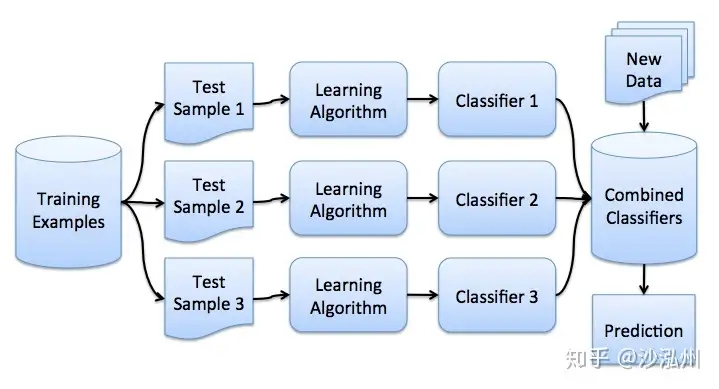

1. 从原始样例集中随机采样。每轮从原始样例集中有放回的选取n个训练样例（在训练集中，有些样例可能被多次抽取到，而有些样例可能一次都没有被抽中）。共进行k轮抽取，得到k个训练集。（bootstrap的过程，由于是有放回抽样，所以k个训练集之间**不相互独立**）
1. 每次使用一份训练集训练一个模型，k 个训练集共得到 k 个基模型。（注：这里并没有具体的分类算法或回归方法，我们可以根据具体问题采用不同的分类或回归方法，如决策树、感知器等）
1. 利用这k个基模型对测试集进行预测，将k个预测结果进行聚合。(aggregating的过程)
   - 分类问题：将上步得到的k个模型采用投票的方式得到分类结果
   - 回归问题：计算上述模型的均值作为最后的结果。（所有模型的重要性相同）

**随机森林算法**

将多个决策树结合在一起，每次数据集是随机有放回的选出，同时随机选出部分特征作为输入，所以该算法被称为随机森林算法。可以看到随机森林算法是以决策树为估计器的Bagging算法。
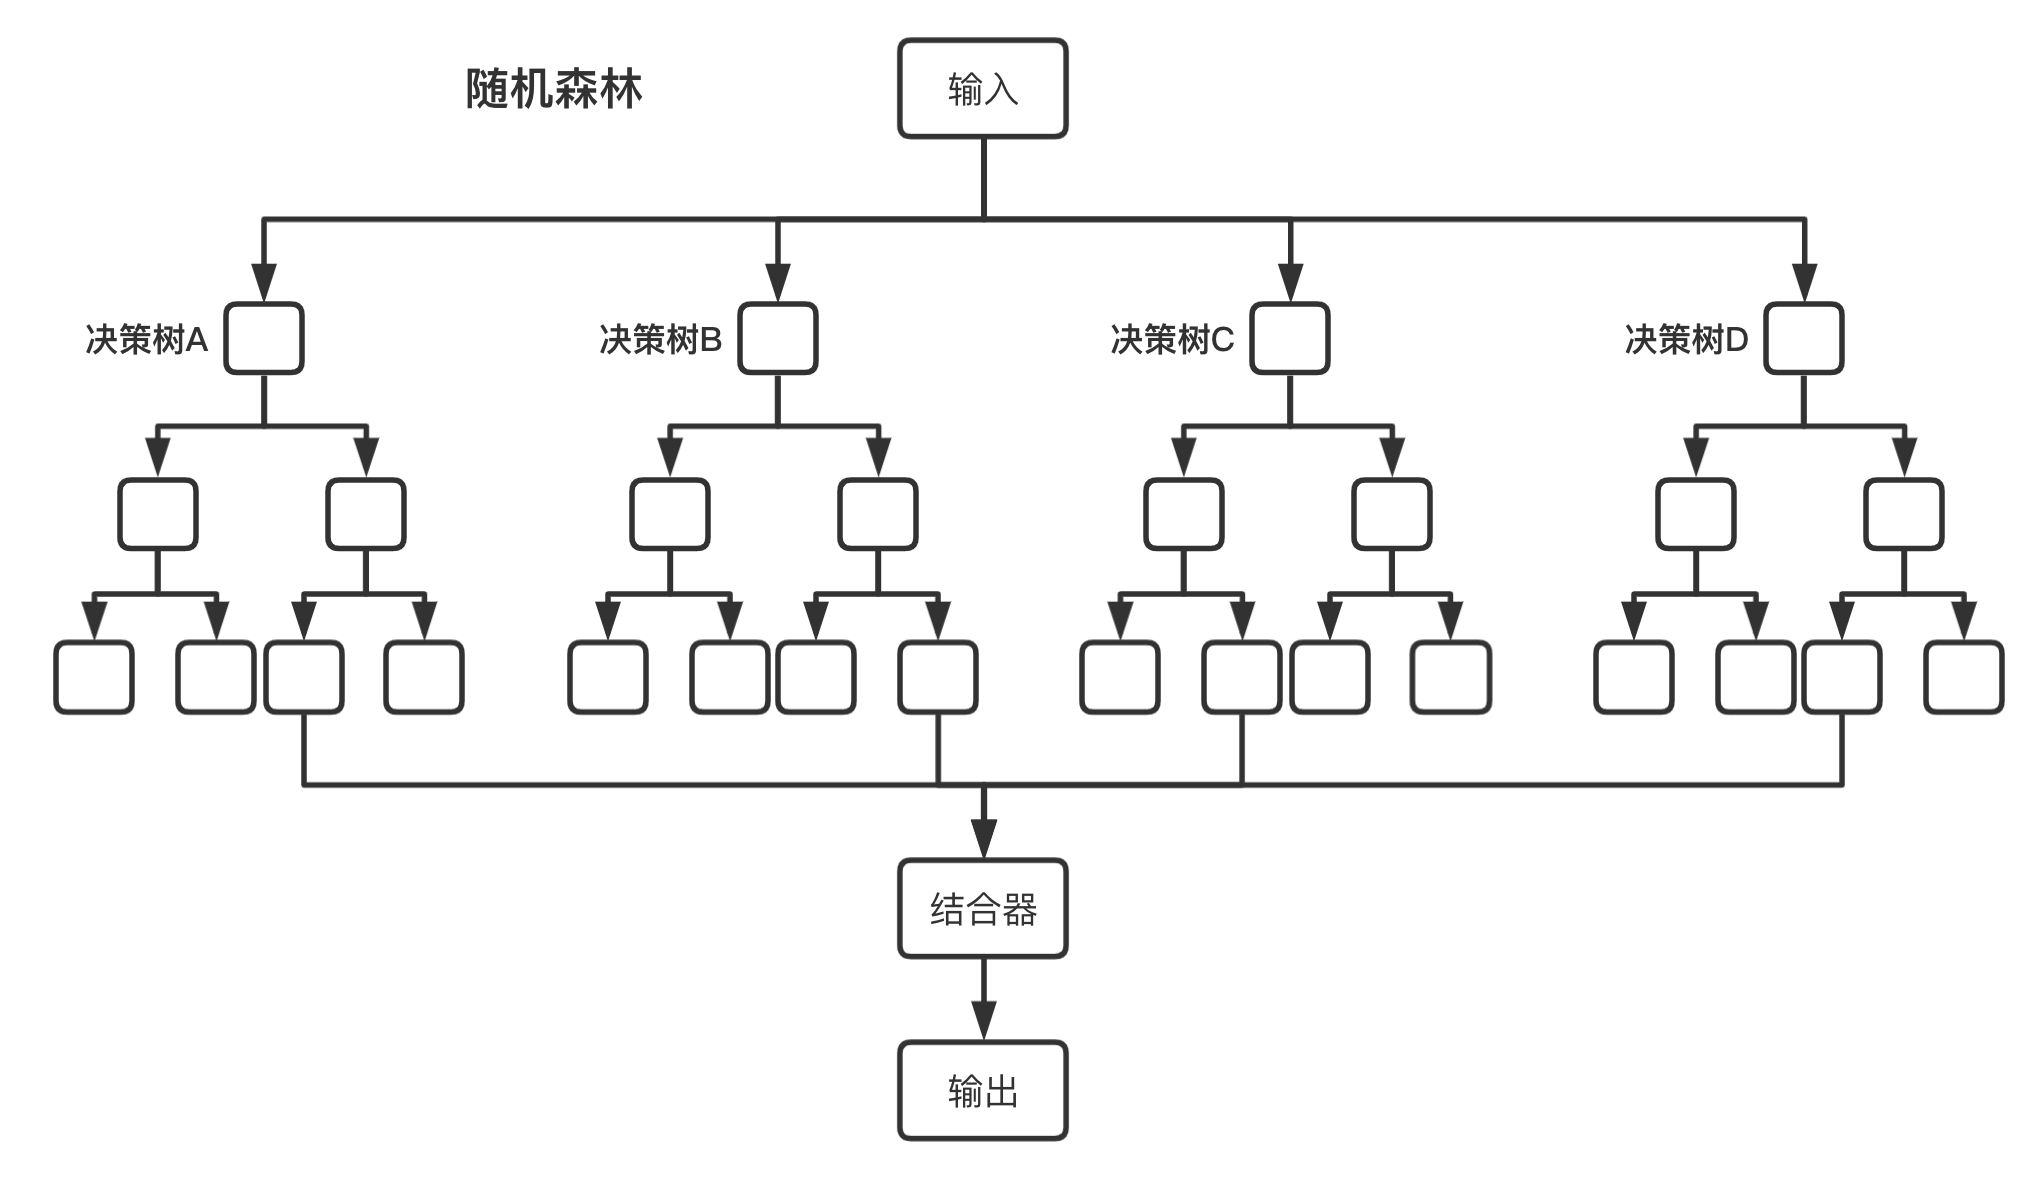

1. 一个样例容量为N的样例，有放回的<font color=Red>**随机**</font>抽取N次，每次抽取1个，最终形成了N个样例。这选择好了的N个样例用来训练一个决策树，作为决策树根节点处的样例。
2. 当每个样例有M个属性时，在决策树的每个节点需要分裂时，随机从这M个属性中<font color=Red>**随机**</font>选取出m个属性，满足条件m << M。然后从这m个属性中采用某种策略（比如说信息增益）来选择1个属性作为该节点的分裂属性。
3. 决策树形成过程中每个节点都要按照步骤2来分裂（很容易理解，如果下一次该节点选出来的那一个属性是刚刚其父节点分裂时用过的属性，则该节点已经达到了叶子节点，无须继续分裂了）。一直到不能够再分裂为止。<font color=Red>**注意整个决策树形成过程中没有进行剪枝**</font>。
4. 按照步骤1~3建立大量的决策树，这样就构成了随机森林了。
   
**Out-of-Bag（OOB）误差**

Bagging 方法最大的优势是我们可以不通过交叉验证而求得测试误差。由于采用的是有放回的抽样，平均而言，对某个样例而言，约有2/3的树该样例未参与训练，对于这2/3的树来说，该样例是“旁观者”--用这个样例检测该2/3的树的集成性能较为客观。所有的样例都这样做，就能较为客观准确地检测出“随机森林”的拟合性能。


**随机森林的优缺点**

**优点**

1. 可利用数据冗余，自我进行缺失特征值的填补。
2. 泛化性能的评估无需固定留出测试集，数据的利用率高。


**缺点**

1. 模型解释性较差。




## 性能特点

自变量无序类别数不能超过53个

In [8]:
library(pacman)

p_load(randomForest, skimr)
s <- skim_tee

# 生成数据--x1~x6与y独立
n <- 500    #数据量
set.seed(101)
x1 <- factor((sample(n) %% 2)) # 2种取值
set.seed(106)
x2 <- factor((sample(n) %% 54)) # 100种取值
set.seed(100)
y <- factor((sample(n) %% 2))

dt <- data.frame(x1, x2, y)
s(dt)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             500   
Number of columns          3     
_______________________          
Column type frequency:           
  factor                   3     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 x1                    0             1 FALSE          2
2 x2                    0             1 FALSE         54
3 y                     0             1 FALSE          2
  top_counts                
1 0: 250, 1: 250            
2 1: 10, 2: 10, 3: 10, 4: 10
3 0: 250, 1: 250            


In [9]:
rf_ab <-randomForest(y ~ ., data = dt) 

ERROR: Error in randomForest.default(m, y, ...): Can not handle categorical predictors with more than 53 categories.


# 算法解析

## 直观观察

### 分类界线

In [8]:
options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

双环数据集，黑红二类之间的理论分类界限是介于二者之间的圆

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1600  
Number of columns          3     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  2     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts    
1 y                     0             1 FALSE          2 0: 800, 1: 800

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate     mean    sd    p0    p25       p50   p75 p100 hist 
1 x1                    0             1 -0.00124 0.735 -1.59 -0.656  0.000682 0.648 1.51 ▂▇▅▇▃
2

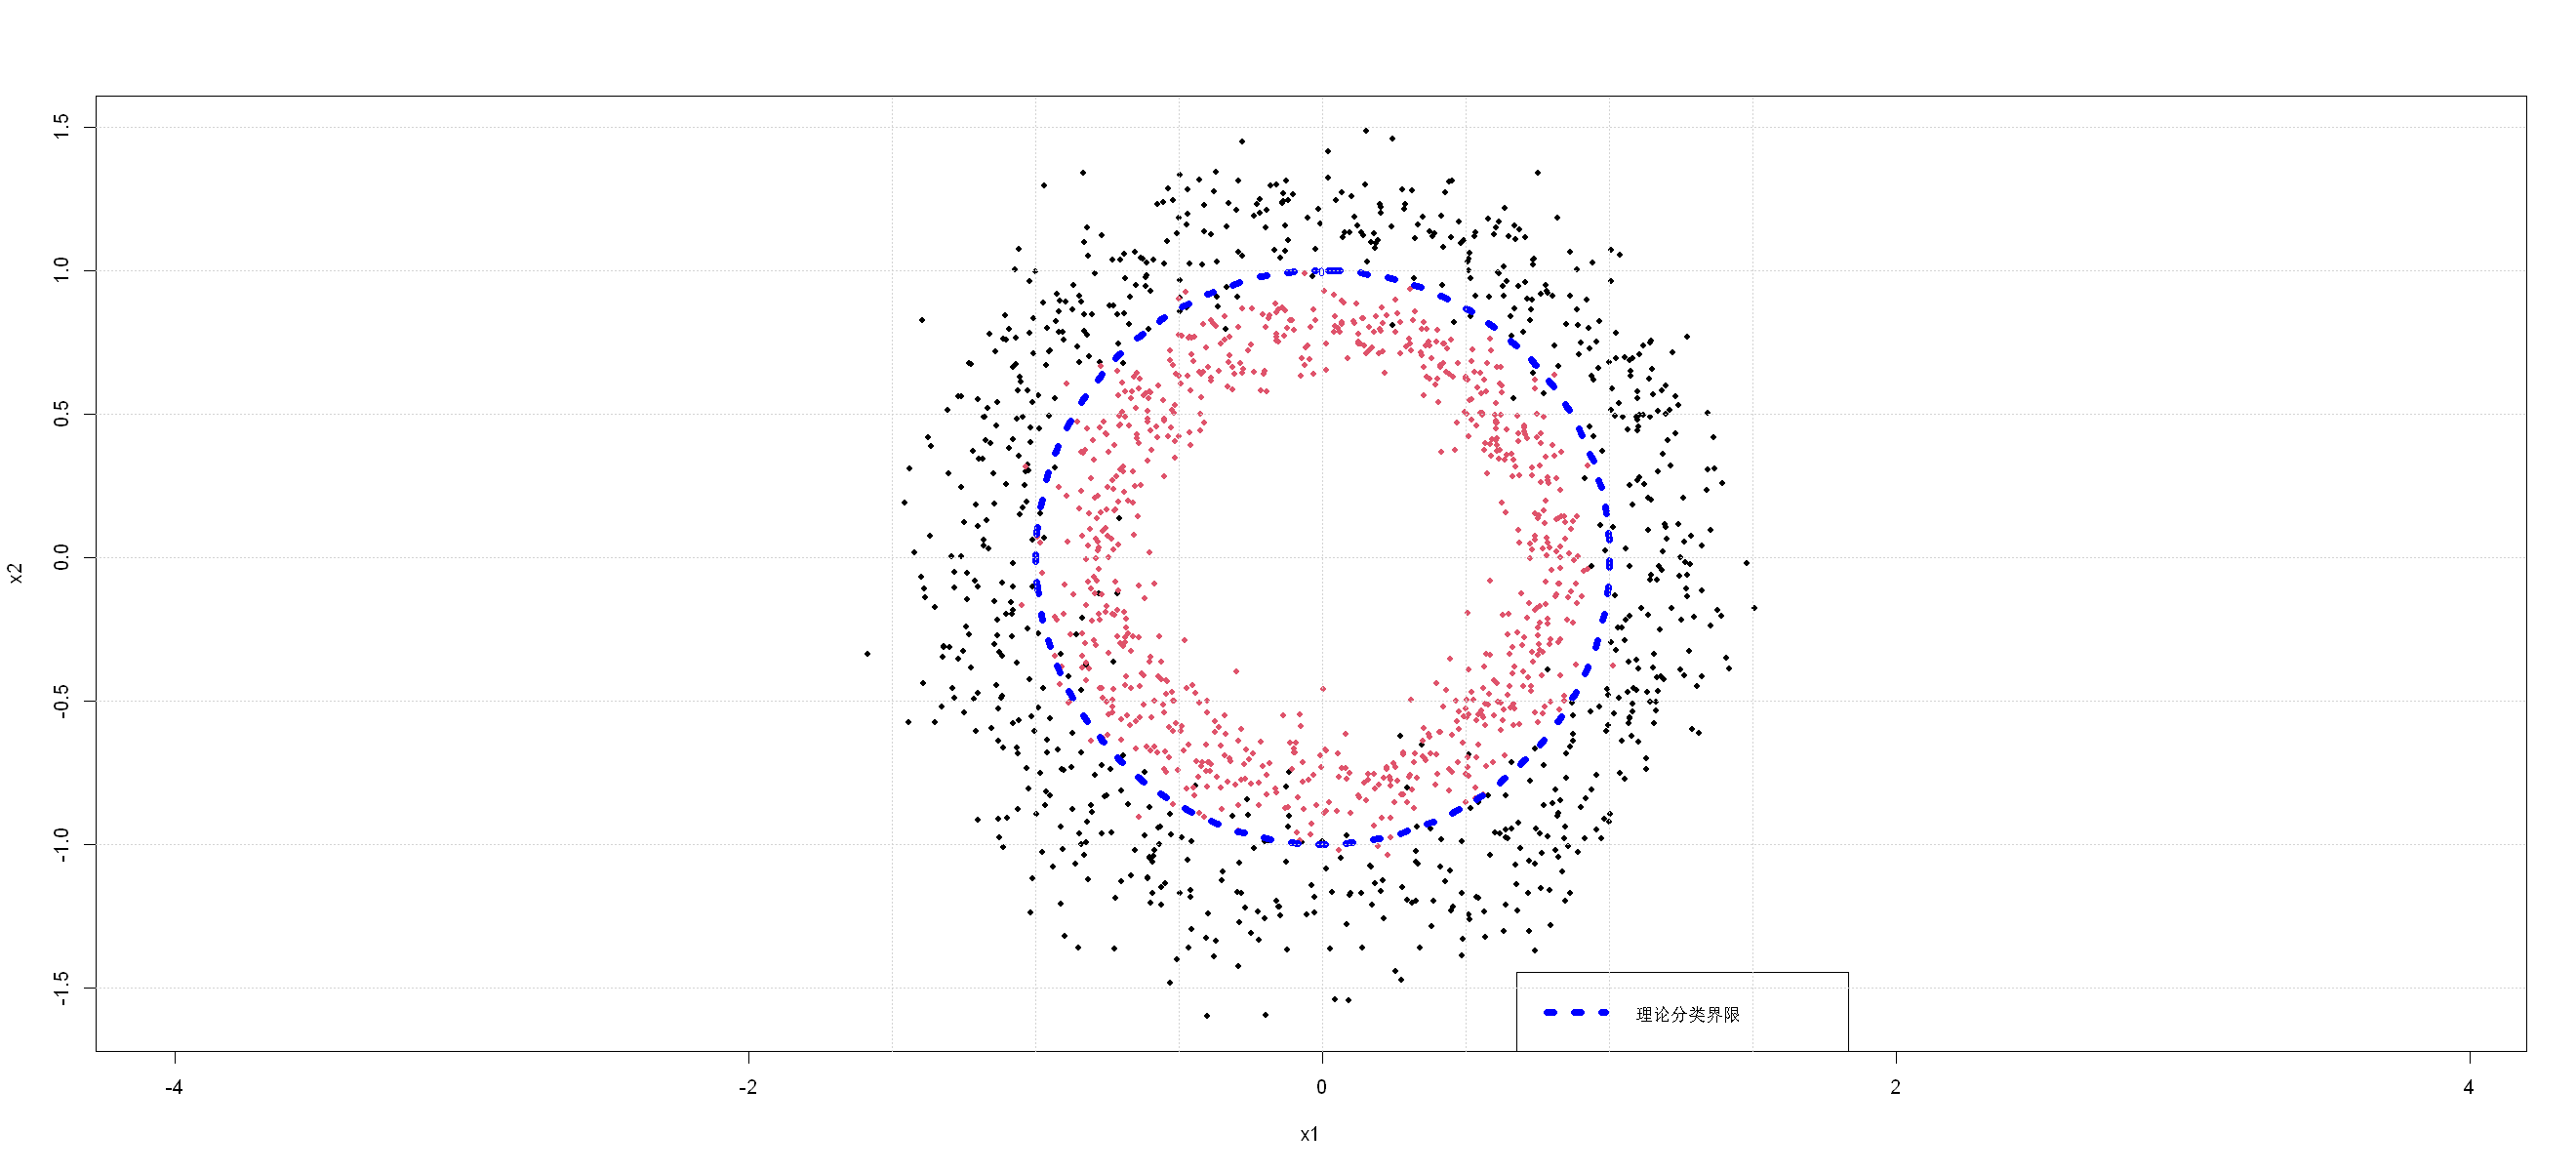

In [10]:
library(pacman)

p_load(randomForest, measures, skimr)
s <- skim_tee

#------------------构建数据集-------------------
n <- 200 # 数据集样例数为4*n
k <- 0   #随机种子

#-------外层-----------
R <- 1.2    #外层半径
x1 <- seq(-R, R, l = n)
x2 <- sqrt(R^2 - x1^2)

k <- k + 100 
set.seed(k)
x1 <- R * rnorm(n) / 10 + x1
x2 <- R * rnorm(n) / 10 + x2
D0 <- data.frame(x1, x2)

k <- k + 100
set.seed(k)
x1 <- R * rnorm(n) / 10 + x1
x2 <- R * rnorm(n) / 10 - x2
D0 <- rbind(D0, data.frame(x1, x2))

x2 <- seq(-R, R, l = n)
x1 <- sqrt(R^2 - x2^2)

k <- k + 100 # 随机种子
set.seed(k)
x1 <- R * rnorm(n) / 10 + x1
x2 <- R * rnorm(n) / 10 + x2
D0 <- rbind(D0, data.frame(x1, x2))

k <- k + 100
set.seed(k)
x1 <- R * rnorm(n) / 10 - x1
x2 <- R * rnorm(n) / 10 + x2
D0 <- rbind(D0, data.frame(x1, x2))
D0 <- D0[order(D0$x1), ]
D0$y <- 0

#-------内层-----------
R <- 0.8   #内层半径
x1 <- seq(-R, R, l = n)
x2 <- sqrt(R^2 - x1^2)

k <- k + 100 # 随机种子
set.seed(k)
x1 <- R * rnorm(n) / 10 + x1
x2 <- R * rnorm(n) / 10 + x2
D1 <- data.frame(x1, x2)

k <- k + 100
set.seed(k)
x1 <- R * rnorm(n) / 10 + x1
x2 <- R * rnorm(n) / 10 - x2
D1 <- rbind(D1, data.frame(x1, x2))

x2 <- seq(-R, R, l = n)
x1 <- sqrt(R^2 - x2^2)

k <- k + 100 # 随机种子
set.seed(k)
x1 <- R * rnorm(n) / 10 + x1
x2 <- R * rnorm(n) / 10 + x2
D1 <- rbind(D1, data.frame(x1, x2))

k <- k + 100
set.seed(k)
x1 <- R * rnorm(n) / 10 - x1
x2 <- R * rnorm(n) / 10 + x2
D1 <- rbind(D1, data.frame(x1, x2))
D1 <- D1[order(D1$x1), ]
D1$y <- 1

#----------内外层合并-----------
dt_cl <- rbind(D0, D1)
dt_cl$y <- factor(dt_cl$y)
plot(dt_cl$x1, dt_cl$x2, col = dt_cl$y, asp = TRUE, pch = 20, xlab = "x1", ylab = "x2")

x1 <- seq(min(dt_cl$x1), max(dt_cl$x1), length = 100)
x2 <- seq(min(dt_cl$x2), max(dt_cl$x2), length = 100)
y <- outer(x1, x2, function(x1, x2) x1^2 + x2^2 - 1)
contour(x1, x2, y, levels = 0, add = TRUE, lwd = 6, lty = 3, col = "blue")

legend("bottomright", "理论分类界限", lwd = 6, col = "blue", lty = 3)
grid()

s(dt_cl)  #勘察数据

--------------------树的个数为： 5 ----------------------------
--------------------树的个数为： 10 ----------------------------
--------------------树的个数为： 100 ----------------------------
--------------------树的个数为： 500 ----------------------------


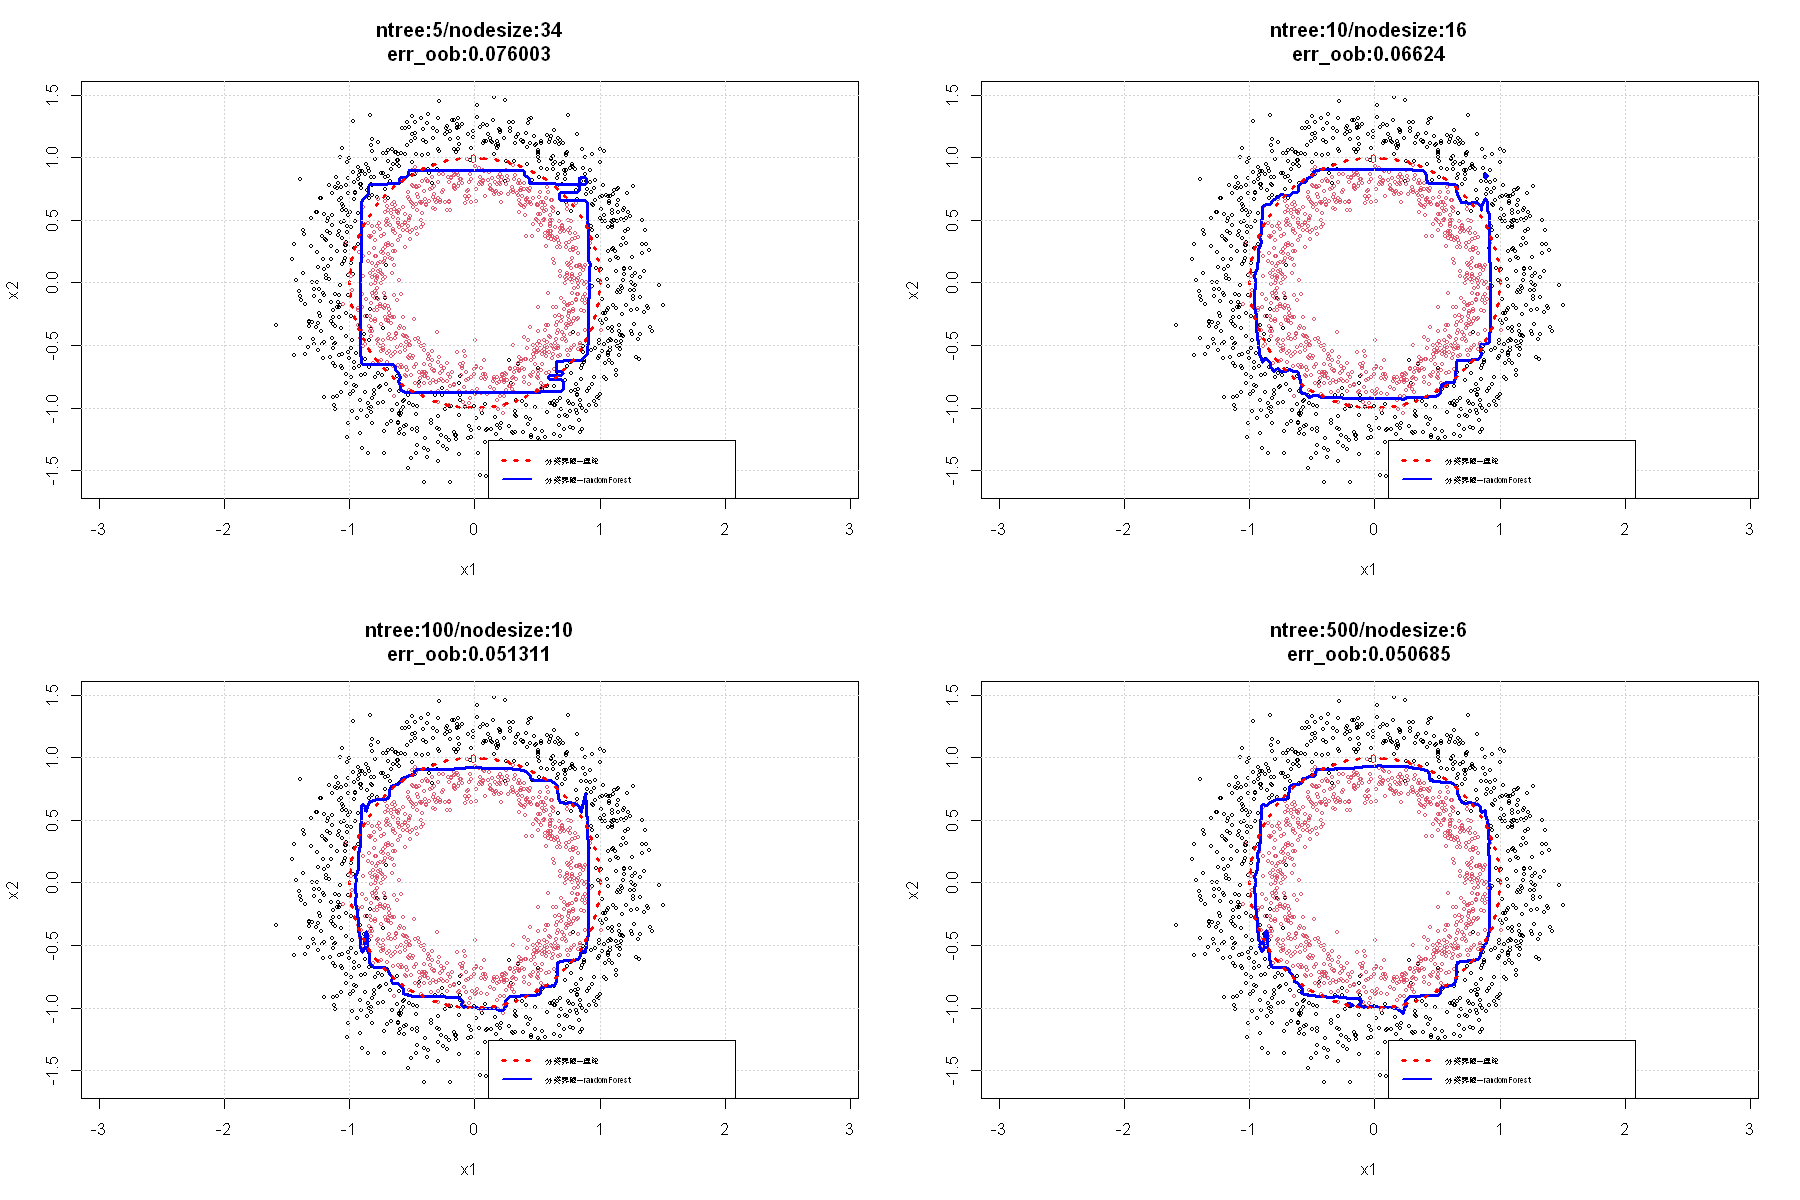

In [32]:
library(pacman)
p_load(randomForest, GA)

#------------------------------ga目标函数------------------------------------
ACC_OOB <- function(k) {
  set.seed(711)
  rf <- randomForest(y ~ .,
    data = dt_cl, ntree = n, nodesize = floor(k),
    importance = FALSE, proximity = FALSE, localImp = FALSE
  )
  cf <- rf$confusion
  return(sum(diag(cf)) / sum(cf))
}

#-------------------------------------绘制对比图-----------------------------
par(mfrow = c(2, 2))
for (n in c(5, 10, 100, 500)) {
  cat("--------------------树的个数为：", n, "----------------------------\n")

  # 使用遗传算法，优化参数nodesize--叶节点中至少要包含的样例个数-----------
  GA <- ga(
    monitor = FALSE,
    parallel = TRUE, seed = 100, type = "real-valued", fitness = ACC_OOB,
    lower = 2, upper = 1000, popSize = 100, run = 20 # 终止条件--停滞的代数
  )

  set.seed(711)      #要和目标函数中的随机种子相同
  rfo <- randomForest(y ~ ., data = dt_cl, ntree = n, nodesize = floor(GA@solution[1]))
  cf <- rfo$confusion
  err_oob <- 1 - sum(diag(cf)) / sum(cf)

  x1 <- seq(min(dt_cl$x1), max(dt_cl$x1), length = 100)
  x2 <- seq(min(dt_cl$x2), max(dt_cl$x2), length = 100)
  pd <- function(x1, x2) {
    predict(rfo, data.frame(x1, x2), type = "prob")[, 1]
  }

  plot(dt_cl$x1, dt_cl$x2, col = dt_cl$y, cex = 0.5, xlab = "x1", ylab = "x2", asp = 1)

  z <- outer(x1, x2, FUN = pd)
  contour(x1, x2, z, levels = 0.5, drawlabels = FALSE, lwd = 3, col = "blue", add = TRUE) 

  y <- outer(x1, x2, function(x1, x2) x1^2 + x2^2 - 1)
  contour(x1, x2, y, levels = 0, add = TRUE, lwd = 3, lty = 3, col = "red")
  grid()

  title(stringr::str_glue("ntree:{n}/nodesize:{floor(GA@solution[1])}\nerr_oob:{round(err_oob,6)}"))
  legend("bottomright", c("分类界限--理论", "分类界限--randomForest"), cex = 0.5, lwd = c(3, 2), col = c("red", "blue"), lty = c(3, 1))
}

nodesize对拟合性能的影响--ntree固定

In [ ]:
library(pacman)
p_load(randomForest, GA)

for (n in c(5, 10, 100, 500)) {
  cat("--------------------nodesize：", n, "----------------------------\n")

  set.seed(711)      #要和目标函数中的随机种子相同
  rf <- randomForest(y ~ ., data = dt_cl, ntree = 500, nodesize = n)
  
}

可见随着树的增多，袋外准确率acc_oob逐渐增大，模型的泛化性能渐优。

综合优化ntree和nodesize参数值：

GA | iter = 1 | Mean = 0.8494351 | Best = 0.9468121
GA | iter = 2 | Mean = 0.9024598 | Best = 0.9468121
GA | iter = 3 | Mean = 0.9054828 | Best = 0.9468121
GA | iter = 4 | Mean = 0.9067301 | Best = 0.9468121
GA | iter = 5 | Mean = 0.9048377 | Best = 0.9468121
GA | iter = 6 | Mean = 0.9072736 | Best = 0.9468121
GA | iter = 7 | Mean = 0.9075583 | Best = 0.9468121
GA | iter = 8 | Mean = 0.9074027 | Best = 0.9468121
GA | iter = 9 | Mean = 0.9098167 | Best = 0.9468121
GA | iter = 10 | Mean = 0.9035511 | Best = 0.9468121
GA | iter = 11 | Mean = 0.9098675 | Best = 0.9468121
GA | iter = 12 | Mean = 0.9108708 | Best = 0.9468121
GA | iter = 13 | Mean = 0.9049833 | Best = 0.9474378
GA | iter = 14 | Mean = 0.9092544 | Best = 0.9474378
GA | iter = 15 | Mean = 0.9093444 | Best = 0.9474378
GA | iter = 16 | Mean = 0.9098045 | Best = 0.9474378
GA | iter = 17 | Mean = 0.9073660 | Best = 0.9480635
GA | iter = 18 | Mean = 0.9103399 | Best = 0.9480635
GA | iter = 19 | Mean = 0.9099423 | Best = 0.9480635
GA

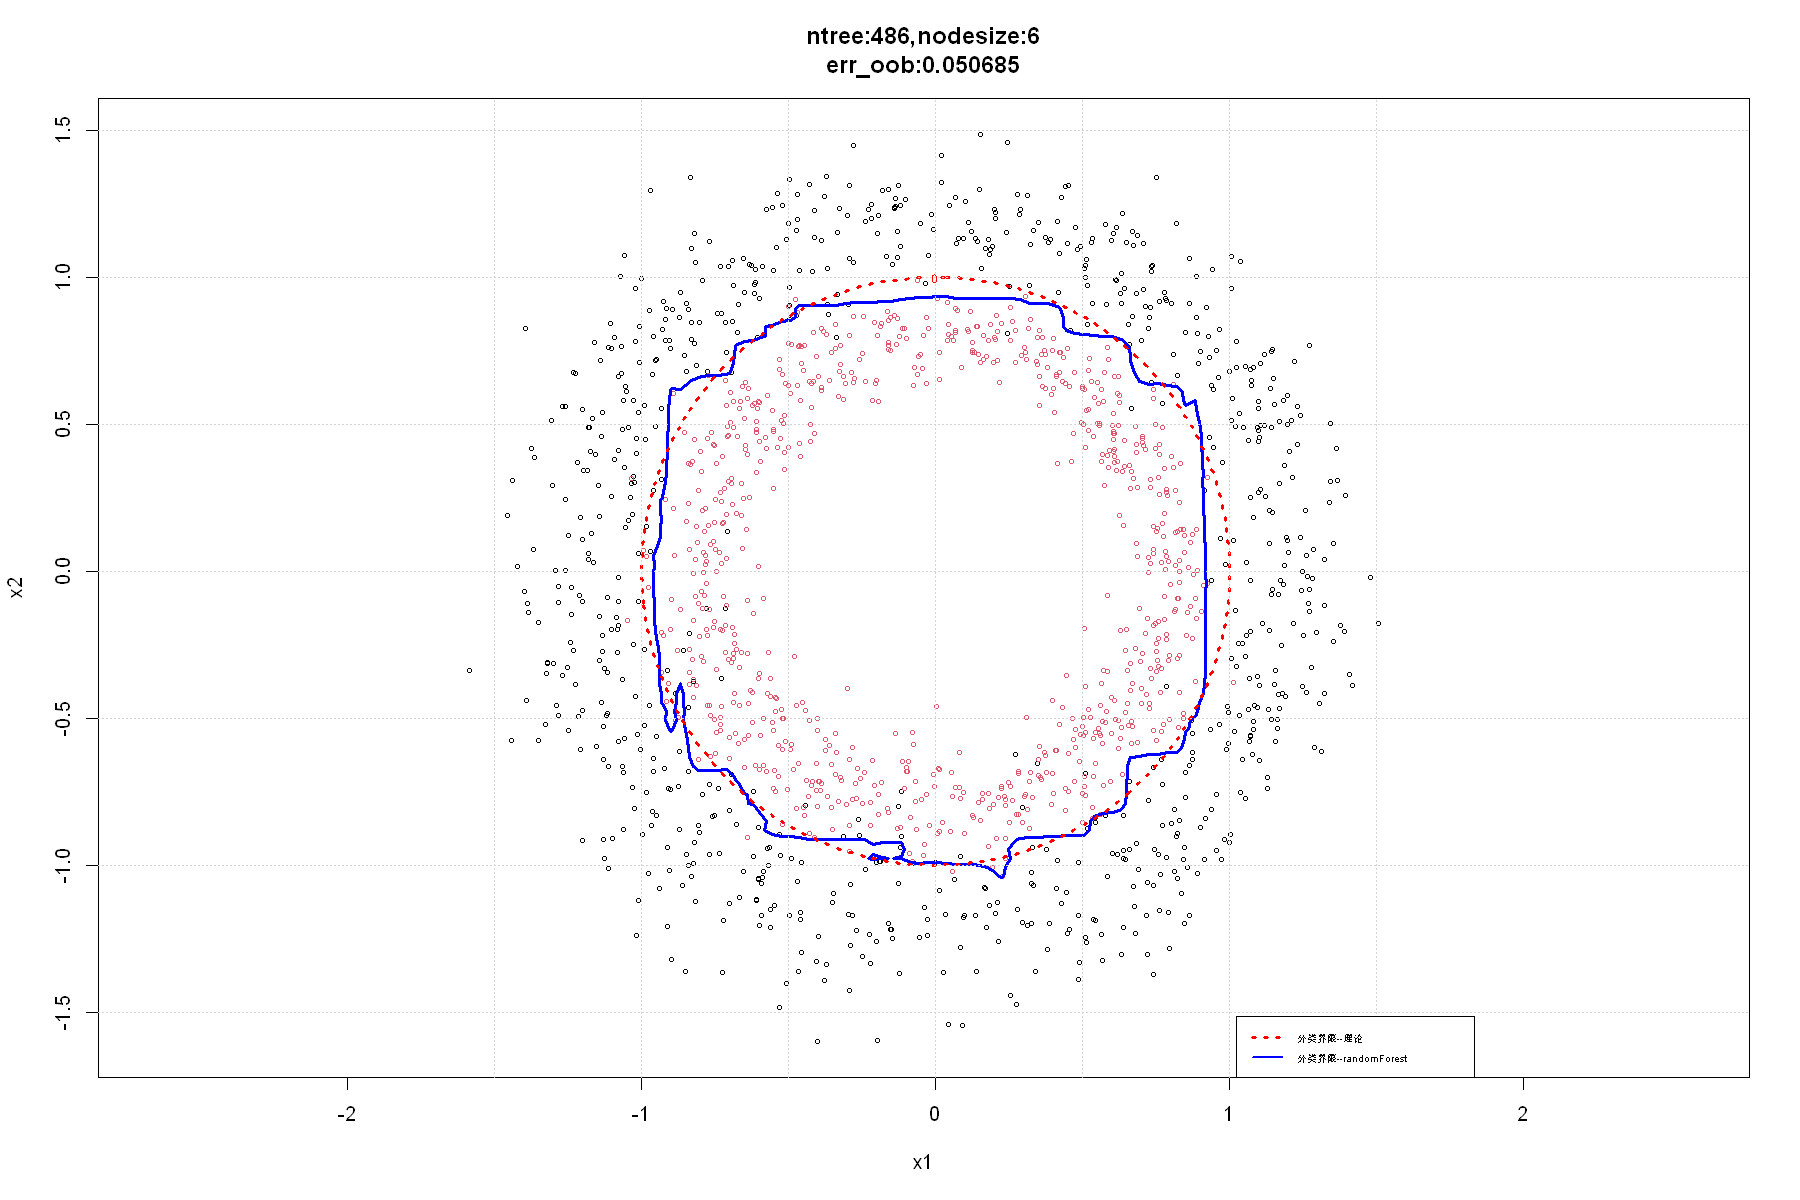

In [33]:
p_load(GA, parallel, doParallel)

#--------------------ga目标函数-----------------------------
ACC_OOB <- function(k) {
  set.seed(711)
  rf <- randomForest(y ~ .,
    data = dt_cl, ntree = floor(k[1]), nodesize = floor(k[2]),
    importance = FALSE, proximity = FALSE, localImp = FALSE
  )
  cf <- rf$confusion
  return(sum(diag(cf)) / sum(cf))
}

# 使用遗传算法，优化参数nodesize：叶节点中至少要包含的样例个数-----------
GA <- ga(
  monitor = TRUE,
  parallel = TRUE, seed = 100, type = "real-valued", fitness = ACC_OOB,
  lower = c(2, 2), upper = c(1000, 1000), popSize = 200, run = 20 # 终止条件--停滞的代数
)

set.seed(711)      #要和目标函数中的随机种子相同
rfo <- randomForest(y ~ ., data = dt_cl, ntree = floor(GA@solution[1, 1]), nodesize = floor(GA@solution[1, 2]))
cf <- rfo$confusion
err_oob <- 1 - sum(diag(cf)) / sum(cf)

x1 <- seq(min(dt_cl$x1), max(dt_cl$x1), length = 100)
x2 <- seq(min(dt_cl$x2), max(dt_cl$x2), length = 100)
pd <- function(x1, x2) {
  predict(rfo, data.frame(x1, x2), type = "prob")[, 1]
}

plot(dt_cl$x1, dt_cl$x2, col = dt_cl$y, cex = 0.5, xlab = "x1", ylab = "x2", asp = 1)
z <- outer(x1, x2, FUN = pd)
contour(x1, x2, z, levels = 0.5, drawlabels = FALSE, lwd = 3, col = "blue", add = TRUE)

y <- outer(x1, x2, function(x1, x2) x1^2 + x2^2 - 1)
contour(x1, x2, y, levels = 0, add = TRUE, lwd = 3, lty = 3, col = "red")
grid()
title(stringr::str_glue("ntree:{floor(GA@solution[1, 1])},nodesize:{floor(GA@solution[1, 2])}\nerr_oob:{round(err_oob,6)}"))
legend("bottomright", c("分类界限--理论", "分类界限--randomForest"), cex = 0.5, lwd = c(3, 2), col = c("red", "blue"), lty = c(3, 1))

综合优化ntree和nodesize参数值通常使得误差进一步降低，虽然本例没有明显降幅。

### 回归曲线

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(randomForest, measures, skimr, rpart, treemisc)
s <- skim_tee

**构建训练集**

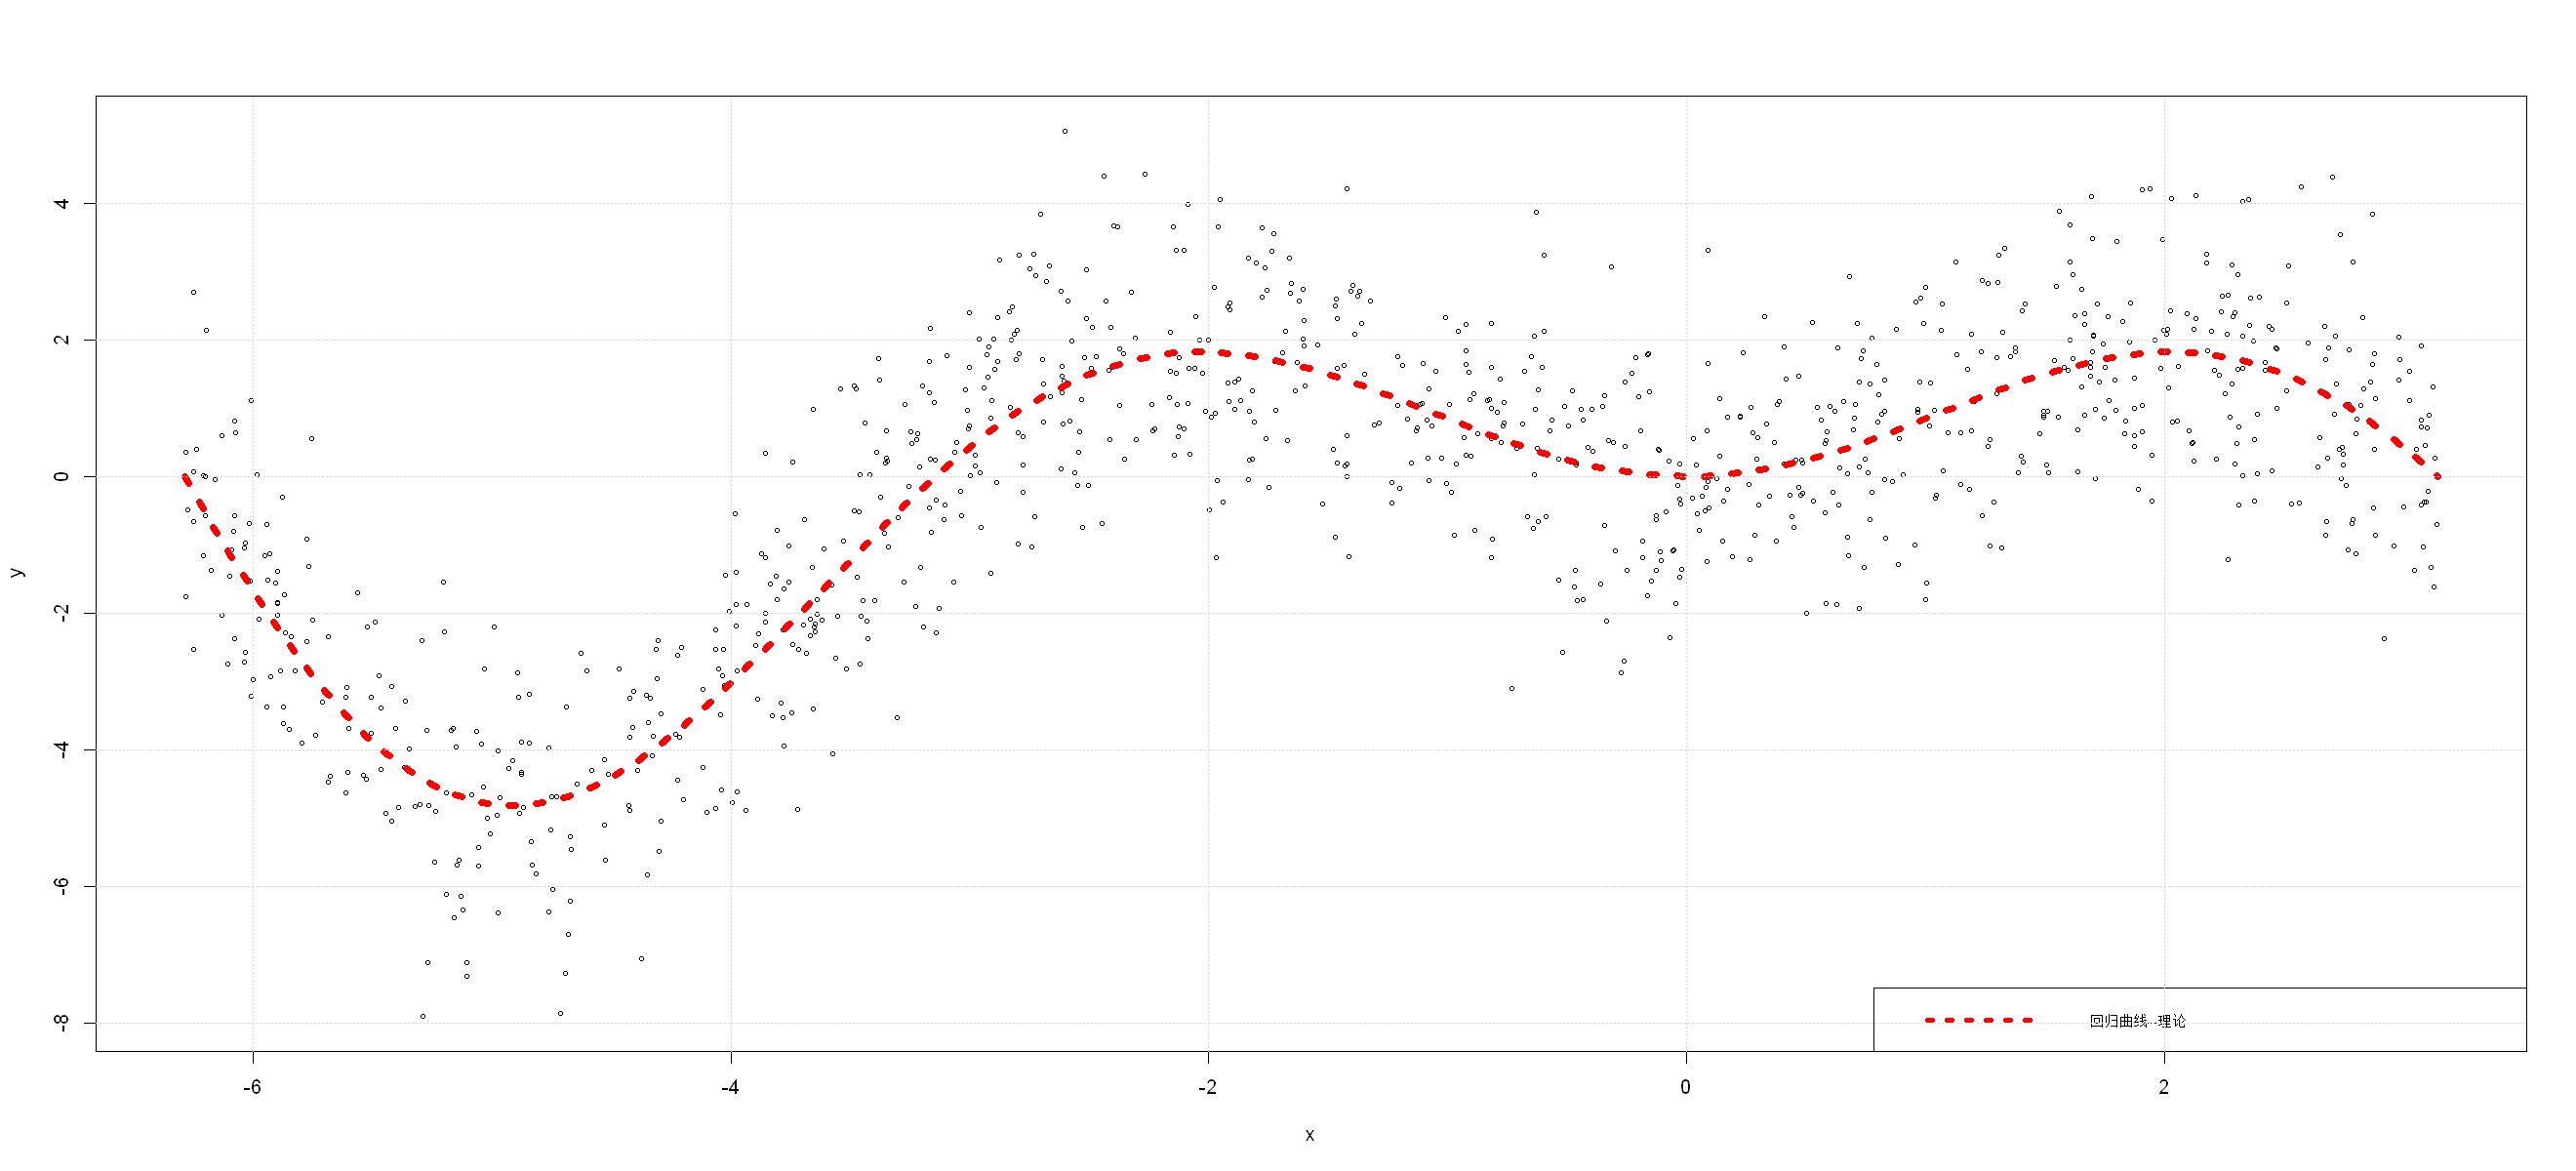

In [7]:
n <- 1000

set.seed(100)
x <- sort(runif(n, -2 * pi, pi))
y <- x * sin(x) + 1.2 * rnorm(n)
plot(x, y, cex = 0.5, xlab = "x", ylab = "y")
grid()
dt_re <- data.frame(x, y)     #训练集

curve( x * sin(x), -2 * pi, pi, bty = "l", lwd = 6, col = "red", lty = 3, add = TRUE)

legend("bottomright", "回归曲线--理论", lwd = 4, col = "red", lty = 3, cex = 0.8)
grid()

**勘察训练集**

In [3]:
s(dt_re)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          2     
_______________________          
Column type frequency:           
  numeric                  2     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean   sd    p0   p25    p50   p75 p100 hist 
1 x                     0             1 -1.40  2.71 -6.28 -3.64 -1.41  0.916 3.14 ▆▇▇▇▇
2 y                     0             1 -0.125 2.34 -7.89 -1.45  0.355 1.55  5.05 ▁▂▅▇▂


--------------------树的个数为： 1 ----------------------------
--------------------树的个数为： 5 ----------------------------
--------------------树的个数为： 50 ----------------------------
--------------------树的个数为： 100 ----------------------------


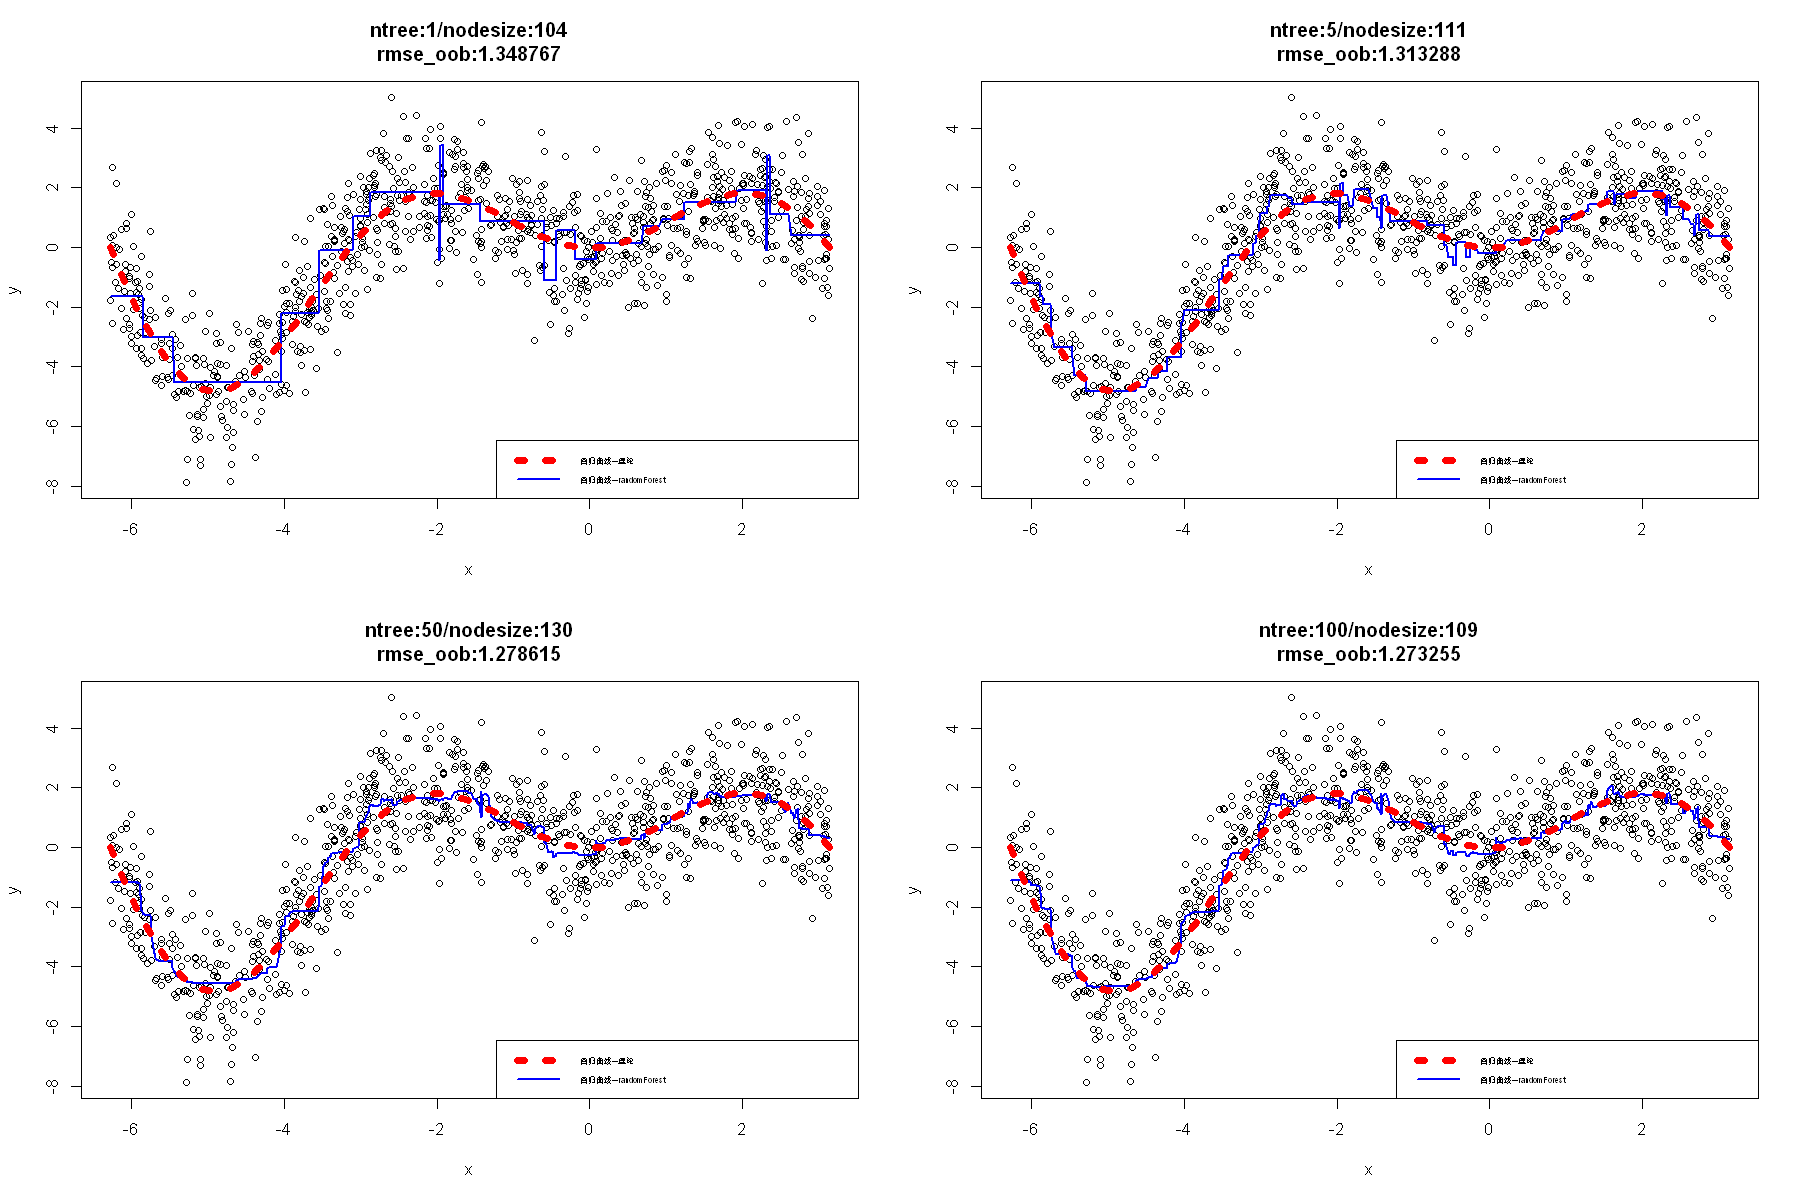

In [35]:
par(mfrow = c(2, 2))

p_load(GA, parallel, doParallel)

RMSE_OOB <- function(k) {
  set.seed(100)
  rf <- randomForest(y ~ ., dt_re,
    ntree = n, nodesize = floor(k),
    importance = FALSE, proximity = FALSE, localImp = FALSE
  )
  return(-sqrt(mean(rf$mse)))
}

for (n in c(1, 5, 50, 100)) {
  cat("--------------------树的个数为：", n, "----------------------------\n")
  GA <- ga(
    parallel = TRUE, seed = 100,
    type = "real-valued", fitness = RMSE_OOB,
    lower = 2, upper = 500, monitor = FALSE,
    popSize = 100, run = 20 # 终止条件--停滞的代数
  )

  set.seed(100)     #要和目标函数中的随机种子相同
  rfo <- randomForest(y ~ ., dt_re, ntree = n, nodesize = floor(GA@solution[1]))
  rmse_oob <- sqrt(mean(rfo$mse))

  plot(dt_re$x, dt_re$y, xlab = "x", ylab = "y")
  lines(dt_re$x, predict(rfo, dt_re), col = "blue", add = TRUE, lwd = 2)
  curve(x * sin(x), -2 * pi, pi, bty = "l", lwd = 6, col = "red", lty = 3, add = TRUE)
  title(stringr::str_glue("ntree:{n}/nodesize:{floor(GA@solution[1])}\nrmse_oob:{round(rmse_oob,6)}"))
  legend("bottomright", c("回归曲线--理论", "回归曲线--randomForest"), cex = 0.5, lwd = c(6, 2), col = c("red", "blue"), lty = c(3, 1))
}


可见：随机森林随着树的个数ntree增大(优化相应的nodesize)，rmse_oob呈现下降趋势，回归曲线也越来越平滑。

下面，综合优化ntree和rmse_oob：

GA | iter = 1 | Mean = -1.378299 | Best = -1.268698
GA | iter = 2 | Mean = -1.309304 | Best = -1.268698
GA | iter = 3 | Mean = -1.287576 | Best = -1.268698
GA | iter = 4 | Mean = -1.277968 | Best = -1.268698
GA | iter = 5 | Mean = -1.280325 | Best = -1.268673
GA | iter = 6 | Mean = -1.274218 | Best = -1.268659
GA | iter = 7 | Mean = -1.274630 | Best = -1.268568
GA | iter = 8 | Mean = -1.274655 | Best = -1.268568
GA | iter = 9 | Mean = -1.274940 | Best = -1.268568
GA | iter = 10 | Mean = -1.276647 | Best = -1.268568
GA | iter = 11 | Mean = -1.274324 | Best = -1.268568
GA | iter = 12 | Mean = -1.273871 | Best = -1.268564
GA | iter = 13 | Mean = -1.276473 | Best = -1.268564
GA | iter = 14 | Mean = -1.275467 | Best = -1.268564
GA | iter = 15 | Mean = -1.275725 | Best = -1.268564
GA | iter = 16 | Mean = -1.275424 | Best = -1.268564
GA | iter = 17 | Mean = -1.274575 | Best = -1.268564
GA | iter = 18 | Mean = -1.275147 | Best = -1.268564
GA | iter = 19 | Mean = -1.276085 | Best = -1.268564
GA

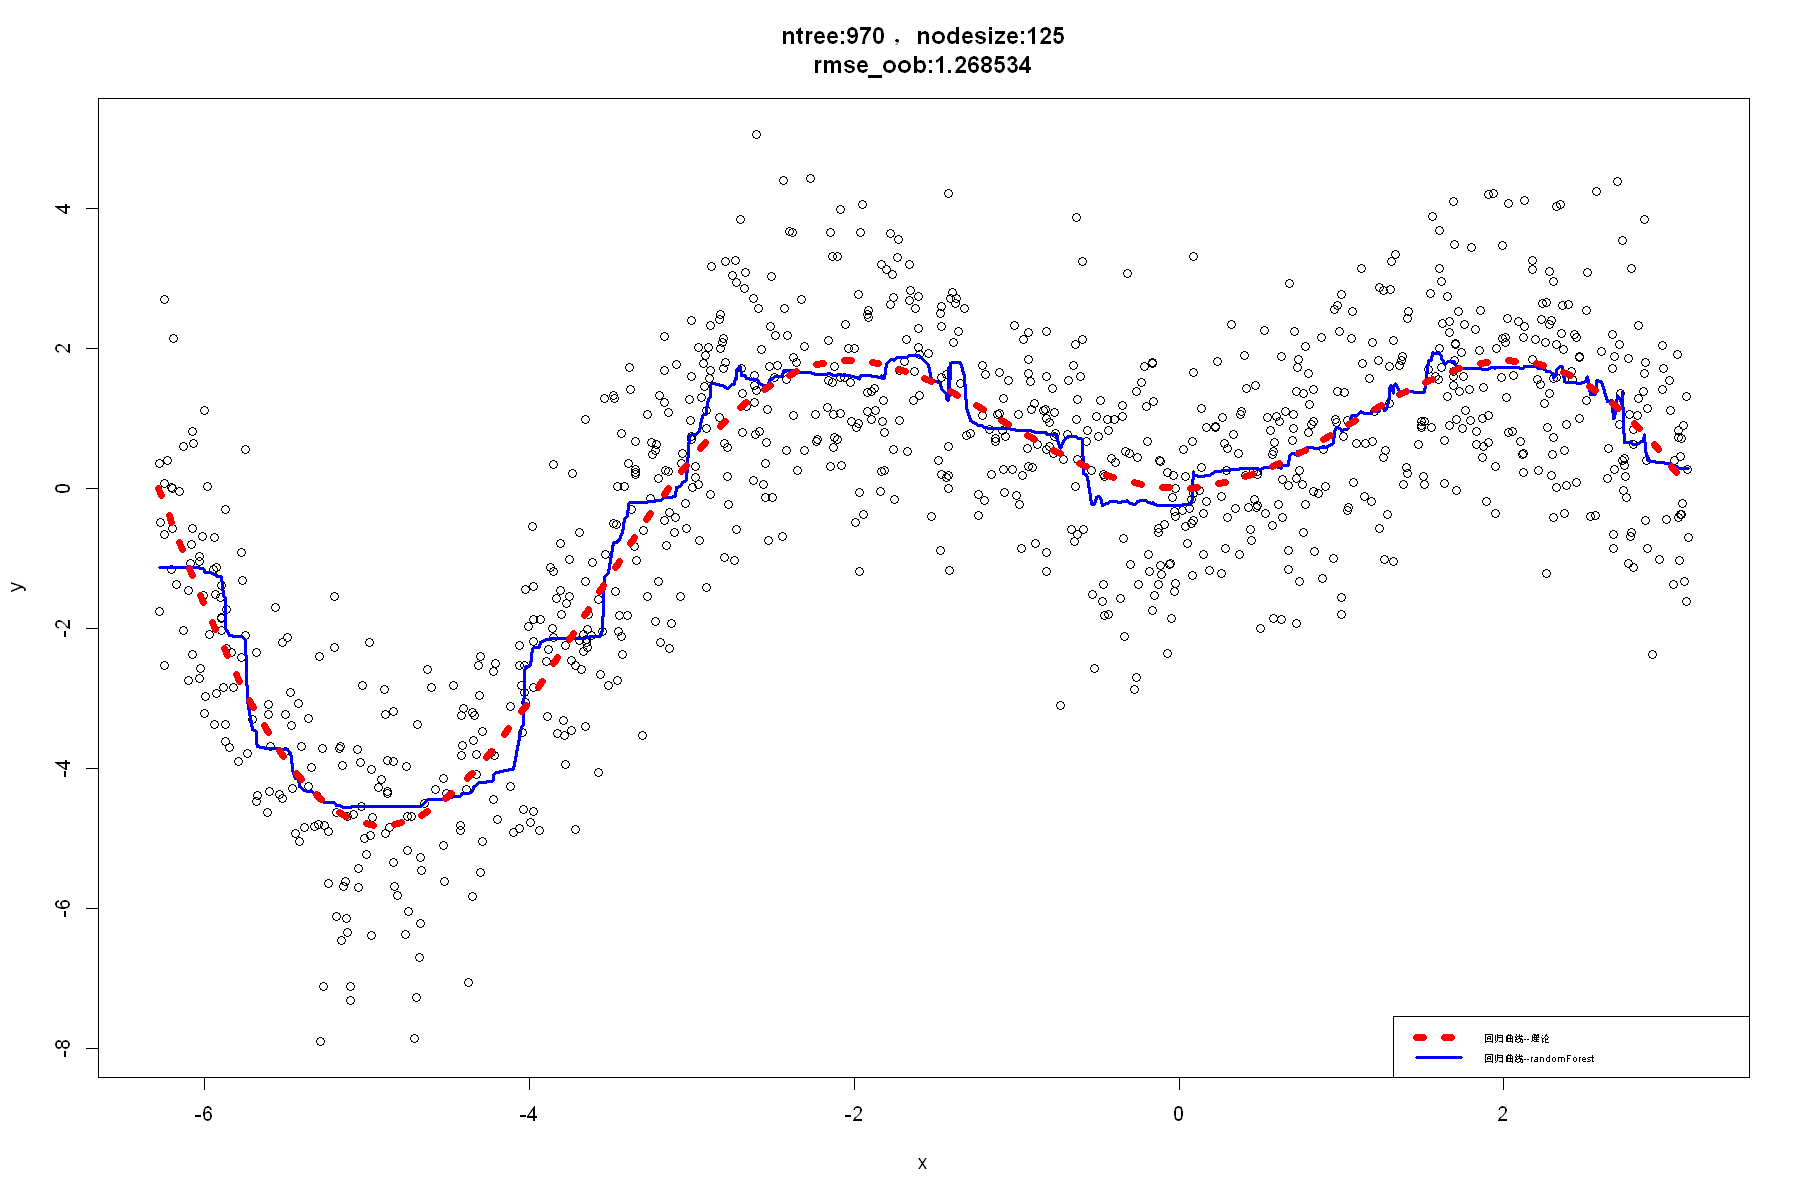

In [36]:
p_load(GA, parallel, doParallel)

RMSE_OOB <- function(k) {
  set.seed(100)
  rf <- randomForest(y ~ ., dt_re,
    ntree = floor(k[1]), nodesize = floor(k[2]),
    importance = FALSE, proximity = FALSE, localImp = FALSE
  )
  return(-sqrt(mean(rf$mse)))
}

GA <- ga(
  parallel = TRUE, seed = 100,
  type = "real-valued", fitness = RMSE_OOB,
  lower =  c(2, 2), upper = c(1000, 500) , monitor = TRUE,
  popSize = 200, run = 20 # 终止条件--停滞的代数
)  

set.seed(100)    #要和目标函数中的随机种子相同
rfo <- randomForest(y ~ ., dt_re, ntree = floor(GA@solution[1,1]), nodesize = floor(GA@solution[1,2]))
rmse_oob <- sqrt(mean(rfo$mse))

plot(dt_re$x, dt_re$y, xlab = "x", ylab = "y")
grid()
lines(dt_re$x, predict(rfo, dt_re), col = "blue", add = TRUE, lwd = 3)
curve( x * sin(x), -2 * pi, pi, bty = "l", lwd = 6, col = "red", lty = 3, add = TRUE)
title(stringr::str_glue("ntree:{floor(GA@solution[1,1])} ，nodesize:{floor(GA@solution[1,2])}\nrmse_oob:{round(rmse_oob,6)}"))
legend("bottomright", c("回归曲线--理论", "回归曲线--randomForest"), cex = 0.5, lwd = c(6, 3), col = c("red", "blue"), lty = c(3, 1))

可见综合优化ntree和nodesize参数，rmse_oob进一步降低，模型的泛化性能更佳。

## 分类

### 代价不敏感

abalone数据集来自4177只鲍鱼，自变量包括type(公、母、幼)、LongestShell 、Diameter、 Height和几种重量(WholeWeight、ShuckedWeight、VisceraWeightShellWeight)，因变量是Rings(外壳上的环数)。

将abalone 数据集的Rings值改造成"L"、 "H"二个数量大致相同的类别，当前的问题是根据一系列自变量，判断Rings类别，自变量混合取值--<font color=Red>既有离散取值，也有连续取值</font>。

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

p_load(rpart, randomForest, treemisc, AppliedPredictiveModeling, skimr)
s <- skim_tee

In [2]:
#将数据改造成平衡的二类(Rings)
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 2096, H: 2081         

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

In [3]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)
train_ab <- ab[I, ]
test_ab <- ab[-I, ]
s(train_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1044, H: 1044      

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

默认：ntree=500，对于分类问题mtry=floor(sqrt(ncol(x)))，nodesize=1

In [4]:
set.seed(71)
(rf_ab <-randomForest(Rings ~ ., data = train_ab, importance = TRUE, proximity = TRUE, localImp = TRUE)) #默认norm.votes=TRUE


Call:
 randomForest(formula = Rings ~ ., data = train_ab, importance = TRUE,      proximity = TRUE, localImp = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 21.12%
Confusion matrix:
    L   H class.error
L 797 247   0.2365900
H 194 850   0.1858238

“OOB estimate of  error rate”是指训练集中的样例用其没有参与生成的决策树判断的error rate

下面使用遗传算法，优化mtry和ntree、nodesize参数

GA | iter = 1 | Mean = 0.7885688 | Best = 0.7958215
GA | iter = 2 | Mean = 0.7906126 | Best = 0.7982175
GA | iter = 3 | Mean = 0.7914416 | Best = 0.7982175
GA | iter = 4 | Mean = 0.7921029 | Best = 0.7982175
GA | iter = 5 | Mean = 0.7918729 | Best = 0.7982175
GA | iter = 6 | Mean = 0.7910631 | Best = 0.7982175
GA | iter = 7 | Mean = 0.7919783 | Best = 0.7982175
GA | iter = 8 | Mean = 0.7923042 | Best = 0.7982175
GA | iter = 9 | Mean = 0.7924384 | Best = 0.7982175
GA | iter = 10 | Mean = 0.7916285 | Best = 0.7982175
GA | iter = 11 | Mean = 0.7918585 | Best = 0.7982175
GA | iter = 12 | Mean = 0.7914752 | Best = 0.7982175
GA | iter = 13 | Mean = 0.7915710 | Best = 0.7982175
GA | iter = 14 | Mean = 0.7921988 | Best = 0.7982175
GA | iter = 15 | Mean = 0.7924096 | Best = 0.7982175
GA | iter = 16 | Mean = 0.7917387 | Best = 0.7982175
GA | iter = 17 | Mean = 0.7916285 | Best = 0.7982175
GA | iter = 18 | Mean = 0.7915902 | Best = 0.7982175
GA | iter = 19 | Mean = 0.7914704 | Best = 0.7982175
GA

── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  100 
Number of generations =  100 
Elitism               =  5 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
      x1  x2  x3
lower  2   2   2
upper  8 500 100

GA results: 
Iterations             = 21 
Fitness function value = 0.7982175 
Solution = 
           x1       x2       x3
[1,] 6.568143 119.2526 38.88772

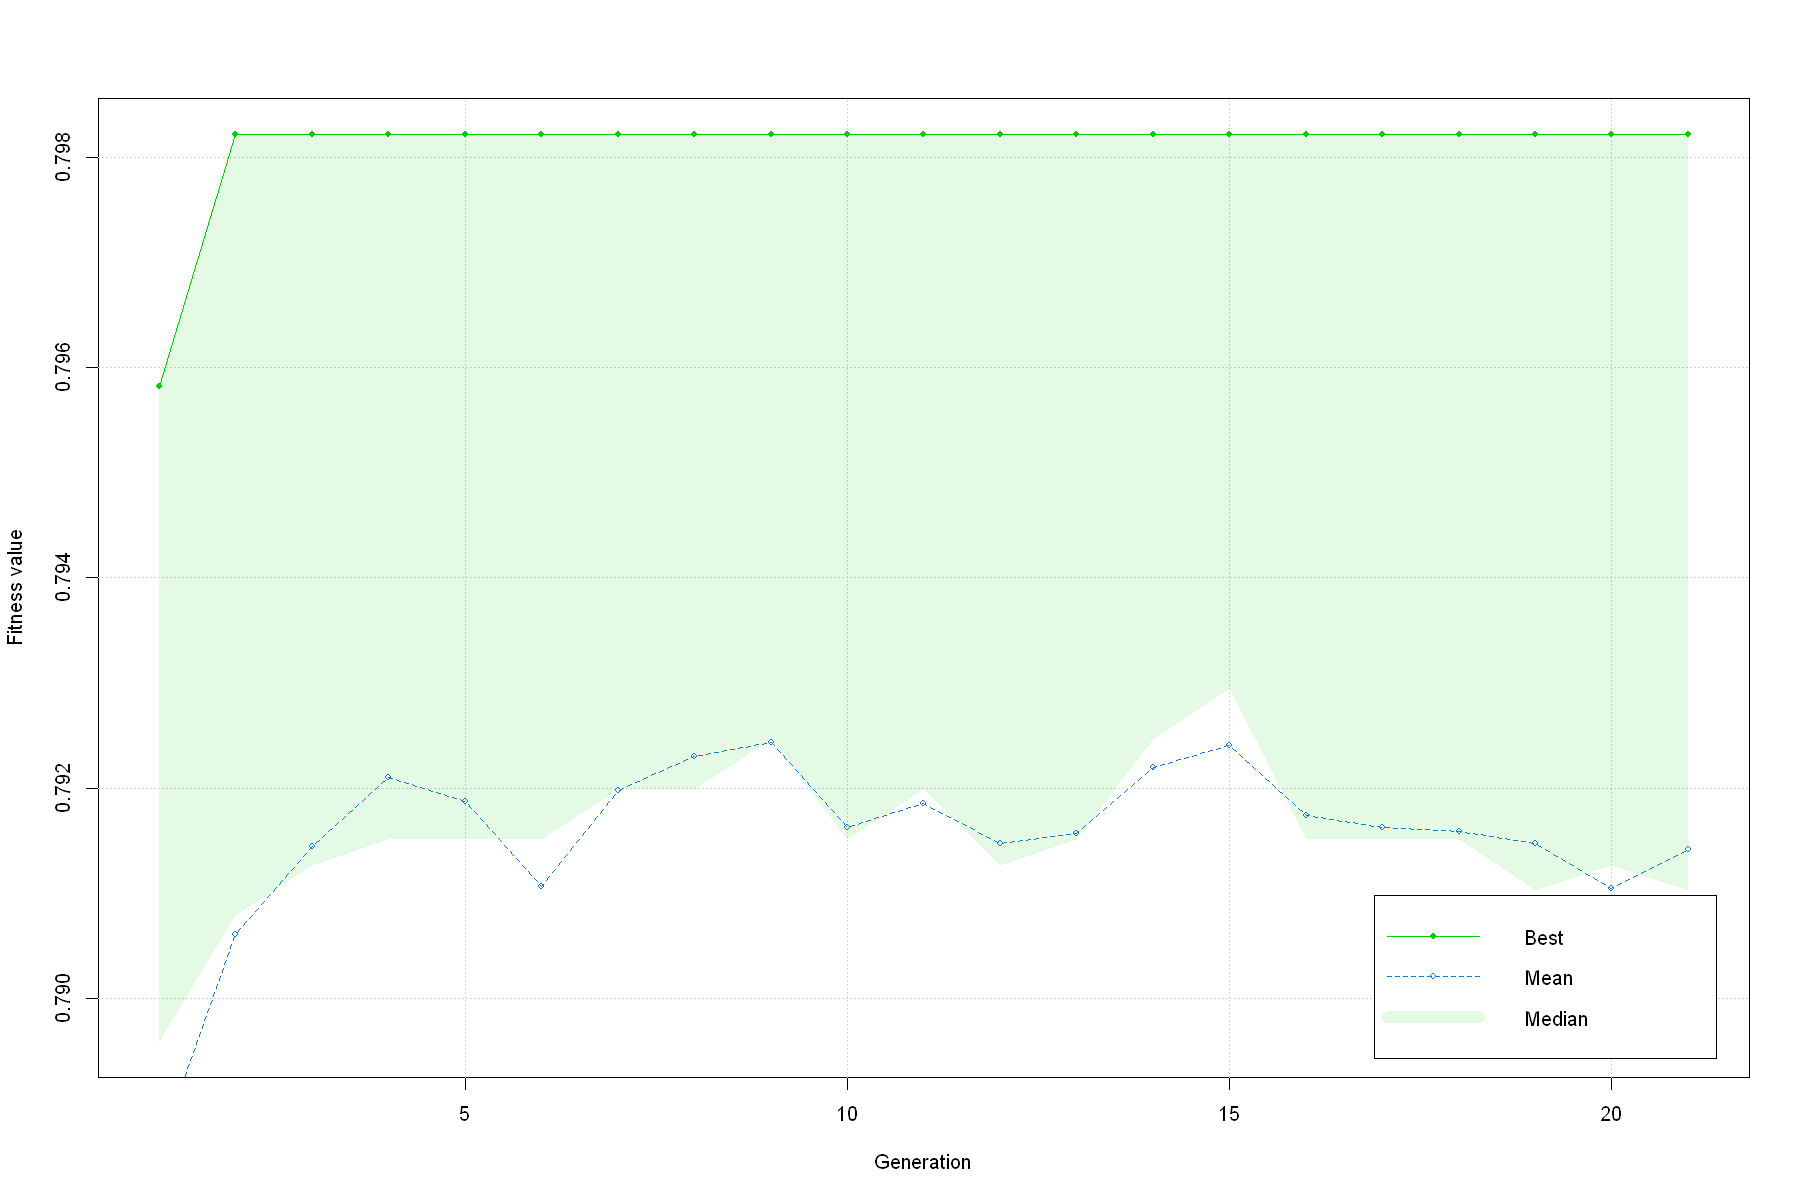

In [5]:
ACC_OOB <- function(k) {
  set.seed(711)
  rf_ab <- randomForest(Rings ~ .,
    data = train_ab, mtry = floor(k[1]), ntree = floor(k[2]), nodesize = floor(k[3]),
    importance = FALSE, proximity = FALSE, localImp = FALSE
  )
  cf <- rf_ab$confusion
  return(sum(diag(cf))/sum(cf))
}

p_load(GA, parallel, doParallel)

GA <- ga(
  parallel = TRUE, seed = 100,
  type = "real-valued", fitness = ACC_OOB, monitor = TRUE,
  lower = c(2, 2, 2), upper = c(ncol(train_ab) - 1, 500, 100),
  popSize = 100, run = 20 # 终止条件--停滞的代数
)

summary(GA)
plot(GA)

In [27]:
cat("参数mtry和ntree、nodesize的优化值分别为：",floor(GA@solution[1]), ",", floor(GA@solution[2]), ",", nodesize = floor(GA@solution[3]))

参数mtry和ntree、nodesize的优化值分别为： 6 , 119 , 38

In [28]:
  set.seed(711)
  (rfo_ab <- randomForest(Rings ~ .,
    data = train_ab, mtry = floor(GA@solution[1]), ntree = floor(GA@solution[2]), nodesize = floor(GA@solution[3])))


Call:
 randomForest(formula = Rings ~ ., data = train_ab, mtry = floor(GA@solution[1]),      ntree = floor(GA@solution[2]), nodesize = floor(GA@solution[3])) 
               Type of random forest: classification
                     Number of trees: 119
No. of variables tried at each split: 6

        OOB estimate of  error rate: 20.16%
Confusion matrix:
    L   H class.error
L 807 237   0.2270115
H 184 860   0.1762452

可见参数mtry和ntree、nodesize综合优化后，“OOB estimate of  error rate”得到进一步降低

In [18]:
#将最优rpart树和随机森林应用于测试集
cto <- prune_se(rpart(Rings ~ ., data = train_ab, method = "class", cp = 0), prune = TRUE, se = 1) 
cat("测试集错判率--rpart树 :",mean(predict(cto, test_ab, type = "class") != test_ab$Rings))    

cat("\n")
cat("测试集错判率--随机森林:",mean(predict(rfo_ab, test_ab) != test_ab$Rings))    

测试集错判率--rpart树 : 0.2202011
测试集错判率--随机森林: 0.2029679

**randomForest怎样分类**

In [1]:
set.seed(71)
(rf_ab <- randomForest(Rings ~ ., data = train_ab, importance = TRUE, proximity = TRUE, localImp = TRUE))

ERROR: Error in randomForest(Rings ~ ., data = train_ab, importance = TRUE, proximity = TRUE, : could not find function "randomForest"


In [27]:
rf_ab$votes    #randomForest函数默认norm.votes=TRUE，返回判别的置信度

,L,H
3786,0.53723404,0.46276596
503,0.05434783,0.94565217
3430,1.00000000,0.00000000
3696,0.13227513,0.86772487
4090,0.67307692,0.32692308
3052,0.27173913,0.72826087
2967,0.21893491,0.78106509
470,0.01648352,0.98351648
1990,1.00000000,0.00000000
1540,0.92485549,0.07514451


In [18]:
margin(rf_ab)   #正确类别的判断置信度将去其他类别的最高置信度

           L            H            L            H            L            L            H            H            L            L 
 0.074468085  0.891304348  1.000000000  0.735449735  0.346153846 -0.456521739  0.562130178  0.967032967  1.000000000  0.849710983 
           L            L            H            L            H            L            L            H            H            H 
 0.684782609  0.656862745  0.590643275 -0.164948454  0.952380952  0.051428571 -0.255555556  0.141242938 -0.534883721  0.420765027 
           L            L            L            H            L            H            L            H            H            L 
 0.028248588  0.113402062  1.000000000  0.588571429 -0.886010363  0.505376344 -0.156069364  0.056179775  0.931818182 -0.606217617 
           L            L            H            H            H            L            H            H            H            L 
-0.634615385  0.786096257  0.790000000 -0.186813187 -0.349112426 -0.175879397  0.70

部分依赖图展示一个特征是怎样影响模型预测，但是如果该特征与其他特征相关，该曲线不准确。

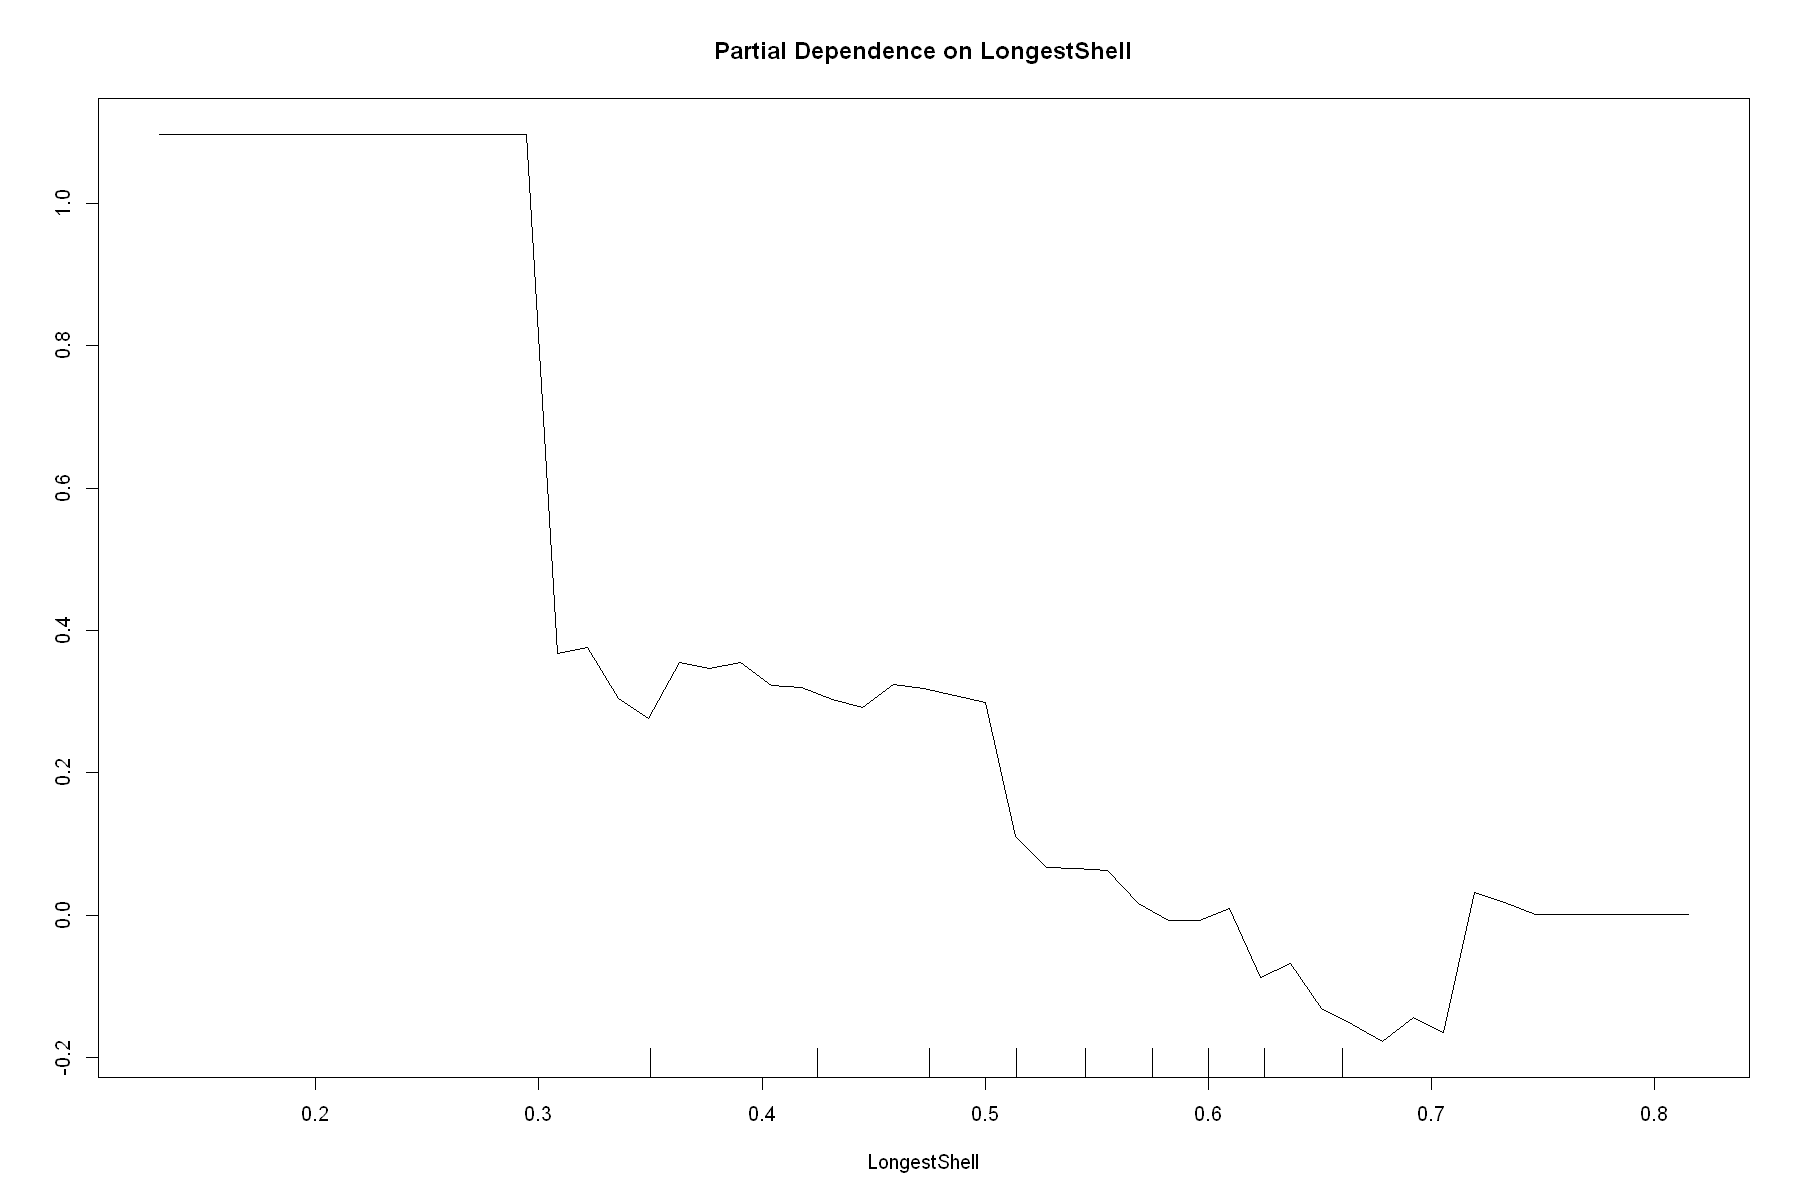

In [29]:
partialPlot(rf_ab, train_ab, LongestShell)
#varImpPlot与其他自变量之间如果相关，则

多维尺度变换(multidimensional scaling, MDS)是在低维空间去展示高维多元数据的一种可视化方法，基本目标是将原始数据“拟合”到一个低维坐标系中，使得由降维所引起的任何变形最小：当n个项目中各对项目之间的相似性(或距离)给定时，求这些项目在低维空间的表示，并使得项目间的接近程度与原先的相似性(或距离) “大体匹配”。

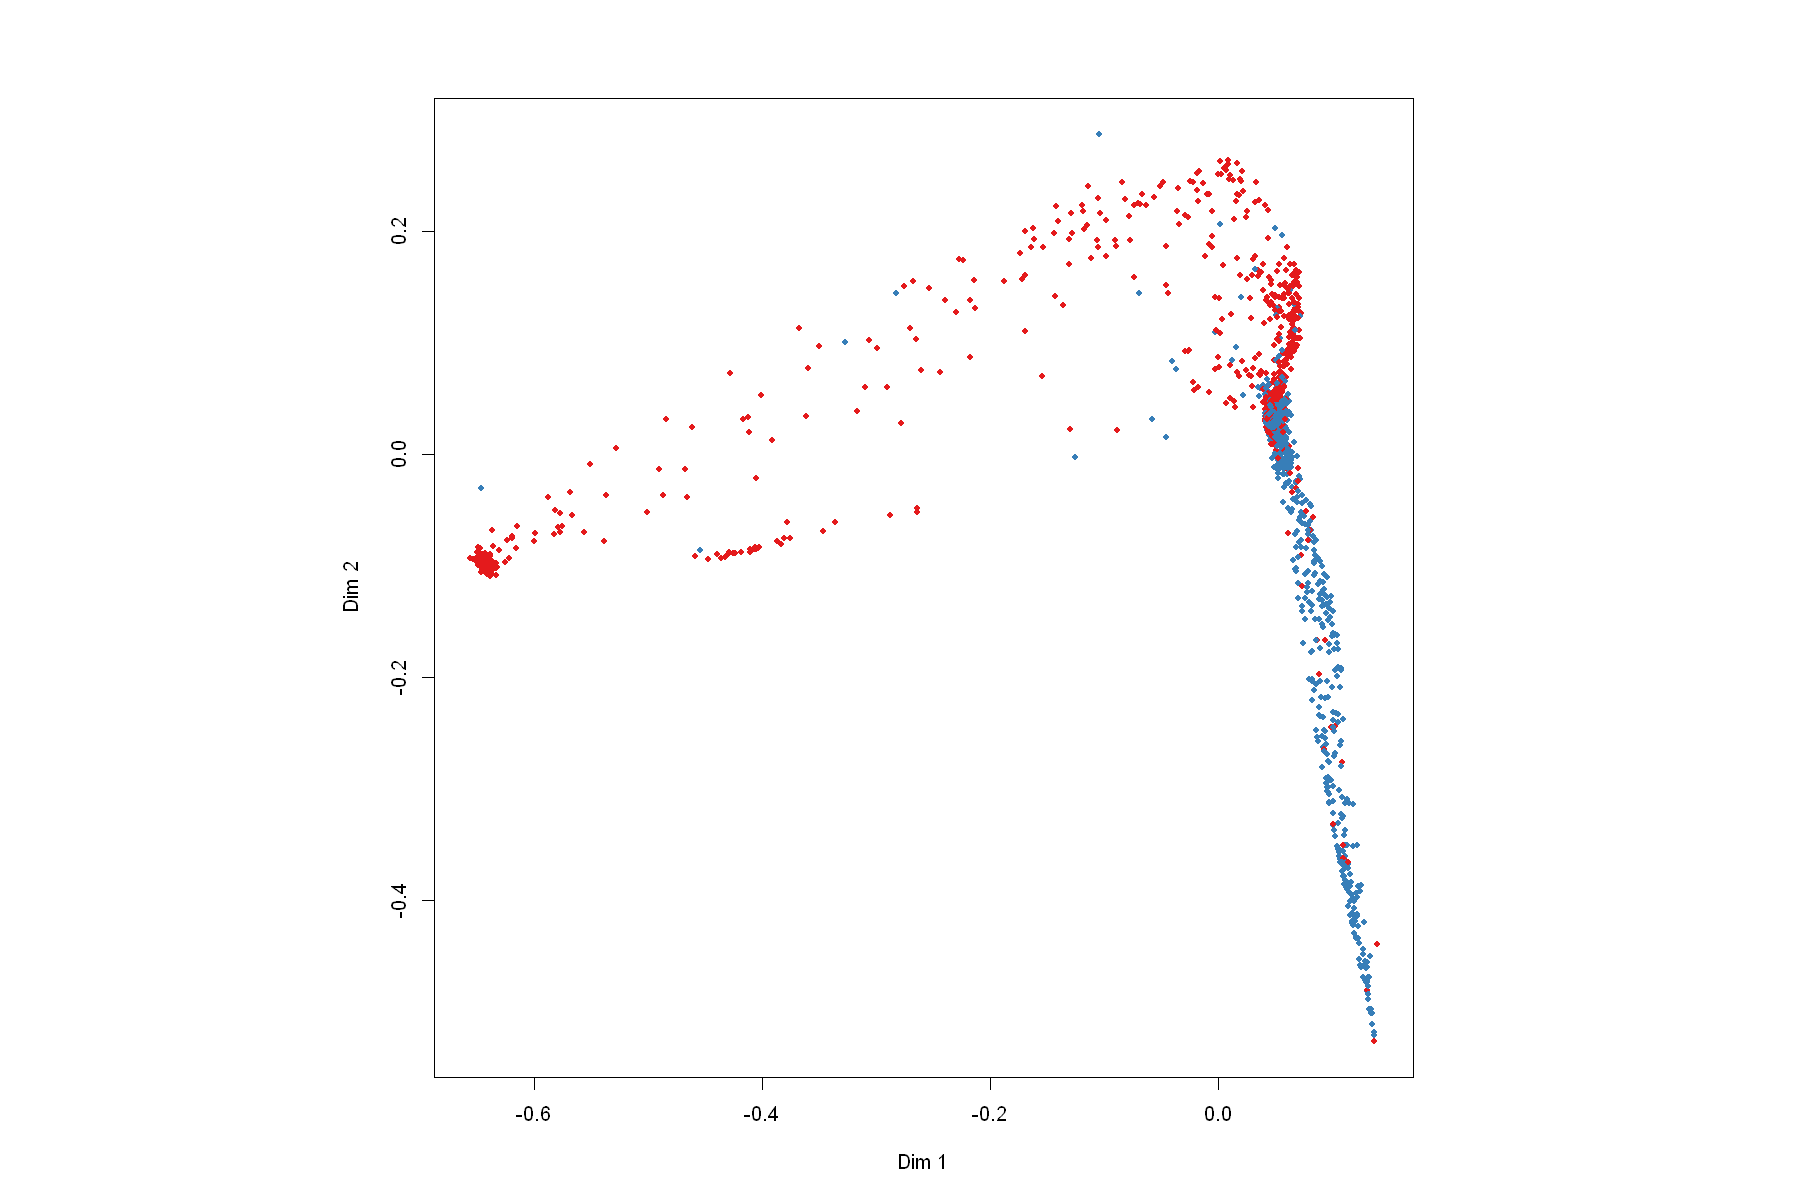

In [22]:
#拟合到二维空间
MDSplot(rf_ab, k=2, train_ab$Rings)

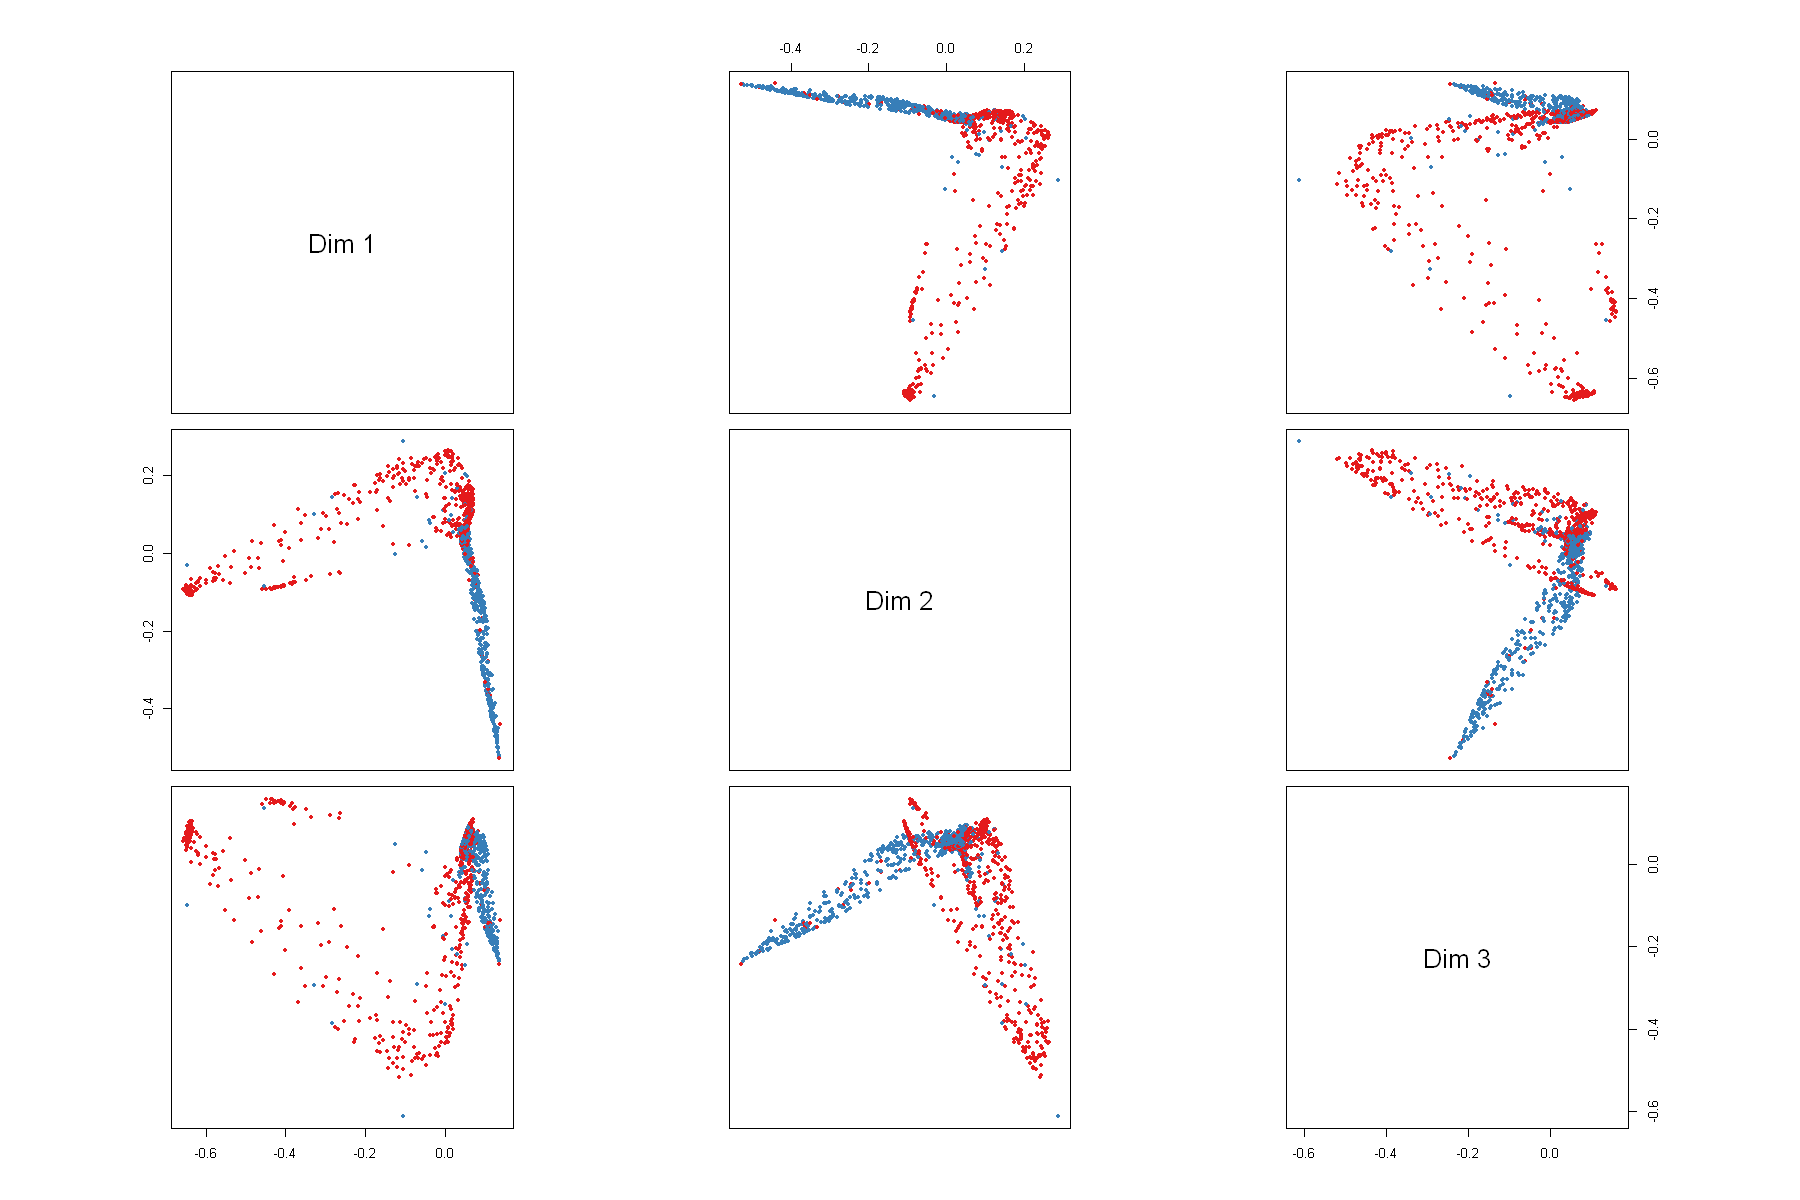

In [21]:
#拟合到三维空间
MDSplot(rf_ab, k=3, train_ab$Rings)

In [30]:
set.seed(71)
rf_ab <- randomForest(Rings ~ ., data = train_ab, importance = TRUE, proximity = TRUE, localImp = TRUE, norm.votes = FALSE)
rf_ab$votes      #norm.votes=FALSE时返回返回判定为这个类别的次数，每行的总和为该样例为OOB的次数

,L,H
3786,101,87
503,10,174
3430,176,0
3696,25,164
4090,105,51
3052,50,134
2967,37,132
470,3,179
1990,177,0
1540,160,13


以上矩阵说明了所有样例是怎样判别的，例如对于最后一行：

样例1082，共有178+16棵树参与OOB判别，其中178棵将其判定为“L”，16棵树将其判别为“H”，所以其将其判定为“L”和“H”的置信度分别为：

178/(178+16)=0.91752577、16/(178+16)=0.08247423

当norm.votes取默认值TRUE时，返回以上置信度

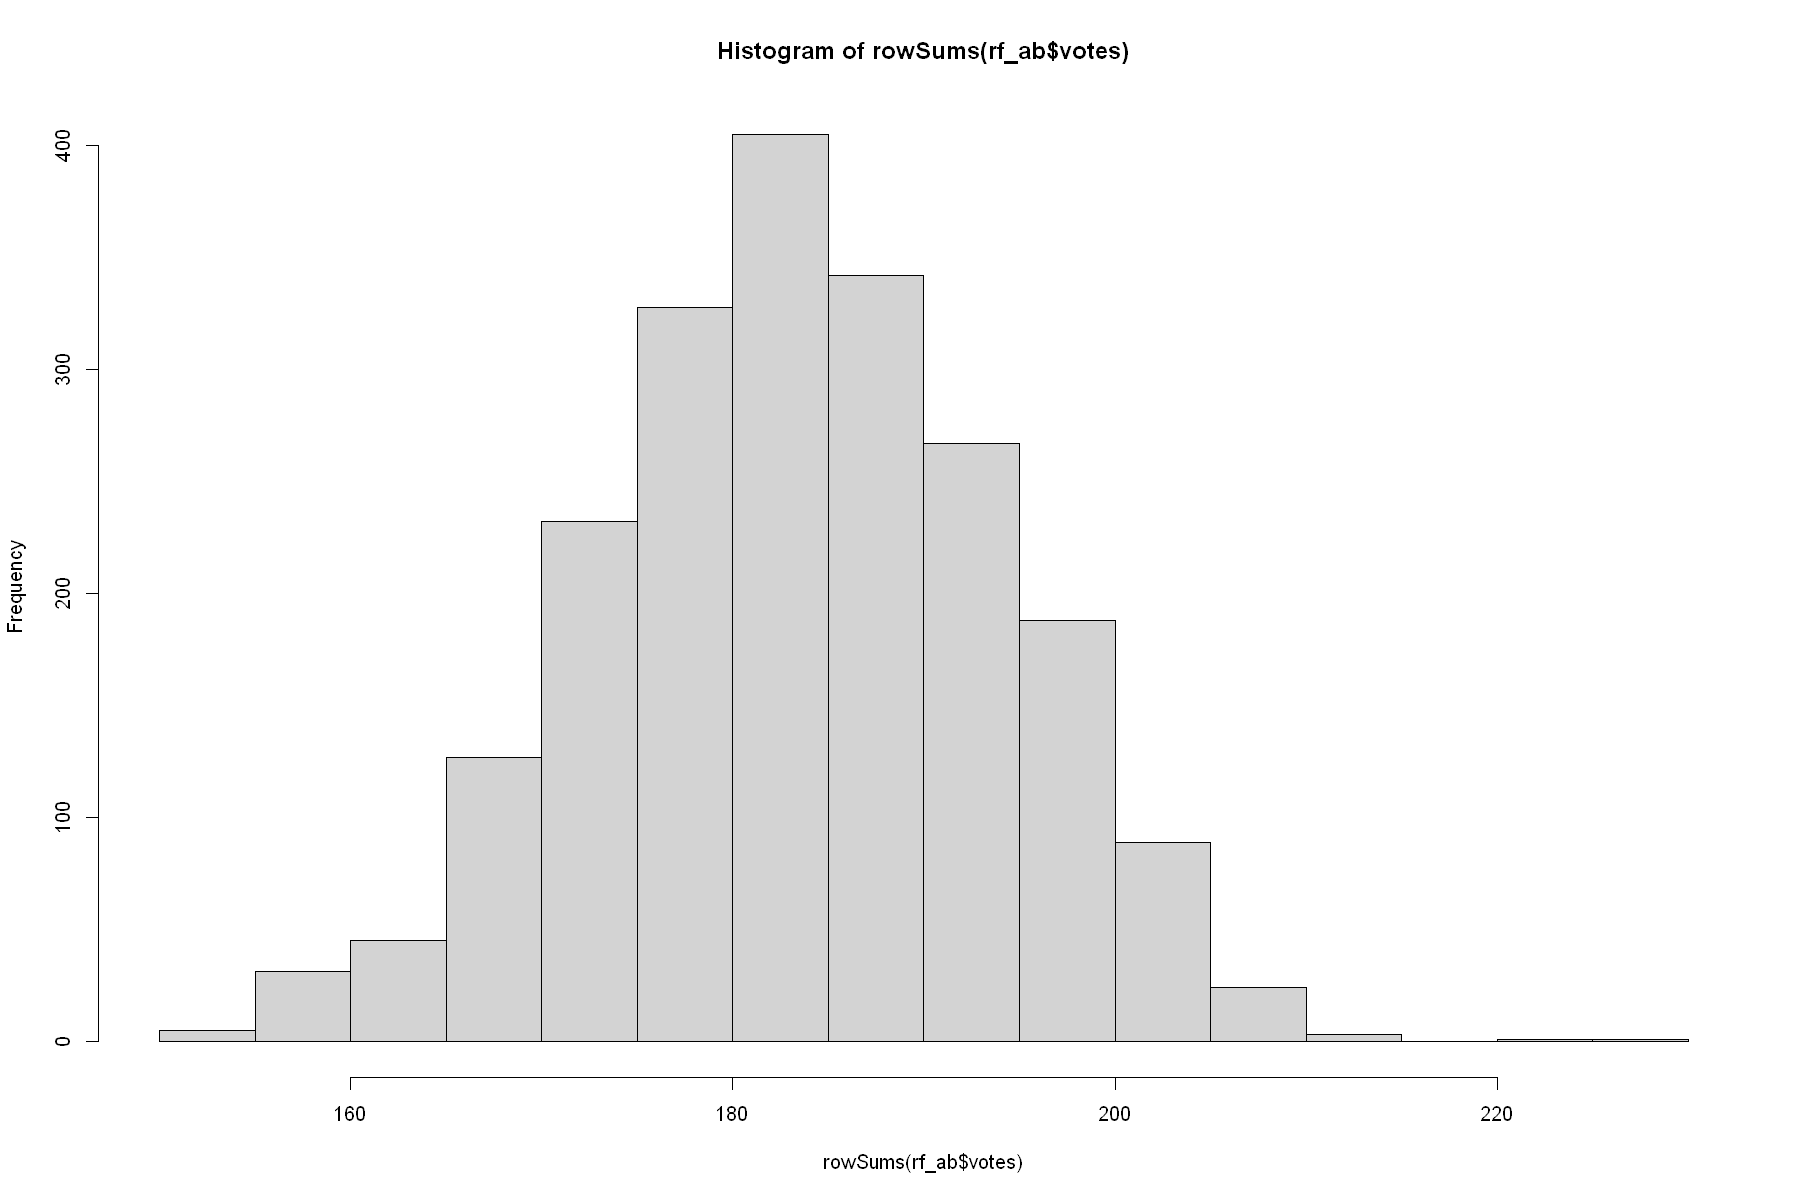

In [32]:
#OOB的次数的分布：由于随机性，每个样例OOB的次数不同
hist(rowSums(rf_ab$votes))  

In [33]:
sum(rf_ab$votes)/(nrow(train_ab)*500)  #样例未被抽中(OOB)的概率
#接近1/e=0.3678794

[1] 0.3680096

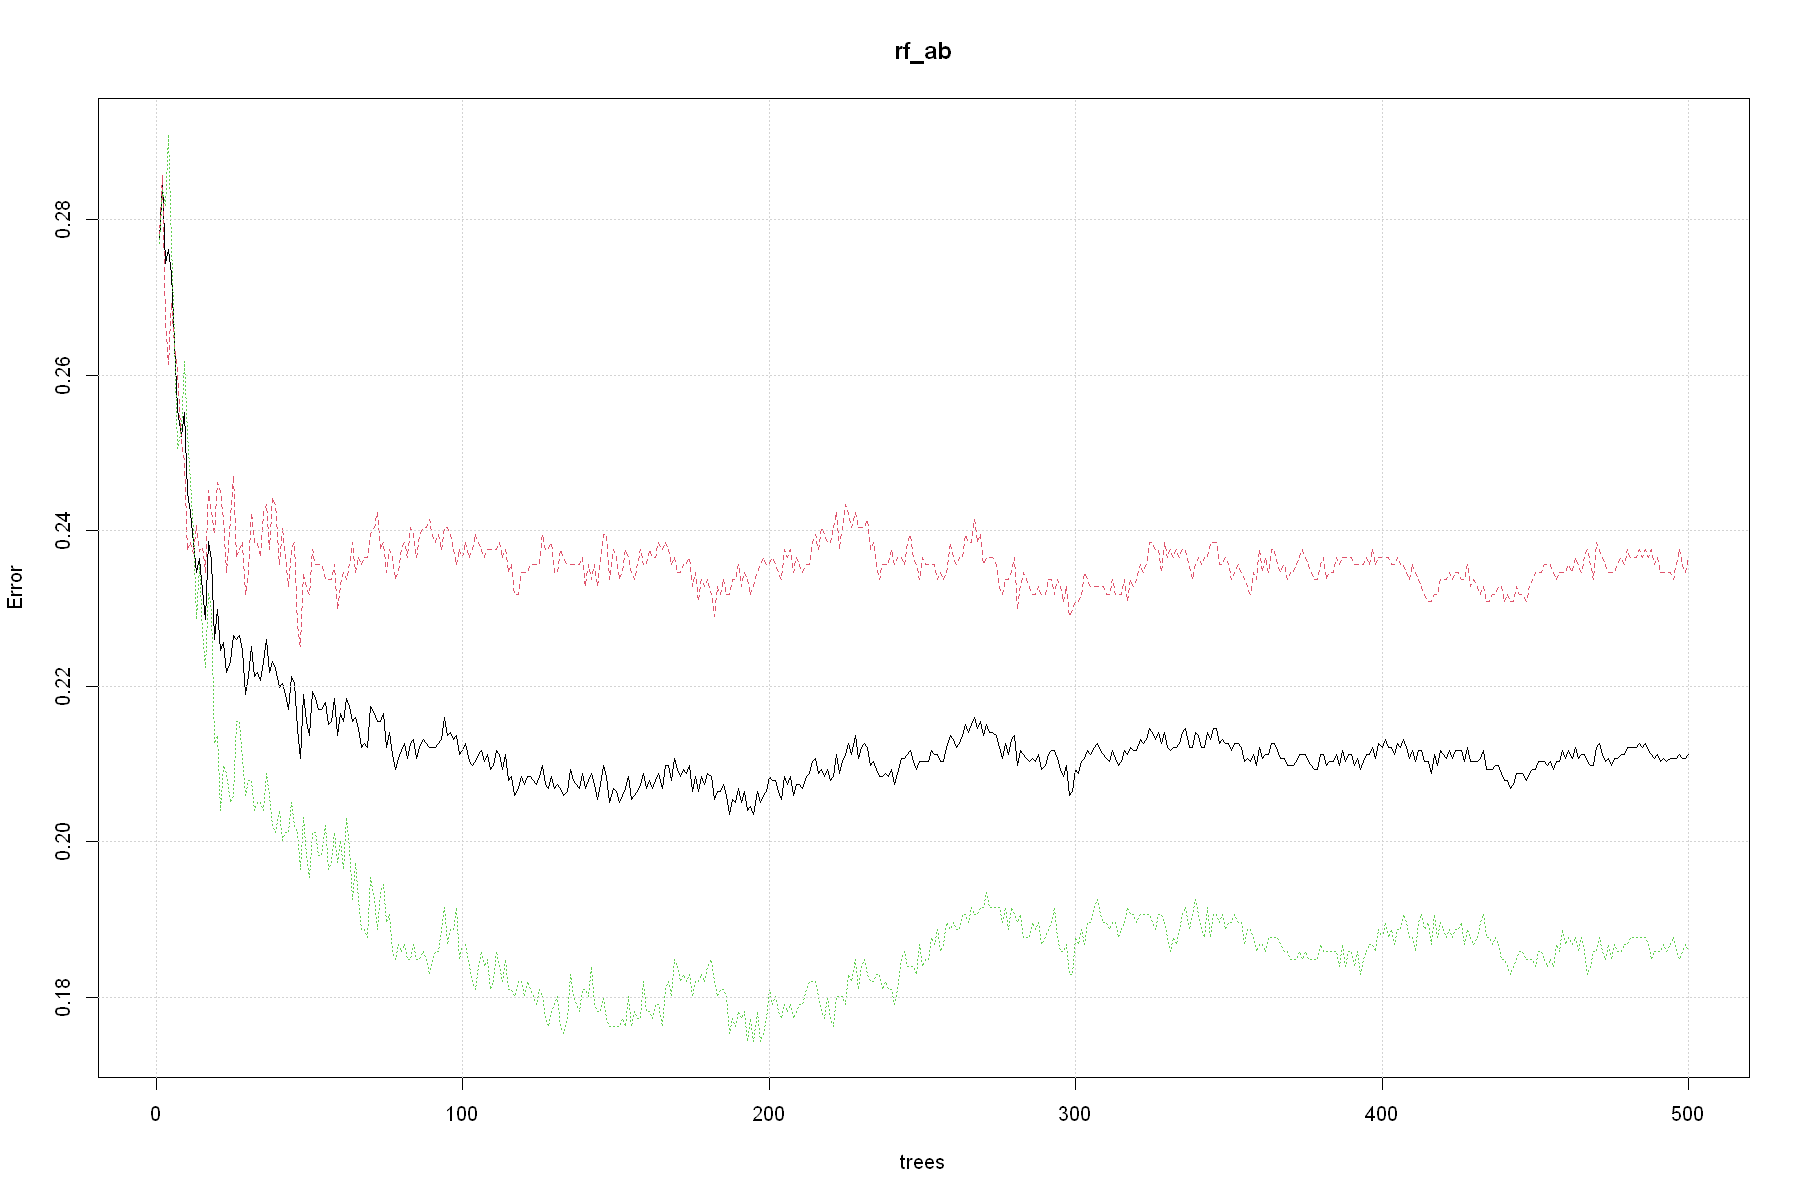

In [35]:
#随着树的增多而收敛,上下曲线对应着二个类别的错判率，中间曲线是二者的平均值。
plot(rf_ab)
grid()

**自变量重要性**

In [5]:
# 均值
(vip <- rf_ab$importance)

,L,H,MeanDecreaseAccuracy,MeanDecreaseGini
Type,0.05109195,-0.00201377,0.02454991,55.92147
LongestShell,0.01435879,0.08444461,0.04936059,96.76342
Diameter,0.04407903,0.07211814,0.05806831,107.80486
Height,0.06209716,0.03518508,0.04866492,123.38790
WholeWeight,0.07230998,0.08572504,0.07864012,165.25709
ShuckedWeight,0.02650611,0.01238793,0.01947048,130.81325
VisceraWeight,0.08980087,0.04334280,0.06659787,159.58721
ShellWeight,0.10296826,0.07077527,0.08681081,202.41993


- MeanDecreaseAccuracy--打乱该变量值在数据集中的排列顺序前后构建随机森林的Accuracy的差的均值：假设这个变量无用(对于目标变量毫无提示作用)，那么打乱这列变量值的排列顺序，不影响最终的Accuracy，如果打乱后所有样例的Accuracy均值下降大，则说明此变量重要。
- MeanDecreaseGini--使用该变量导致的Gini值下降幅度的均值：若该变量重要则其在所有决策树中的Gini下降值应该大。

In [38]:
# 标准差
rf_ab$importanceSD

,L,H,MeanDecreaseAccuracy
Type,0.001132856,0.0007142107,0.0006449222
LongestShell,0.003084423,0.0034134715,0.0020052336
Diameter,0.003521536,0.0032892424,0.0021176610
Height,0.003044894,0.0027456067,0.0018337165
WholeWeight,0.005009154,0.0042522952,0.0028185668
ShuckedWeight,0.001613947,0.0016362821,0.0009030033
VisceraWeight,0.004713276,0.0035459227,0.0025869003
ShellWeight,0.004021245,0.0030553160,0.0021782660


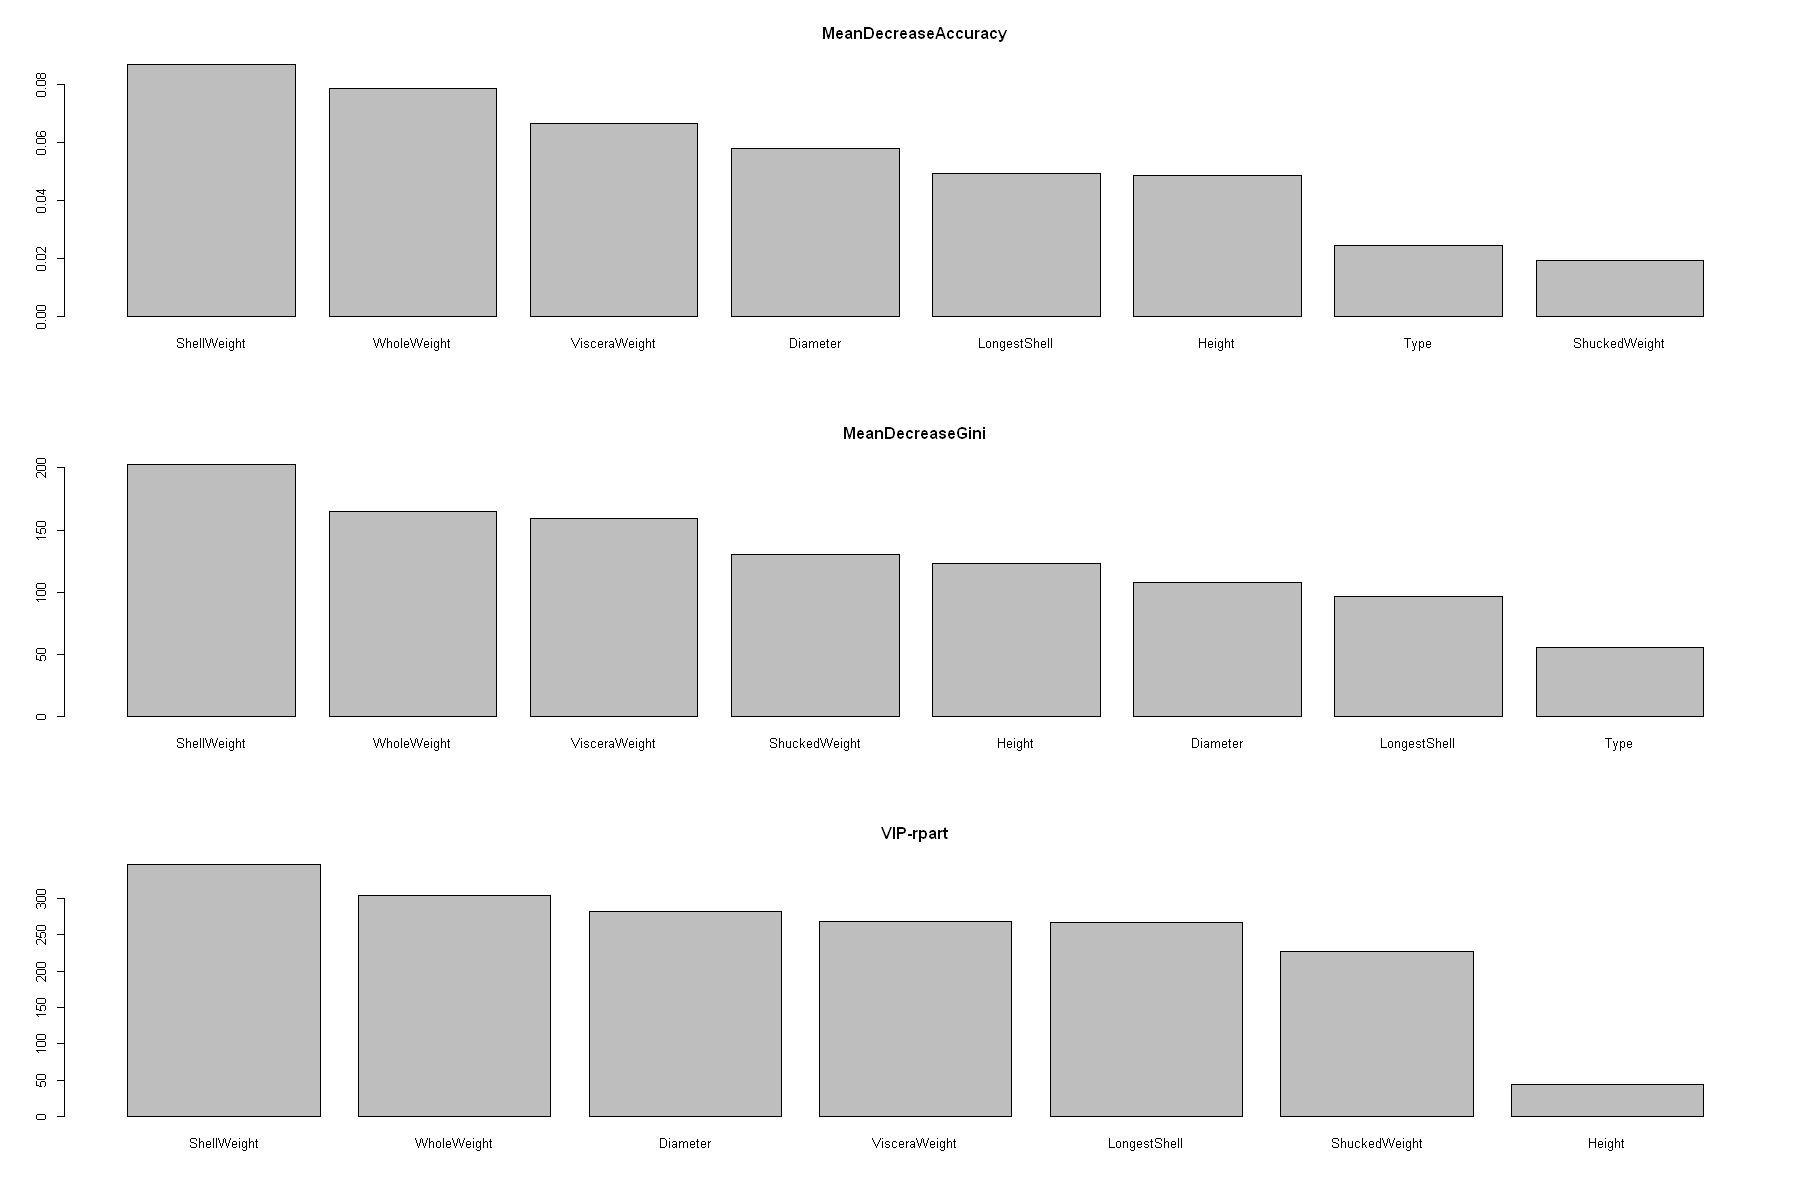

In [39]:
# 变量重要性降序排列
cto <- prune_se(rpart(Rings ~ ., data = train_ab, method = "class", cp = 0), prune = TRUE, se = 1) 

par(mfrow = c(3,1))
barplot(sort(vip[, "MeanDecreaseAccuracy"], decreasing = TRUE), main = "MeanDecreaseAccuracy")
barplot(sort(vip[, "MeanDecreaseGini"], decreasing = TRUE), main = "MeanDecreaseGini")
barplot(cto$variable.importance, main = "VIP-rpart")    #最优rpart决策树的变量重要性降序排列

#可见三者不尽相同--评价的标准不同

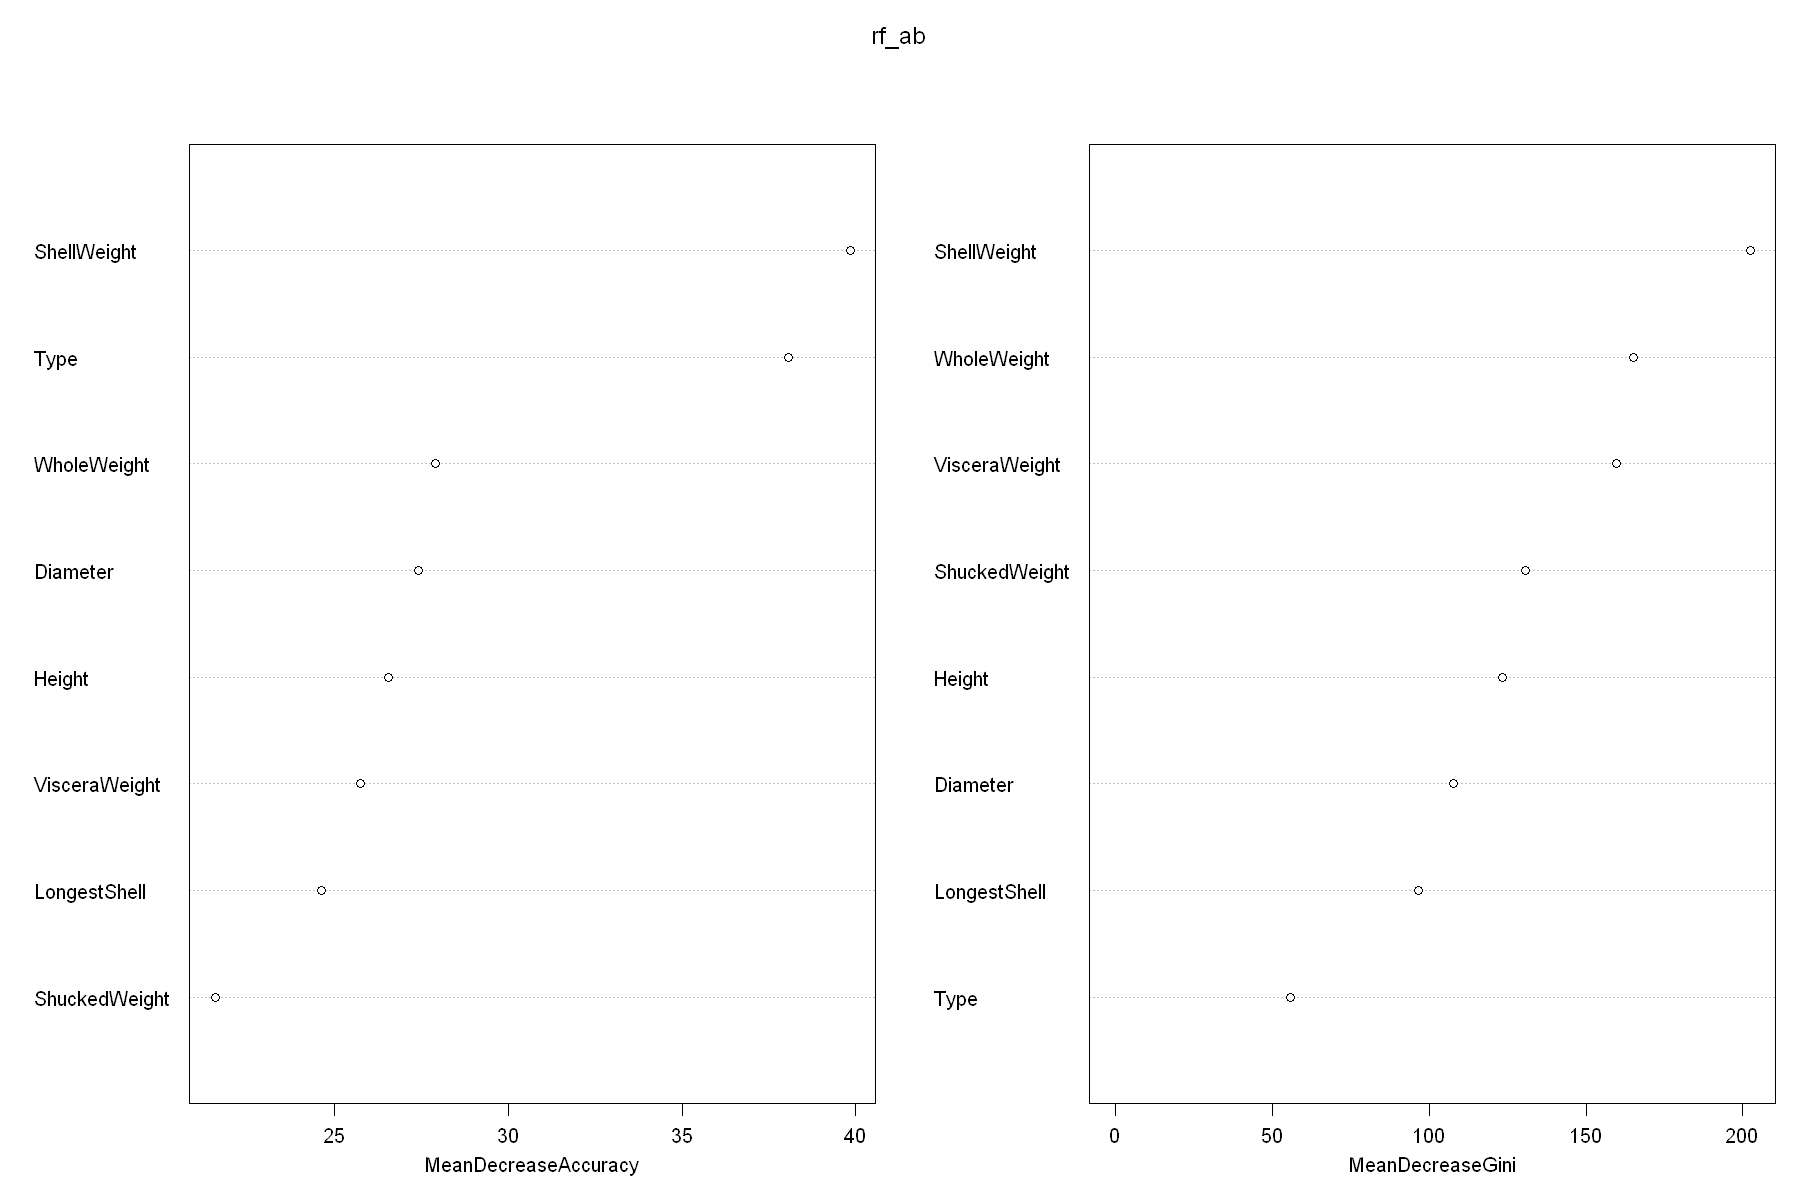

In [6]:
#变量重要性排序点状图
varImpPlot(rf_ab)

In [41]:
# casewise importance measure--当该变量值随机打乱时，该样例被误判的增加率平均值。负值表明该变量不重要
rf_ab$localImportance

,3786,503,3430,3696,4090,3052,2967,470,1990,1540,⋯,2083,1553,1949,554,1113,2591,622,1191,3936,1082
Type,0.09042553,0.01086957,0.00000000,-0.01587302,0.051282051,0.00000000,0.00591716,0.00000000,0.01694915,0.00000000,⋯,0.00000000,0.09139785,0.00000000,-0.16847826,0.00000000,0.01176471,-0.158730159,-0.005235602,0.016853933,0.005154639
LongestShell,-0.01595745,0.08152174,0.04545455,0.14814815,-0.057692308,-0.05978261,0.17751479,0.10989011,0.05084746,0.01734104,⋯,0.14432990,0.09677419,0.16915423,0.05978261,0.02577320,-0.05294118,0.058201058,-0.214659686,0.078651685,0.051546392
Diameter,0.05319149,0.05434783,0.14772727,0.20105820,0.032051282,-0.03804348,0.24260355,0.15384615,0.19774011,0.01156069,⋯,0.19587629,0.06989247,0.18407960,0.03804348,0.11340206,0.08823529,0.068783069,-0.319371728,0.112359551,0.010309278
Height,0.09042553,0.04347826,0.07954545,0.13227513,0.044871795,0.05434783,-0.01183432,0.03846154,0.11299435,0.09248555,⋯,0.09278351,0.08064516,0.20398010,0.07065217,0.11340206,0.05294118,0.005291005,-0.073298429,0.033707865,0.273195876
WholeWeight,0.04787234,0.16847826,0.16477273,0.08994709,-0.006410256,-0.14673913,0.10650888,0.15384615,0.18644068,0.19075145,⋯,0.21134021,0.13978495,0.19900498,-0.06521739,0.06701031,0.05882353,0.095238095,-0.089005236,0.095505618,0.134020619
ShuckedWeight,0.20744681,0.10869565,0.01136364,-0.04761905,0.237179487,-0.03804348,-0.10059172,0.01648352,0.00000000,-0.01734104,⋯,-0.06185567,0.02150538,0.08457711,0.14130435,0.33505155,0.07058824,0.116402116,0.073298429,0.196629213,0.020618557
VisceraWeight,0.09574468,0.05978261,0.10795455,0.13756614,0.102564103,-0.07065217,0.14201183,0.15934066,0.10169492,0.10404624,⋯,0.13402062,0.23118280,0.18905473,-0.07608696,0.19072165,-0.02352941,-0.089947090,-0.026178010,-0.005617978,0.149484536
ShellWeight,0.08510638,0.22282609,0.11931818,0.16402116,0.000000000,-0.05978261,0.00000000,0.21428571,0.14124294,0.16763006,⋯,0.19072165,0.20967742,0.14427861,0.07065217,0.16494845,0.15294118,-0.068783069,-0.020942408,0.123595506,0.221649485


In [44]:
#每颗树的袋外判错率
rf_ab$err.rate

OOB,L,H
0.2774275,0.2779156,0.2769231
0.2848051,0.2857143,0.2838915
0.2743590,0.2668394,0.2817259
0.2761959,0.2614155,0.2909091
0.2731183,0.2693133,0.2769397
0.2641316,0.2638037,0.2644628
0.2555221,0.2605210,0.2505030
0.2521008,0.2512315,0.2529762
0.2552465,0.2487805,0.2617188
0.2448980,0.2374031,0.2524366


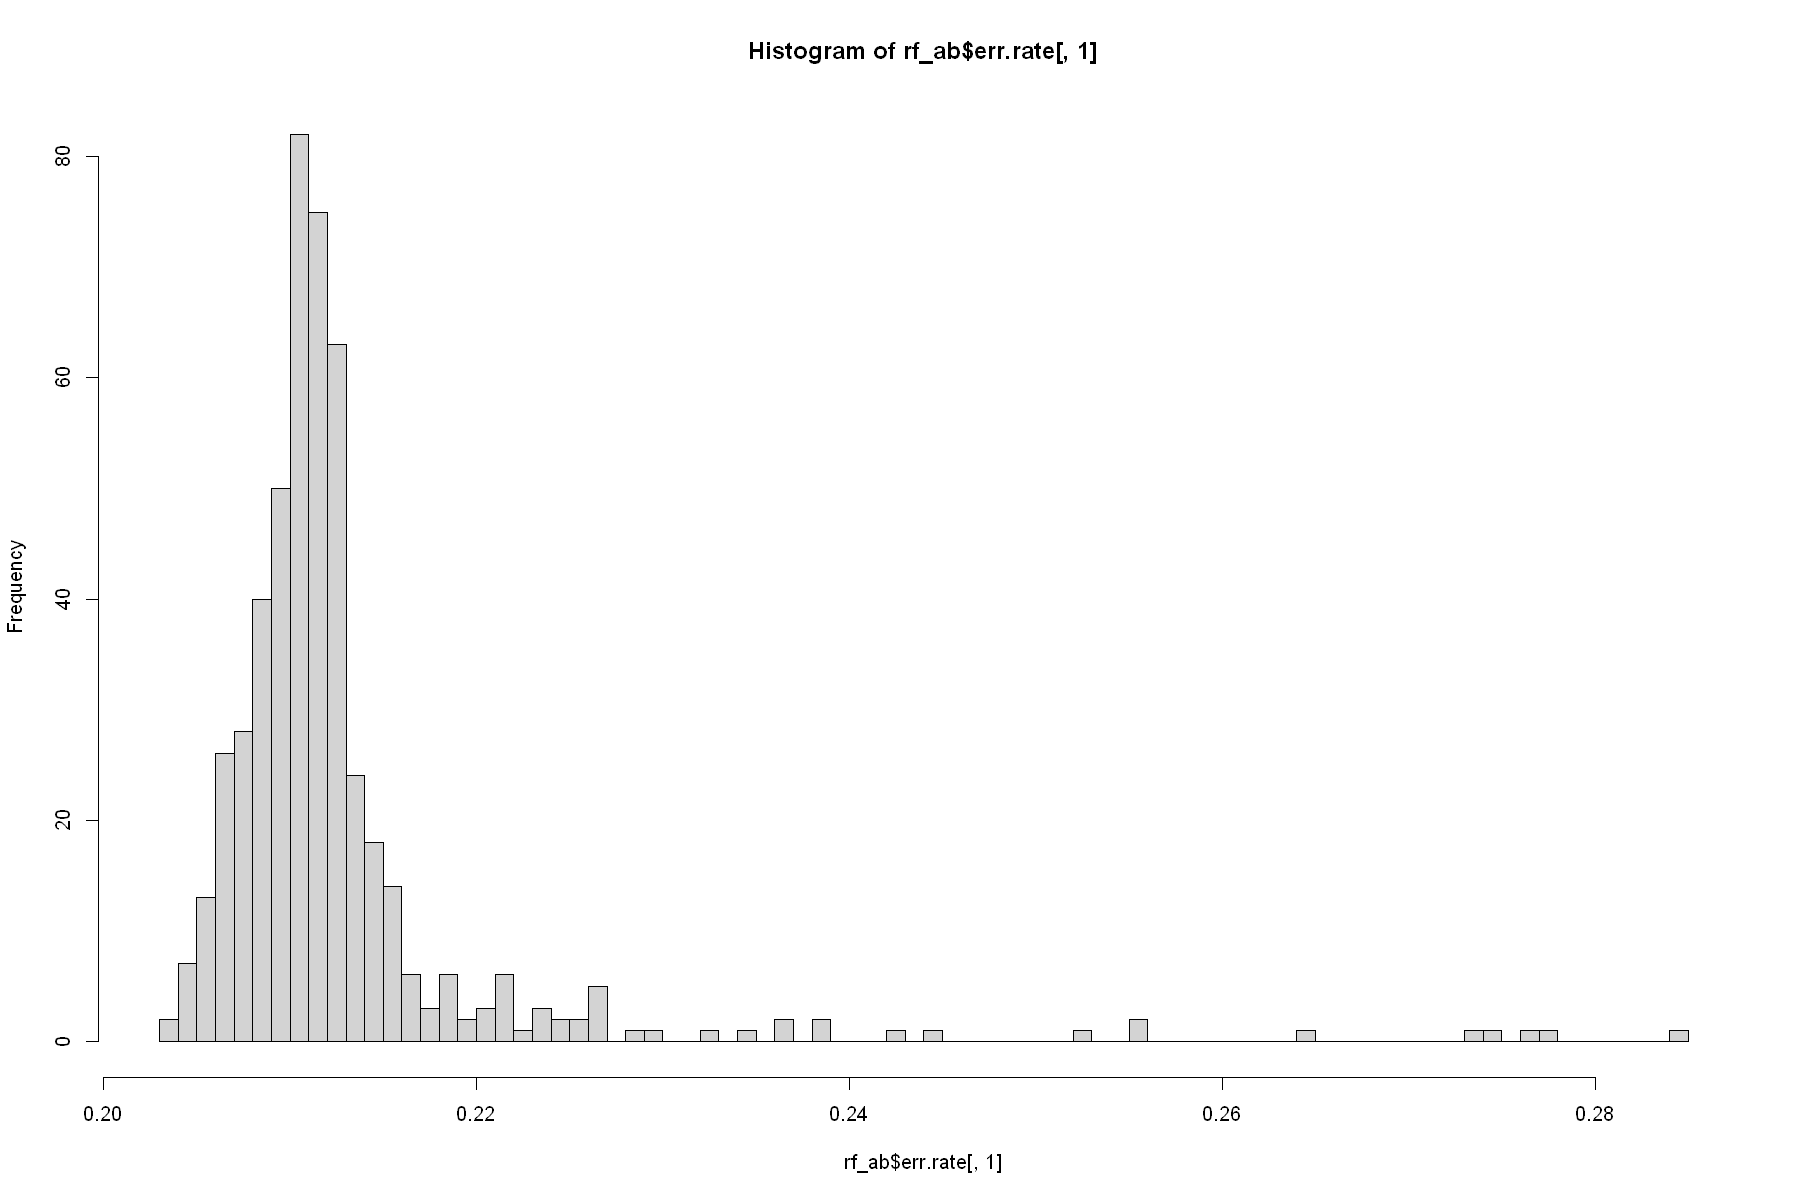

In [47]:
#每颗树的袋外判错率的直方图
hist(rf_ab$err.rate[,1],100) 

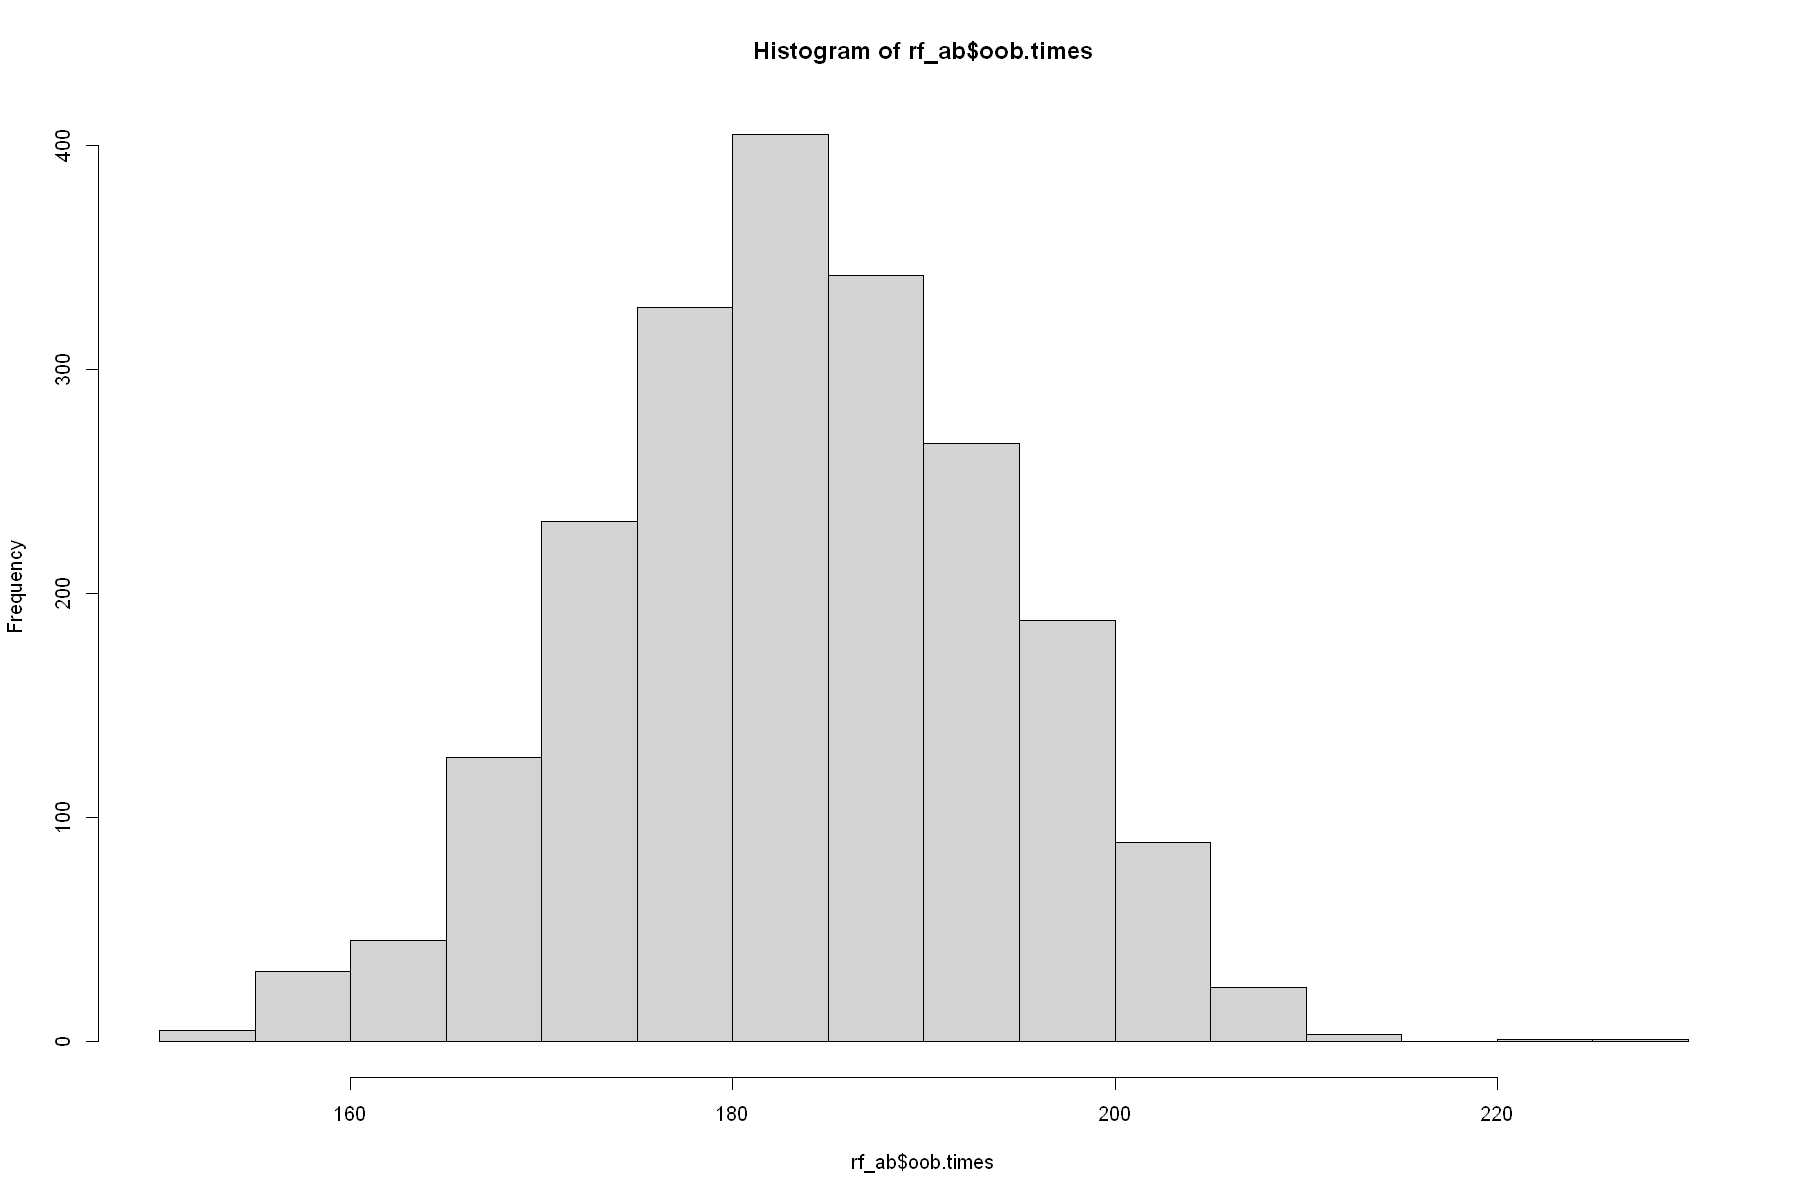

In [48]:
#每个样例处于OOB的次数
hist(rf_ab$oob.times) 

In [49]:
#训练集的预测值
rf_ab$predicted

3786  503 3430 3696 4090 3052 2967  470 1990 1540  823 2886 2347 2514 2956 3043 1331  456 3218 1817 3507  948 3632  288  347 1808 4169  605 
   L    H    L    H    L    H    H    H    L    L    L    L    H    H    H    L    H    H    L    H    L    L    L    H    H    H    H    H 
3742 1631  223 1449 3369 2441 2411 1624 2931 2478 3326 2095 2060  947 1145   16 1976 1430  949 2691 3925  757 2329 3727 2469 2714 1420 1161 
   H    H    H    L    H    L    L    H    H    H    H    L    L    L    L    H    H    L    L    H    H    H    H    H    L    L    H    H 
1867 3386 1061 2779  328 3163 1218 2195 2842 1285  334 3368  879 2897 2496 1247 2384 2470 1752  723 4081 2762 2828 1837 2538 1988 3172 3273 
   L    L    L    L    H    H    L    L    H    H    L    H    H    L    H    L    H    H    H    H    L    L    L    L    H    L    H    H 
3994 2331 3999 2990 3143 1685 3623 4073  988 1729 2320 3154 3720 2442 3781 2519 4149 1234 2529  711  458  177 3300 3202  651 3054 4138  114 
   H    L    L    L    L    H    H    L    L    H    H    L    L    H    H    L    H    L    H    L    L    L    H    L    L    H    H    L 
2049 4100 2848  457 1149 3705 1293 2366  395  100 2490  910 1274 2218  916  576 3791 3087 3348 3762 2176 3821 1583 3255  402  894  614 1497 
   L    H    L    H    L    H    L    H    L    L    L    L    L    H    L    H    H    L    L    L    H    H    L    L    H    L    L    H 
2101 1876 2571 1229 1942 1623 2356 2688 4007 1951 3406 1253  972 3886 2009 2277  448  492 3579 2707 1675 1996  660 2890  302 2386  668 1552 
   L    H    L    L    L    H    H    H    L    H    L    L    L    L    L    H    H    H    H    H    H    L    H    L    H    L    H    L 
2373 1159 3025 3768  165 3444 3319 2888 3047 3018 3333  852 1900 1491 1070  116 3604 3794  824 2497  804  506  806 1208 1579 3467  573 2451 
   L    L    L    H    H    L    L    L    H    L    H    L    L    H    L    L    L    H    L    H    L    H    L    H    L    H    H    L 
 630 3498 2574 2431 1850  878 3587 3627 2524 3464 1978 2380 4015 3639  209 1139 3865 1515 4155 2730 2352 4087 1244 1920  703 1543 3625 3582 
   L    L    L    L    H    H    H    H    L    H    H    L    H    L    H    L    L    H    L    L    L    L    L    H    L    L    H    H 
3835 2399 1043 4072 2402  945 4070 1661 4164 3766   56 1164 1407 3364  905 3201   87 1135  397 1719 2859 4145 1351 2667   76 1349 3013  981 
   L    L    H    L    H    L    L    L    L    H    H    L    H    L    L    H    H    L    L    H    H    H    L    L    H    H    L    L 
2621 2768 1485 3296 3110 1398 2952 3757 2285 2146 3235 3789 3293  903 2946 1639  695 1257 1663 2872  585 1199  904  923 1052 1036 2155 1021 
   H    L    L    L    L    H    H    L    L    H    H    H    H    L    H    H    L    L    L    L    L    H    L    L    H    H    H    H 
1703  644 1143 1835 1320  752 2194 1649 1383 1242  324  401  120  755  909 3427 2000 3095  737 4158 3157    2 3478 3931  568 2316 2177 1106 
   H    L    L    L    L    L    L    H    H    L    L    L    L    H    L    H    L    H    H    H    H    L    L    H    L    H    H    L 
1869  946 2437 3496 2008 1727   83 1313  340 1513 1154  735 4110 1918  656 3712 2414 1971 1045 3699 3706 2450 2733 2295 1038 1633 2605  133 
   L    L    H    L    L    H    H    H    H    H    L    H    L    H    L    H    H    H    H    H    H    L    L    L    H    H    H    L 
3443 3472 1394  697 3098 4005 2689 2235 3394  997 1198 3304 1941 3421 3269 4031  592 1617 2644 3004 2079 2801 2934  488 2729 3588  262 3581 
   L    H    H    L    H    L    L    H    H    L    H    H    H    H    L    L    L    L    L    H    H    H    H    H    L    H    H    H 
3151 3881  898 2336 1896 3349 3770  213 2677 2061 1297 3353 1100 1327 3402 3690 3539  849  537 1307 3035 1162 2746 1141 1350  248 4077 3719 
   H    L    L    H    H    L    L    H    H    L    L    H    L    H    H    H    L    H    L    L    H    L    L    H    H    L    H    L 
3916 3648 3668 1784 4115  214 1495 1447 1498  783   

In [50]:
rf_ab$proximity   #出现在同一叶节点的比率：AB样例在同一叶节点的次数/AB分别参与构建树的次数之和--可以用以衡量样例间的相似性

,3786,503,3430,3696,4090,3052,2967,470,1990,1540,⋯,2083,1553,1949,554,1113,2591,622,1191,3936,1082
3786,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.08045977,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
503,0.00000000,1.00000000,0.00000000,0.03947368,0.00000000,0.00000000,0.00000000,0.01282051,0.00000000,0.00000000,⋯,0.01562500,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3430,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.09836066,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3696,0.00000000,0.03947368,0.00000000,1.00000000,0.00000000,0.00000000,0.08333333,0.25714286,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.10000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02985075,0.00000000,0.00000000
4090,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.01449275,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3052,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01562500,0.00000000,0.00000000,0.00000000,0.00000000
2967,0.00000000,0.00000000,0.00000000,0.08333333,0.00000000,0.00000000,1.00000000,0.10000000,0.00000000,0.00000000,⋯,0.03174603,0.00000000,0.06060606,0.00000000,0.00000000,0.00000000,0.00000000,0.28985507,0.00000000,0.00000000
470,0.00000000,0.01282051,0.00000000,0.25714286,0.00000000,0.00000000,0.10000000,1.00000000,0.00000000,0.00000000,⋯,0.09090909,0.00000000,0.03614458,0.00000000,0.00000000,0.00000000,0.00000000,0.01492537,0.00000000,0.00000000
1990,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.07462687,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1540,0.00000000,0.00000000,0.09836066,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.07462687,1.00000000,⋯,0.00000000,0.06153846,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


**对于测试集的预测**

In [10]:
predict(rf_ab, test_ab, type="response")    #type="response"返回预测值--向量

3    7    8    9   10   12   13   14   15   17   19   20   21   22   24   27   28   29   32   34   35   36   37   38   39   40   41   43 
   H    H    H    H    H    L    H    H    L    L    L    L    L    L    L    H    H    H    H    H    H    L    H    L    H    L    L    L 
  45   46   47   48   49   52   54   57   58   60   61   64   66   67   69   70   73   74   79   80   81   84   85   88   89   91   93   94 
   L    L    L    L    L    L    L    L    L    H    L    L    L    H    H    L    H    H    H    H    H    H    H    H    H    H    H    H 
  96   97   98  101  104  107  108  109  111  112  115  117  118  119  121  122  123  126  128  132  134  135  137  138  139  140  141  143 
   H    H    H    L    H    H    H    H    L    H    H    H    L    H    L    L    H    L    L    L    L    L    L    L    H    L    H    H 
 147  148  149  150  151  153  155  157  159  160  162  164  167  168  170  171  172  173  174  176  178  179  180  181  183  184  185  187 
   L    L    L    L    H    H    H    H    H    H    H    H    H    H    H    H    H    L    H    L    L    L    H    H    H    H    H    H 
 188  189  190  191  193  194  195  196  199  201  203  205  206  210  215  216  217  218  220  221  225  228  229  231  232  233  234  235 
   H    H    H    H    H    L    L    L    L    L    H    L    H    L    H    H    L    L    L    H    L    L    H    H    H    H    L    L 
 236  237  238  239  243  249  251  252  254  257  258  263  265  266  267  268  270  275  279  280  282  284  290  291  292  295  300  301 
   L    L    L    L    L    L    L    H    H    H    H    H    L    L    L    L    H    H    H    H    L    H    H    H    H    H    L    L 
 303  306  310  311  312  313  317  319  320  323  326  329  330  331  333  336  337  338  341  342  343  344  345  348  349  350  352  354 
   L    L    H    H    H    H    H    H    L    L    L    L    L    H    L    H    H    H    H    H    H    L    H    L    L    L    H    L 
 356  360  361  362  364  366  367  369  370  371  372  379  380  381  382  383  384  385  386  387  389  390  392  393  396  399  405  406 
   H    H    H    H    H    H    L    H    H    H    H    H    H    H    H    L    H    H    H    L    H    L    L    H    L    H    L    H 
 409  410  414  415  417  421  426  427  431  437  438  439  442  446  450  451  452  453  455  459  460  461  462  466  467  468  474  475 
   H    H    H    H    H    H    H    H    H    L    L    L    L    H    H    H    H    H    H    L    H    L    H    L    H    H    H    H 
 476  477  480  481  482  483  485  491  496  498  499  507  509  510  511  512  513  514  515  520  522  523  524  525  526  531  532  534 
   H    L    H    H    H    H    H    H    H    H    H    H    H    H    H    H    H    L    L    L    L    L    L    L    L    H    L    L 
 535  536  539  540  541  542  545  546  547  551  552  553  555  558  563  564  565  566  567  569  570  575  578  579  580  581  584  587 
   L    L    L    L    H    L    L    L    L    H    H    L    L    H    L    H    H    L    L    L    L    H    H    L    H    H    L    H 
 590  597  600  606  608  611  613  617  618  624  625  626  629  631  633  634  635  636  637  642  643  645  646  650  652  653  657  658 
   L    H    H    L    L    H    L    L    L    H    L    H    H    L    H    H    L    H    L    H    H    L    L    H    L    L    H    H 
 659  663  664  666  667  670  673  676  677  678  679  680  681  682  683  687  688  689  690  692  693  694  699  700  701  702  706  707 
   H    H    L    L    H    H    H    H    H    H    H    H    L    H    L    L    H    H    H    L    L    L    L    H    L    H    H    L 
 708  709  710  713  714  715  717  718  720  722  725  726  727  729  733  734  736  740  741  743  746  747  748  749  750  751  753  756 
   L    L    L    L    L    L    L    L    L    H    H    H    L    H    H    H    H    L    H    H    H    H    H    H    H    H    H    H 
 759  760  761  762  763  764  765  766  767  768  769 

In [11]:
predict(rf_ab, test_ab, type="prob")      #type="prob"返回预测置信度--矩阵

,L,H
3,0.270,0.730
7,0.088,0.912
8,0.266,0.734
9,0.440,0.560
10,0.124,0.876
12,0.760,0.240
13,0.264,0.736
14,0.282,0.718
15,0.518,0.482
17,0.800,0.200


### 代价敏感

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(randomForest, AppliedPredictiveModeling, skimr)
s <- skim_tee

Warning message:
"package 'pacman' was built under R version 4.3.3"


**导入、改造、勘察数据**

In [2]:
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 12, labels = c("L", "H"))
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 3484, H: 693          

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

可见目标变量Rings的类别并不平衡，数量L类约为H类的5倍

假定H类被错判的代价为5，L类被错判的代价为1

**将数据随机平分为训练集和测试集：**

In [3]:
set.seed(100)
i <- sample(nrow(ab), nrow(ab) * 0.5)
tr_ab <- ab[i, ]
te_ab <- ab[-i, ]
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1737, H: 351       

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

In [4]:
cm <- matrix(c(0,1,5,0), nrow = 2, byrow = TRUE)  #cost matrix

In [5]:
#不采取任何非平衡设置
set.seed(711)
rf1_ab <- randomForest(Rings ~ .,  data = tr_ab)
sum(matrix(table(te_ab$Rings, predict(rf1_ab, te_ab, type = "response"))*cm))

[1] 1084

In [9]:
#采取非平衡设置-cutoff,由于假定H类被错判的代价为5，L类被错判的代价为1，所以将cutoff设为c(5/6,1/6)，对应于类别的字典顺序
set.seed(711)
rf2_ab <- randomForest(Rings ~ .,  data = tr_ab, cutoff = c(5/6,1/6), nodesize =10)   #和nodesize的取值有关
sum(matrix(table(te_ab$Rings, predict(rf2_ab, te_ab, type = "response")) * cm))

[1] 780

In [16]:
#rpart最优树
set.seed(22)
pr <- c(1737 / 2088, (1 - 1737 / 2088) * 5) / sum(c(1737 / 2088, (1 - 1737 / 2088) * 5)) # 设定先验概率
cto_ab <- treemisc::prune_se(rpart(Rings ~ ., data = tr_ab, parms = list(prior = pr)))
sum(matrix(table(te_ab$Rings, predict(cto_ab, te_ab, type = "class")) * cm))

[1] 820

randomForest的损失低于rpart

## 回归：自变量连续取值


数据集 $friedman1$按此方式生成模拟数据：自变量 $\{X_j\}^{10}_ {j=1}\overset{iid}{\sim} U(0,1)$，$Y=10\sin(\pi X_1X_2)+20(X_3-0.5)^2+10X_4+5X_5+\epsilon$ ,  其中$\epsilon\sim N(0,\sigma)$ ，请注意$X_6 \sim X_{10} $ 独立于 $Y$，方便检验算法判断自变量重要性。

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

p_load(rpart,randomForest,skimr)
s <- skim_tee

In [2]:
set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(1000, nx = 7, sigma = 0.1)
s(fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          8     
_______________________          
Column type frequency:           
  numeric                  8     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean    sd        p0    p25    p50    p75   p100 hist 
1 y                     0             1 14.1   4.88  1.65      10.7   14.1   17.5   27.5   ▂▅▇▅▁
2 x1                    0             1  0.505 0.294 0.00129    0.238  0.511  0.769  1.00  ▇▇▇▇▇
3 x2                    0             1  0.492 0.292 0.00134    0.231  0.499  0.749  0.999 ▇▇▇▇▇
4 x3                    0             1  0.490 0.285 0.000113   0.242  0.482  0.740  0.999 ▇▇▇▇▇
5 x4                    0 

In [3]:
#将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(fr),nrow(fr)*0.5)
train_fr <- fr[I,]
test_fr <- fr[-I,]
s(train_fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             500   
Number of columns          8     
_______________________          
Column type frequency:           
  numeric                  8     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean    sd        p0    p25    p50    p75   p100 hist 
1 y                     0             1 14.0   5.09  1.97      10.7   14.0   17.5   27.2   ▂▅▇▆▁
2 x1                    0             1  0.506 0.290 0.00166    0.251  0.507  0.768  0.996 ▇▇▇▇▇
3 x2                    0             1  0.481 0.296 0.00473    0.206  0.477  0.747  0.994 ▇▆▆▆▆
4 x3                    0             1  0.498 0.274 0.000852   0.272  0.489  0.728  0.999 ▆▇▇▇▆
5 x4                    0 


Call:
 randomForest(formula = y ~ ., data = train_fr, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 3.488086
                    % Var explained: 86.52

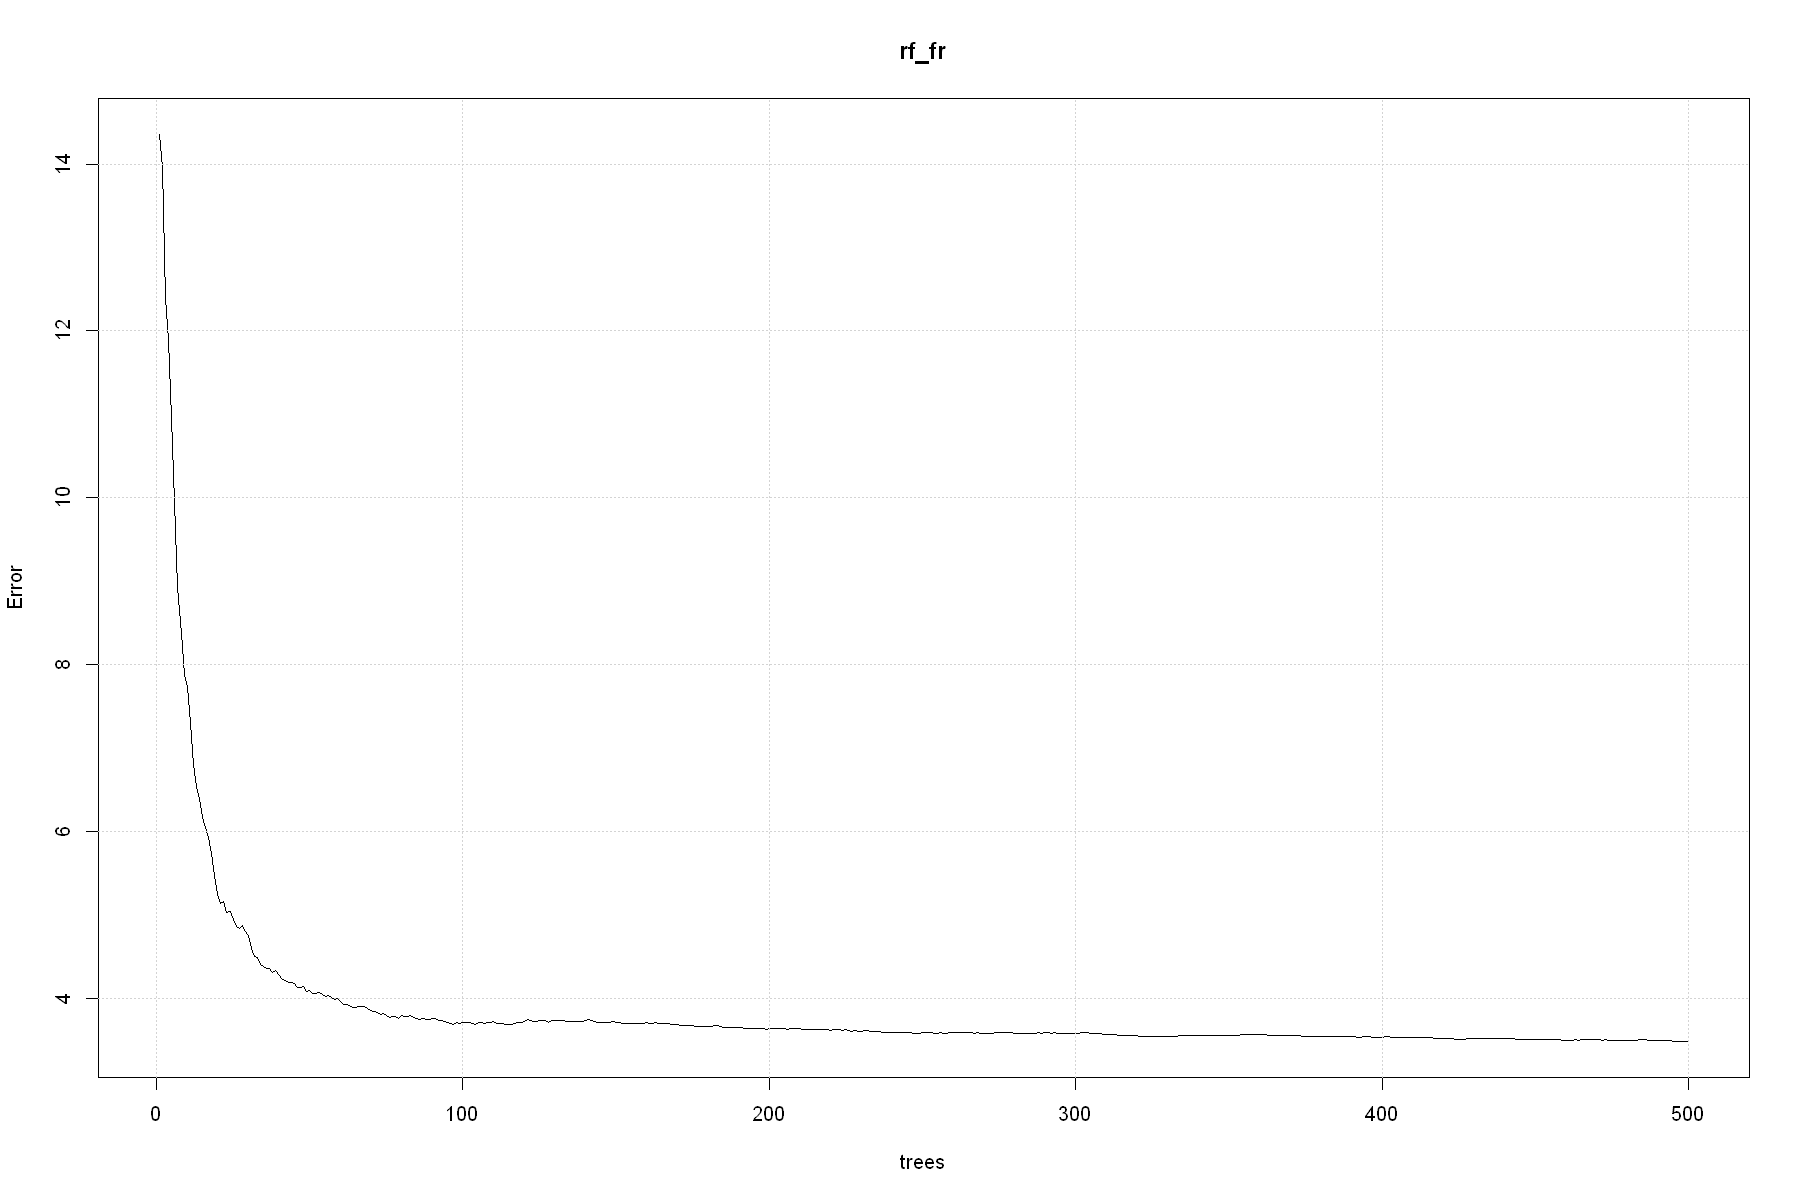

In [4]:
set.seed(71)
(rf_fr <- randomForest(y ~ ., data = train_fr, importance = TRUE)) 
plot(rf_fr)
grid()

In [13]:
#随机森林的泛化性能
cat("randomForest的测试集MSE:",mean((predict(rf_fr, test_fr)  - test_fr$y)^2))    #测试集的MSE
cat("\n")
rto_fr <- treemisc::prune_se(rpart(y ~ .,data = train_fr, cp = 0))     #1-SE最优树
#rpart决策树的泛化性能
cat("rpart决策树的测试集MSE :",mean((predict(rto_fr, test_fr)   - test_fr$y)^2))    #测试集的MSE

randomForest的测试集MSE: 3.424967
rpart决策树的测试集MSE : 8.073128

二者比较，可见随机森林的泛化性能优于决策树

**变量的重要性度量：**

In [10]:
(vip <- rf_fr$importance)

,%IncMSE,IncNodePurity
x1,7.29291992,2404.4801
x2,8.71027159,2624.6632
x3,1.89148567,1110.4659
x4,13.38294569,3883.4248
x5,3.64010042,1583.0506
x6,0.05878773,495.5489
x7,0.09911403,476.2747


%IncMSE计算：
1. grow regression forest. Compute OOB-mse, name this mse0.
1. for 1 to j var: permute values of column j, then predict and compute OOB-mse(j)
1. %IncMSE of j'th is (mse(j)-mse0)/mse0 * 100%

IncNodePurity计算：

IncNodePurity (Increase in Node Purity) expresses the change in the homogeneity of the of the groups created by the trees ,for regression, it is measured by residual sum of squares.

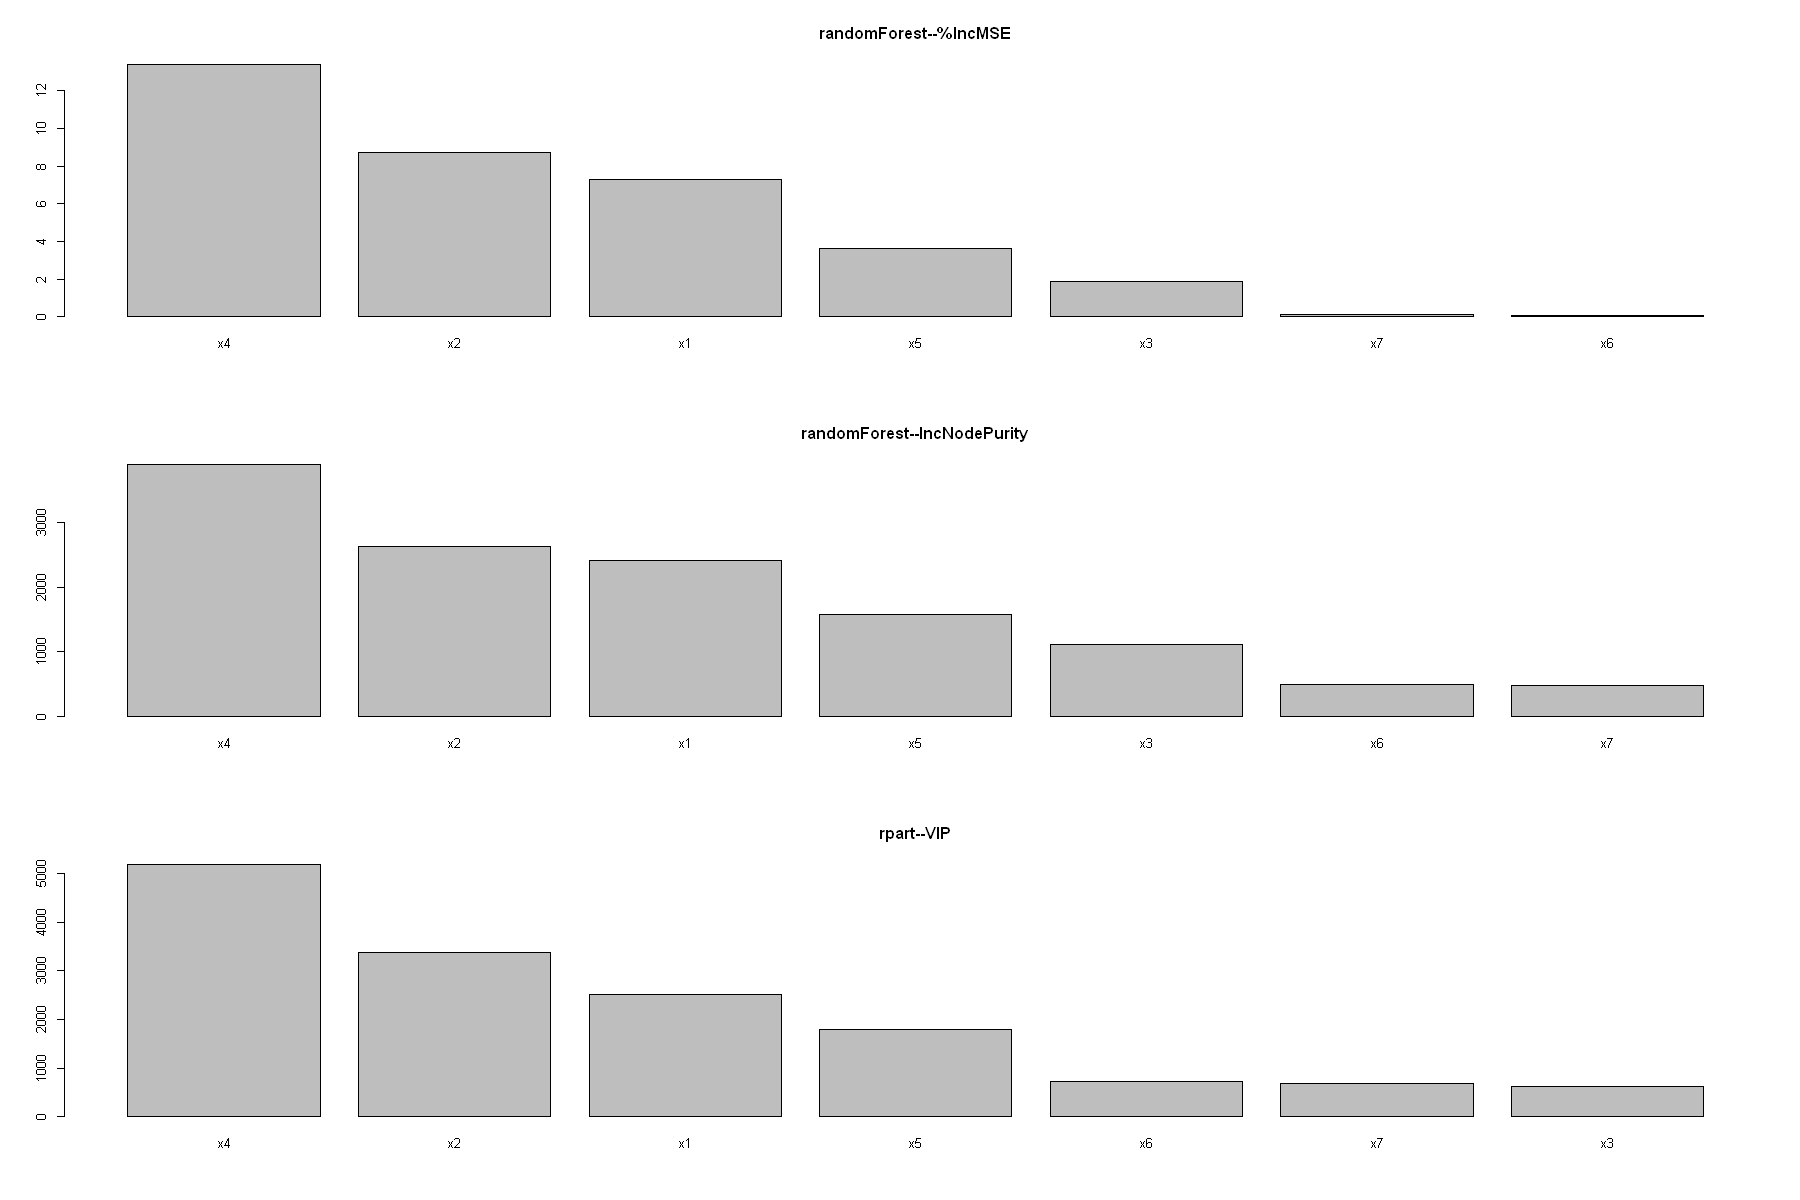

In [15]:
# 变量重要性降序排列
par(mfrow = c(3,1))
barplot(sort(vip[, "%IncMSE"], decreasing = TRUE), main = "randomForest--%IncMSE")
barplot(sort(vip[, "IncNodePurity"], decreasing = TRUE), main = "randomForest--IncNodePurity")
barplot(rto_fr$variable.importance, main = "rpart--VIP")    #最优rpart决策树的变量重要性降序排列

可见三者不尽相同，但随机森林的二种评价方式都将x6、x7排在了重要性的末尾，raprt未能将x6、x7排在重要性的末尾

## 回归：自变量混合取值

abalone数据集来自4177只鲍鱼，自变量包括type(公、母、幼)、LongestShell 、Diameter、 Height和几种重量(WholeWeight、ShuckedWeight、VisceraWeightShellWeight)，因变量是Rings(外壳上的环数)。
  
根据一系列特征推测abalone的年龄值

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

p_load(rpart,randomForest,AppliedPredictiveModeling,skimr)
s <- skim_tee

In [2]:
data(abalone)
ab <- abalone
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  8     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50    p75   p100 hist 
1 LongestShell          0             1 0.524 0.120  0.075  0.45   0.545  0.

In [3]:
#将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab),nrow(ab)*0.5)
train_ab <- ab[I,]
test_ab <- ab[-I,]
s(train_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  8     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50    p75   p100 hist 
1 LongestShell          0             1 0.525 0.120  0.13   0.45   0.545  0.615  0


Call:
 randomForest(formula = Rings ~ ., data = train_ab, importance = TRUE,      proximity = TRUE, localImp = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 4.684307
                    % Var explained: 54.54

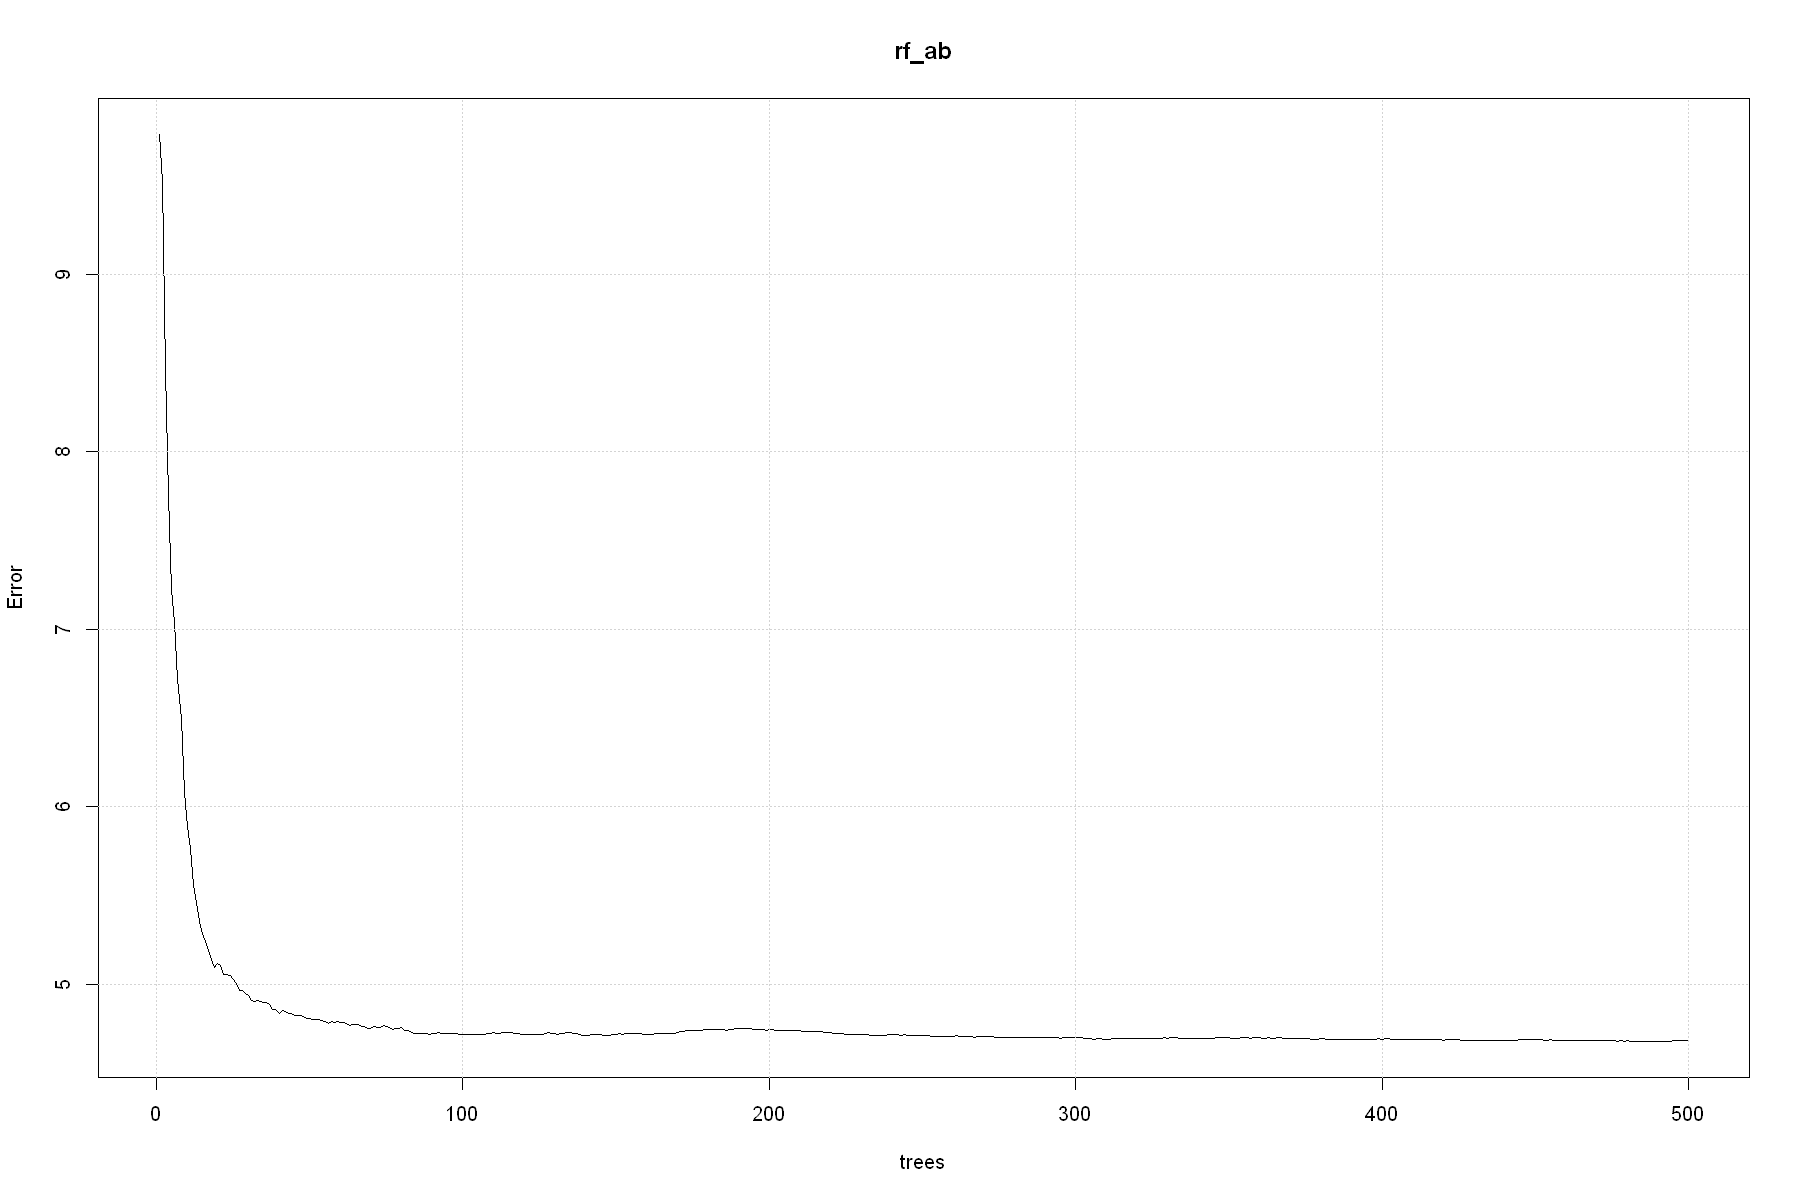

In [4]:
set.seed(71)
(rf_ab <-randomForest(Rings ~ ., data = train_ab, importance = TRUE, proximity = TRUE, localImp = TRUE)) #默认norm.votes=TRUE

plot(rf_ab)
grid()

**优化mtry的值**

mtry = 2  OOB error = 4.715469 
Searching left ...
Searching right ...


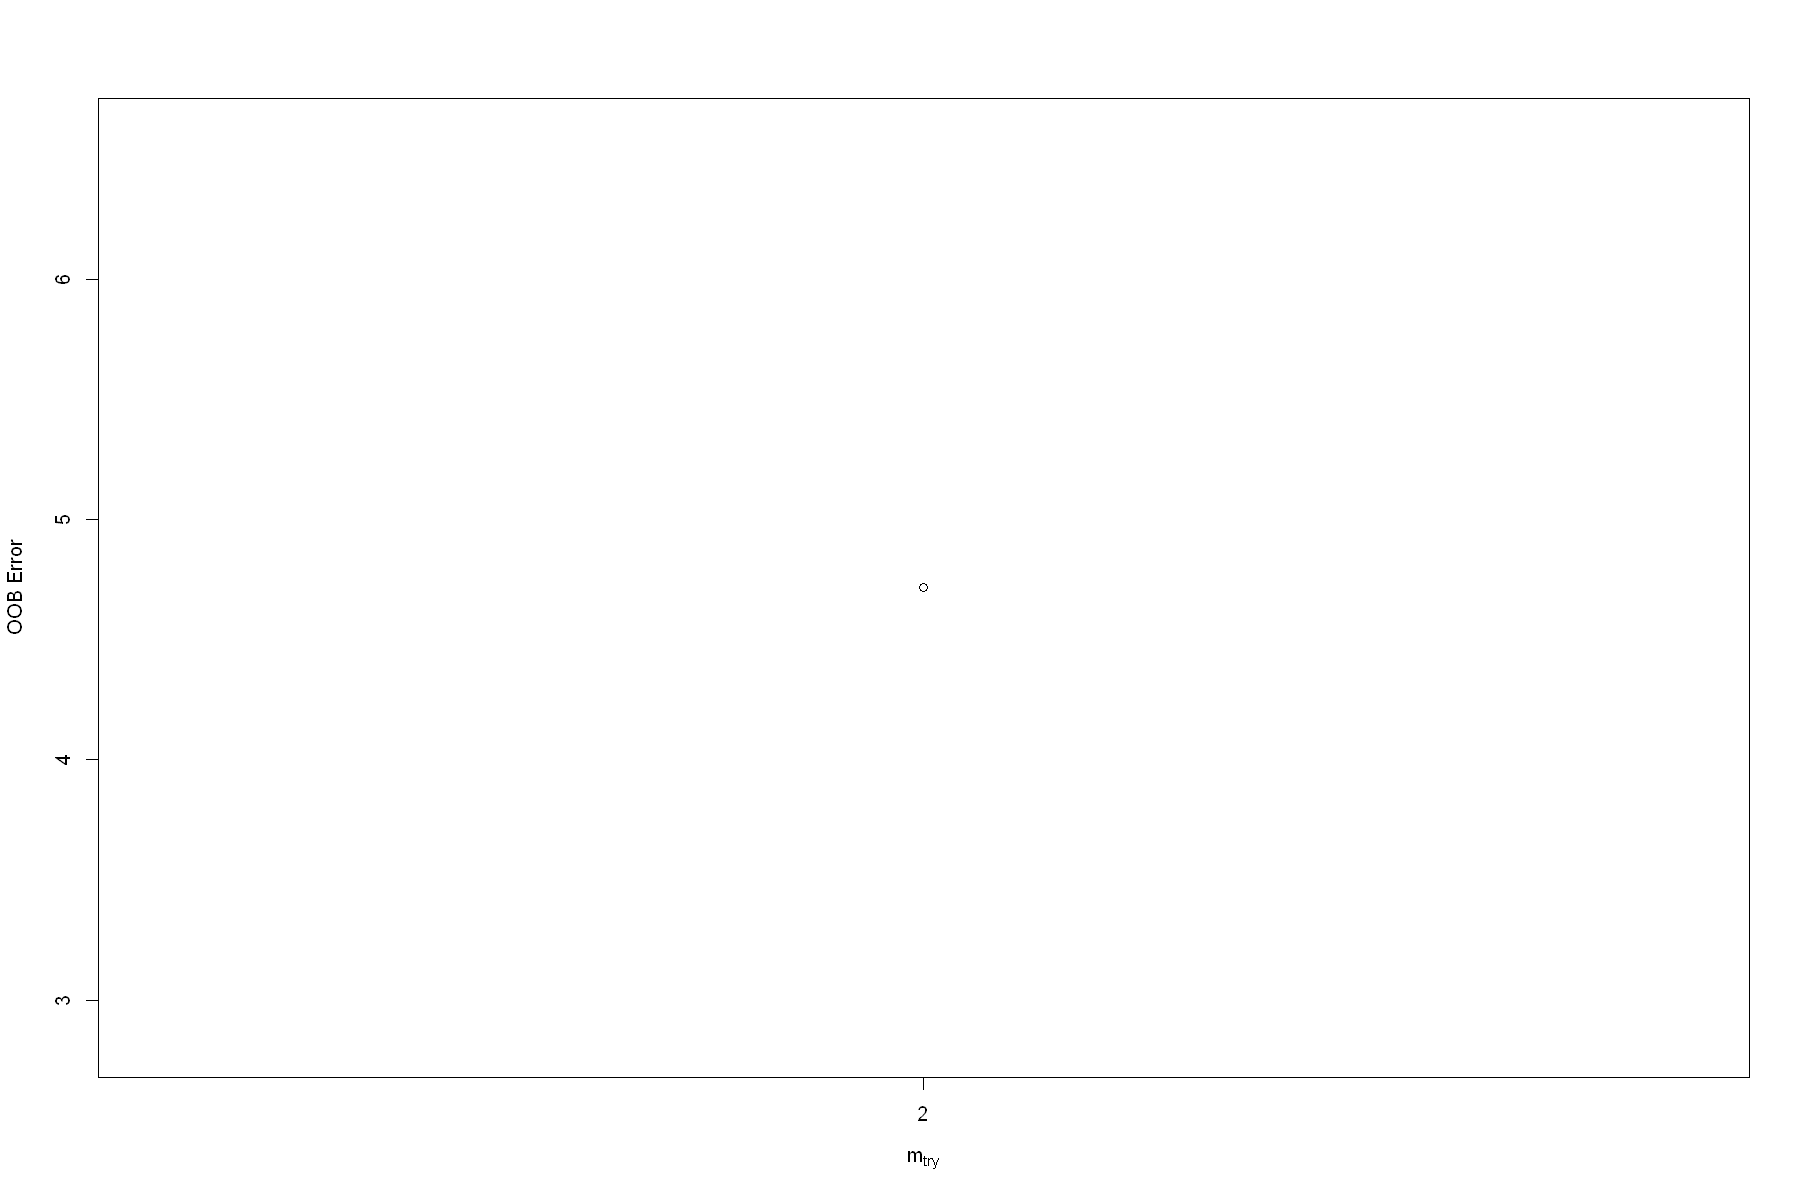

In [24]:
rfo_ab = tuneRF(train_ab[,-9], train_ab[,9], ntreeTry=500, 
                stepFactor=1.2, improve=0.05,trace=TRUE, plot=TRUE, doBest=TRUE)
#以默认值为起点，缩放比为1.2，改善步幅为5%，搜索最优mtry值。若doBest=TRUE，返回以最优mtry值得到相应的随机森林

In [25]:
rto_ab <- treemisc::prune_se(rpart(Rings ~ .,data = train_ab, cp = 0))  #1-SE最优树
#决策树的泛化性能
(MSE_test <- mean((predict(rto_ab, test_ab) - test_ab$Rings)^2))    #测试集的MSE

#随机森林的泛化性能
(MSE_test_f <- mean((predict(rfo_ab, test_ab)  - test_ab$Rings)^2))    #测试集的MSE

[1] 5.687698

[1] 4.62875

可见随机森林的泛化性能优于决策树

## 特征选择-rfcv

### 回归

In [1]:
library(pacman)
p_load(randomForest)

options(warn=-1)    #忽略一切警告
options('width'=140)  #充分利用打印宽度
options(repr.plot.width=15, repr.plot.height=10)  #满幅


set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(2000, nx = 100, sigma = 0.1) # 共100个特征，只有前5个相关
set.seed(111)
i <- sample(2000, 1000)
dTrain <- fr[i, ]
dTest <- fr[-i, ]

Warning message:
"package 'pacman' was built under R version 4.3.3"


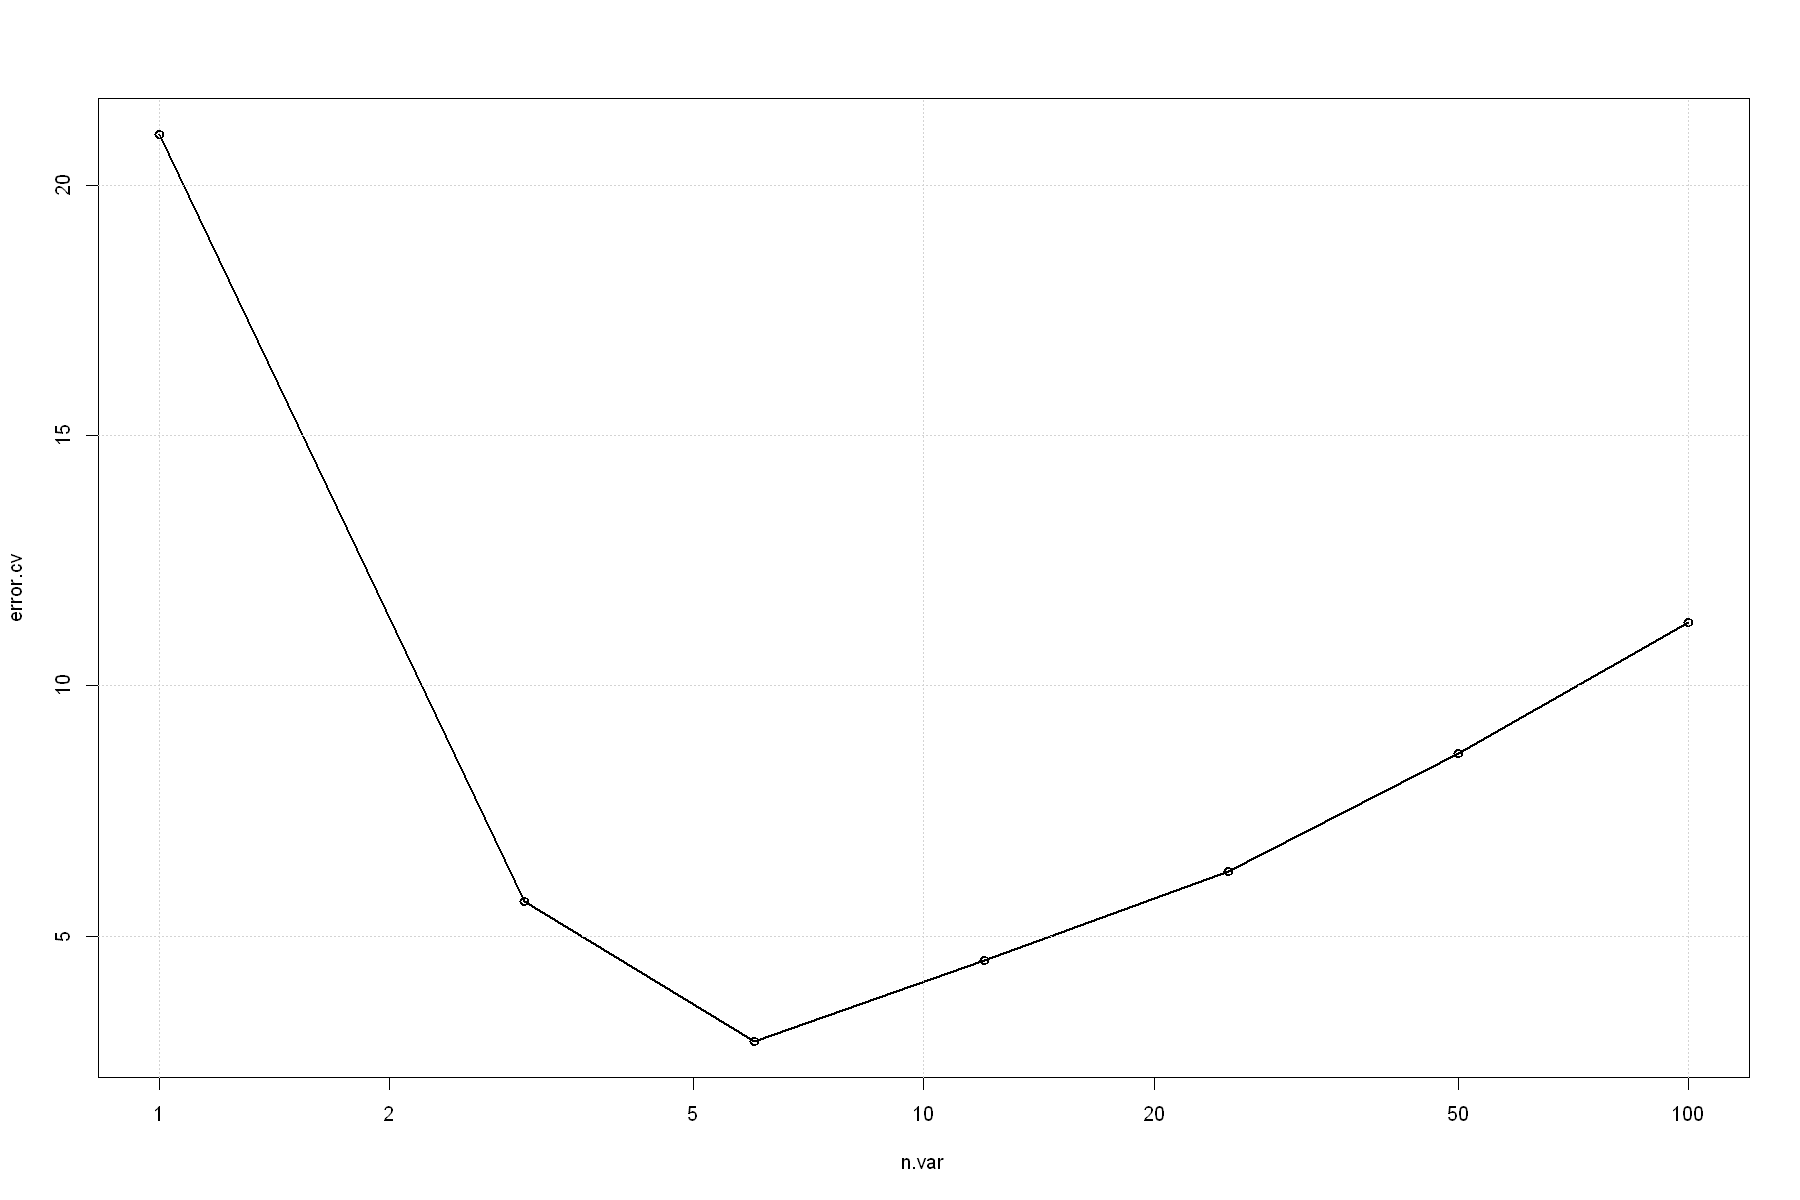

In [2]:
# 成比例消减
set.seed(111)
result <- rfcv(dTrain[, -1], dTrain$y, cv.fold = 3)  #默认scale="log", step=0.5--每次消减一半
with(result, plot(n.var, error.cv, log = "x", type = "o", lwd = 2))
grid()

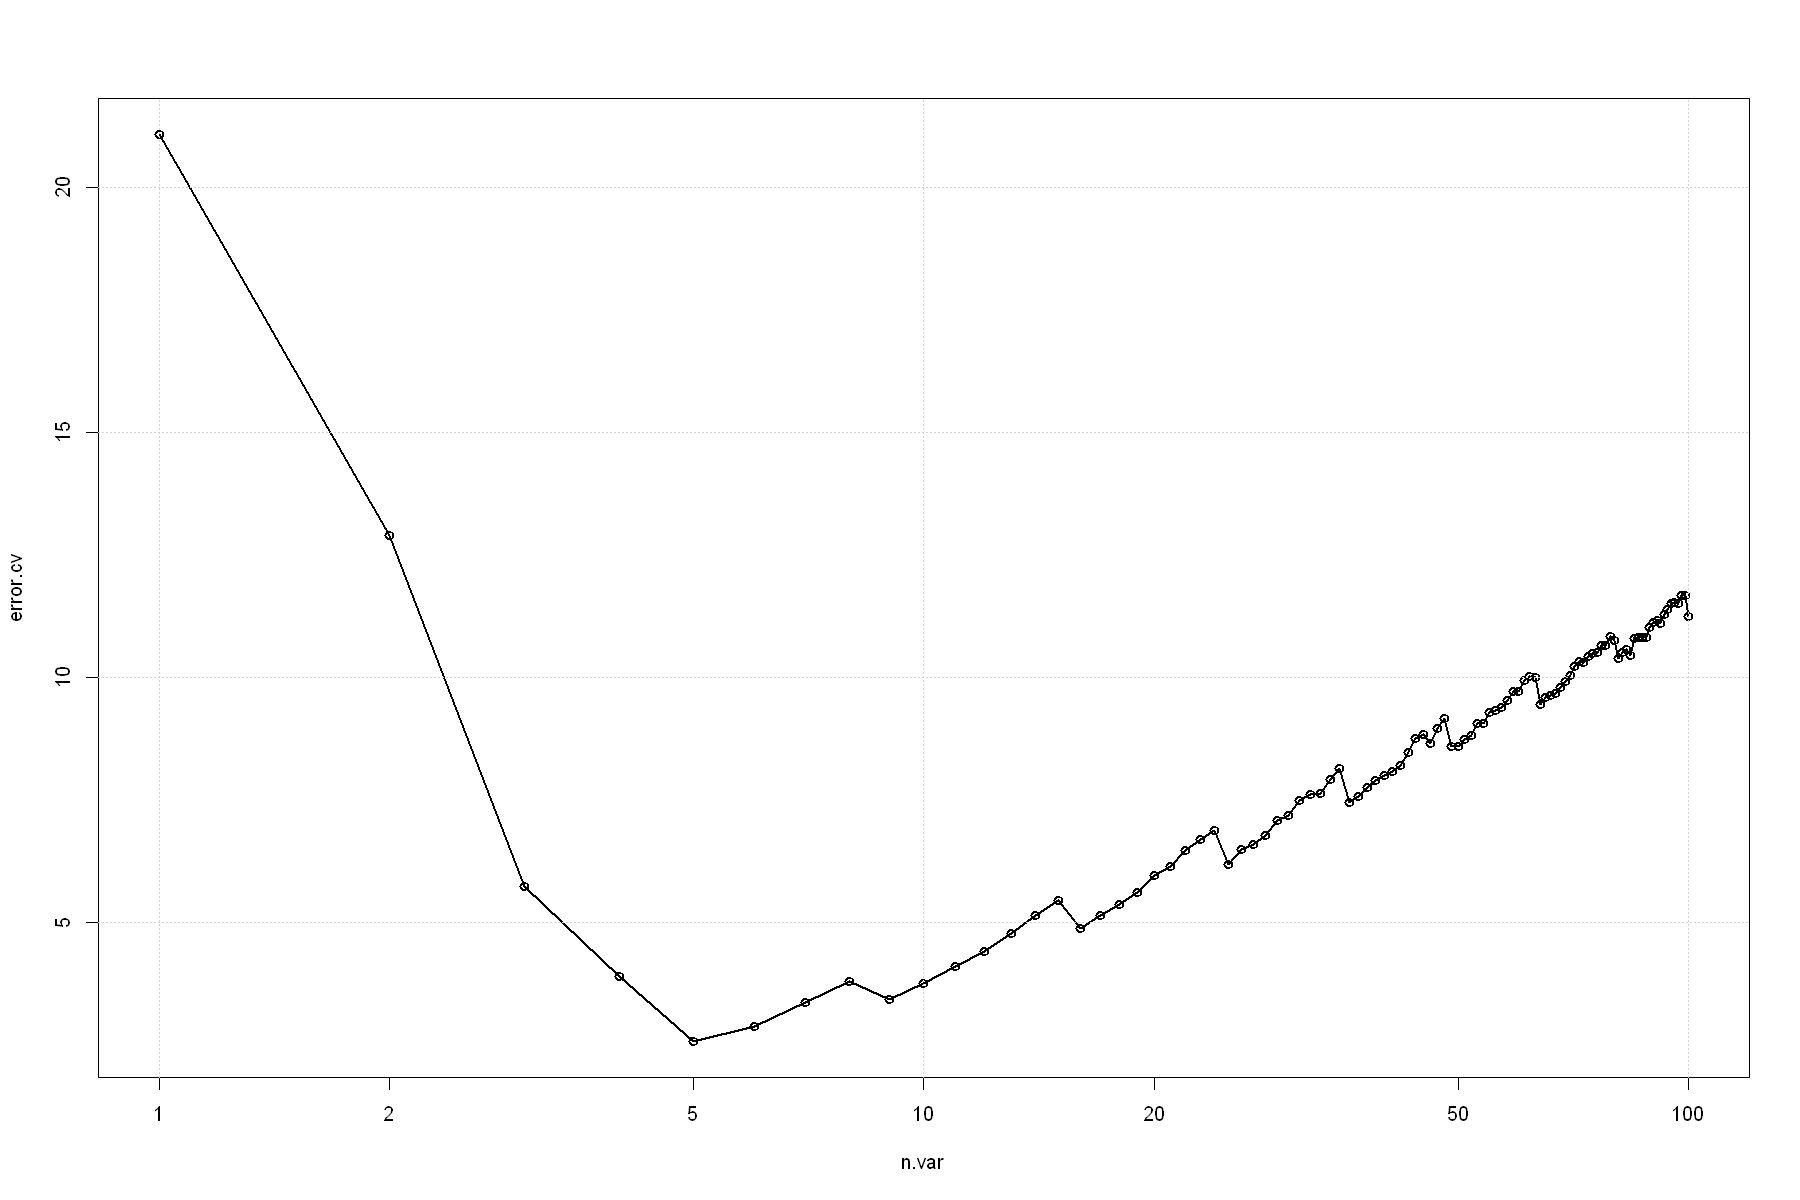

In [3]:
#固定步距消减
set.seed(111)
result <- rfcv(dTrain[, -1], dTrain$y, scale = "step", step = -1, cv.fold = 3)  #每次消减 1
with(result, plot(n.var, error.cv, log = "x", type = "o", lwd = 2))
grid()

gen_friedman1数据集实际上只有前5个特征与目标相关，可见rfcv可以准确地衡量出最相关变量个数。

比较特征精选前后训练耗时以及误差：

In [5]:
system.time(rf <- randomForest(y ~ ., data = dTrain, ntree = 1000))
(mseTrain <- mean((rf$predicted - dTrain$y)^2))  # 训练集误差(OOB)
(mseTest <- mean((predict(rf, dTest) - dTest$y)^2)) # 测试集误差

   user  system elapsed 
  15.05    0.03   15.08 

[1] 5.125016

[1] 4.521096

In [6]:
dTrain5 <- dTrain[, 1:6] # 只用前5个特征
system.time(rf5 <- randomForest(y ~ ., data = dTrain5, ntree = 1000))
(mseTrain5 <- mean((rf5$predicted - dTrain5$y)^2))  # 训练集误差(OOB)
(mseTest5 <- mean((predict(rf5, dTest) - dTest$y)^2)) # 测试集误差

   user  system elapsed 
   1.12    0.05    1.19 

[1] 2.907148

[1] 2.618385

可见特征精选后，训练集(OOB)和测试集的误差均小于之前的，并且训练耗时显著降低。

### 分类

In [7]:
library(pacman)
p_load(randomForest)

options(warn=-1)    #忽略一切警告
options('width'=140)  #充分利用打印宽度
options(repr.plot.width=15, repr.plot.height=10)  #满幅

set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(2000, nx = 100, sigma = 0.1) # 共100个特征，包括前5个相关的
#skimr::skim(fr) 
set.seed(111)
i <- sample(2000, 1000)
fr$y <- factor(fr$y > 14.3)  #将回归问题改成分类问题，14.2是原y的p50点
dTrain <- fr[i, ]
dTest <- fr[-i, ]

#skimr::skim(fr)   #可见类别y是平衡的

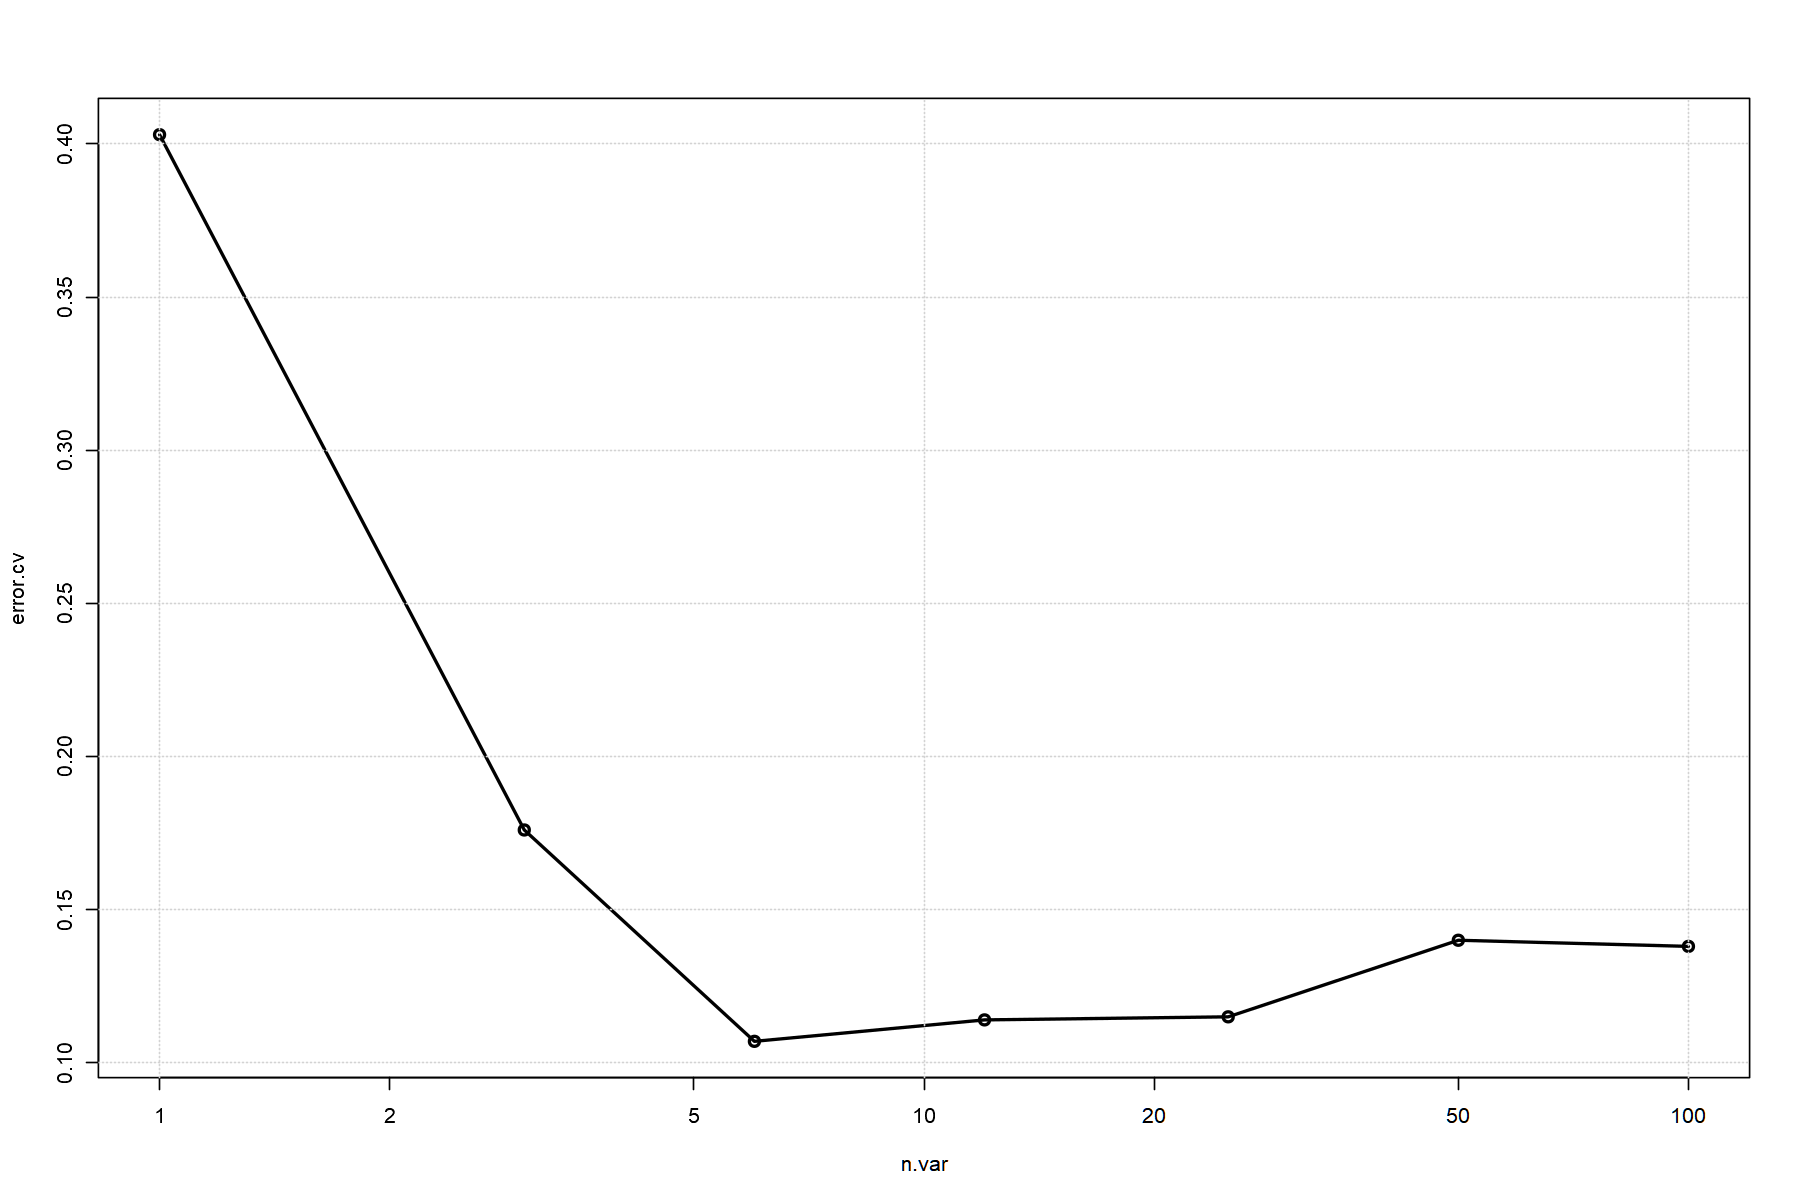

In [ ]:
# 成比例消减
set.seed(111)
result <- rfcv(fr[, -1], fr$y, cv.fold = 3)
with(result, plot(n.var, error.cv, log = "x", type = "o", lwd = 2))
grid()

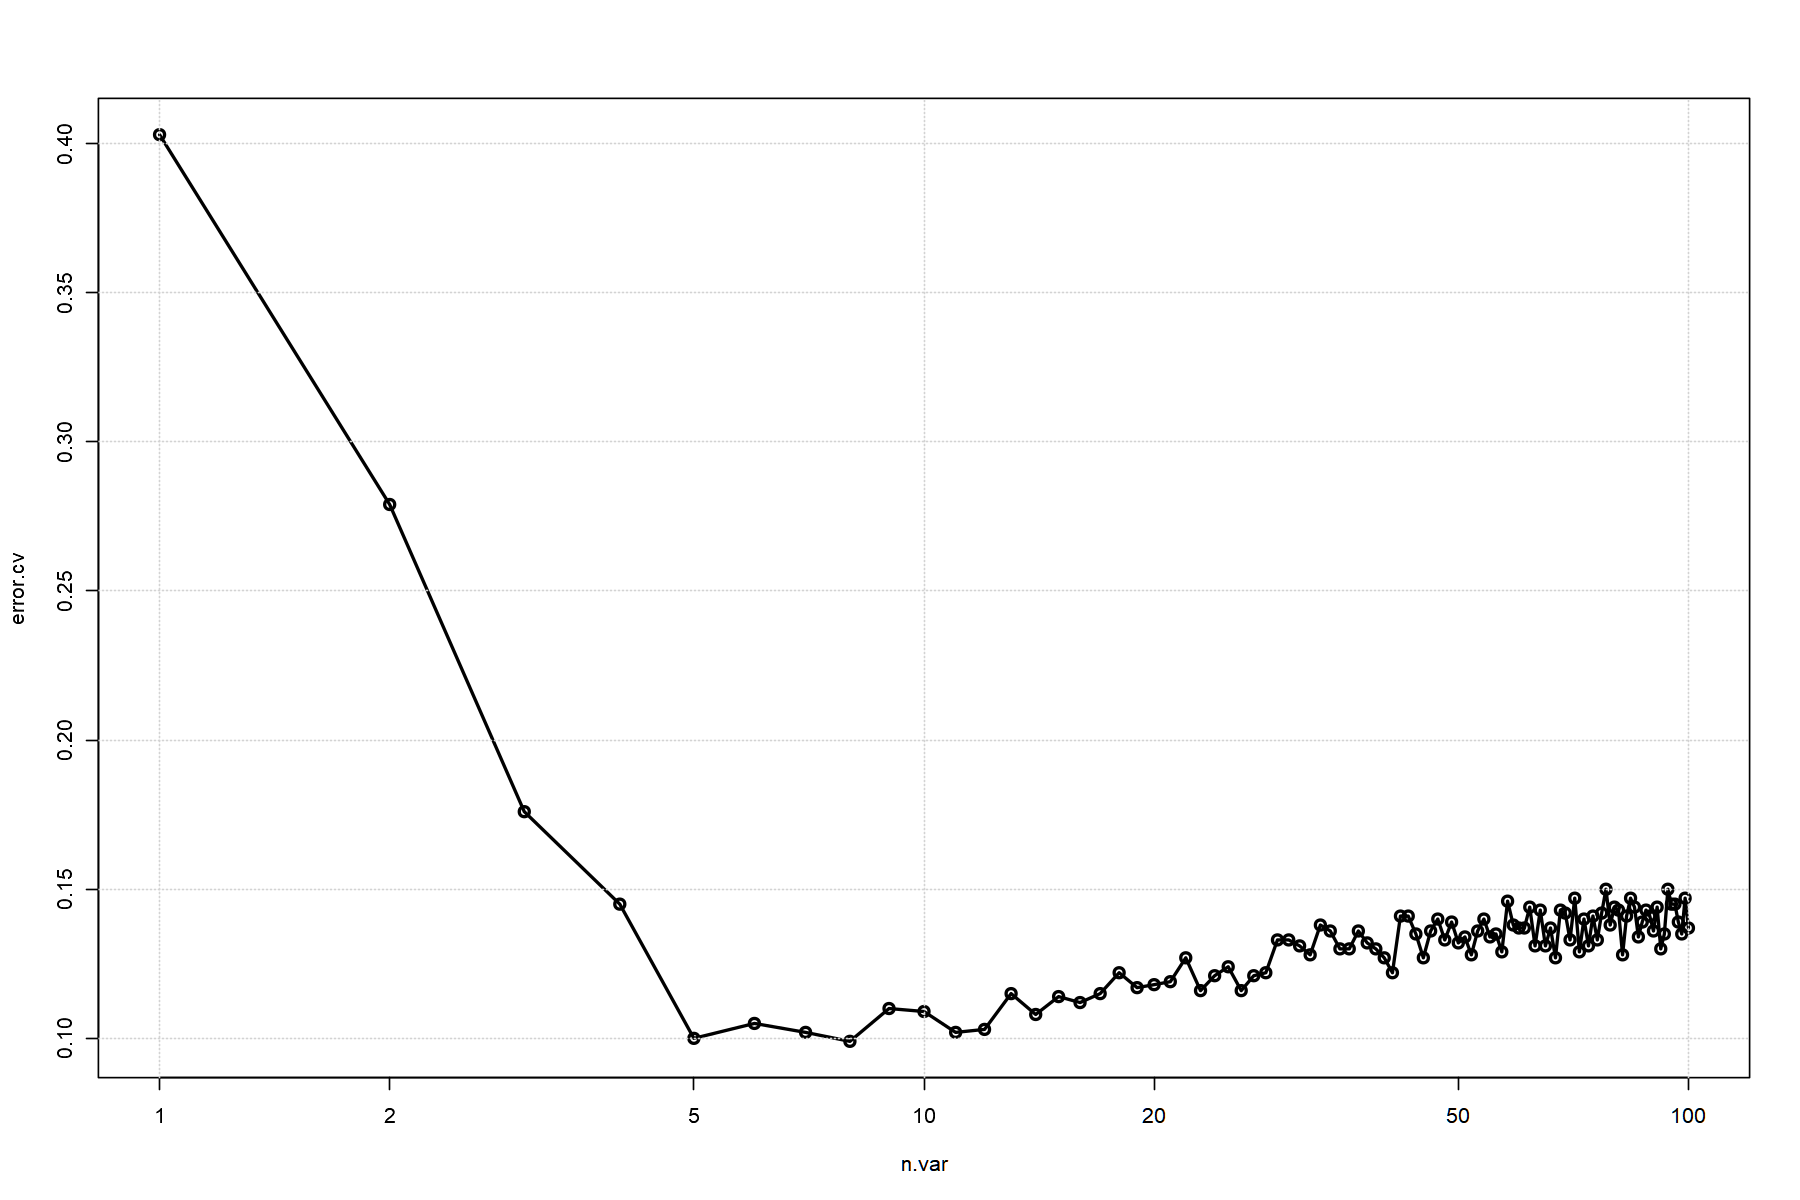

In [ ]:
#固定步距消减
set.seed(111)
result <- rfcv(fr[, -1], fr$y, scale = "step", step = -1, cv.fold = 3)  #每次消减 1
with(result, plot(n.var, error.cv, log = "x", type = "o", lwd = 2))
grid()

gen_friedman1数据集实际上只有前5个特征与目标相关，可见rfcv可以准确地衡量出最相关变量个数。

比较特征精选前后训练耗时以及误差：

In [8]:
system.time(rf <- randomForest(y ~ ., data = dTrain, ntree = 1000))
(errorTrain <- mean((rf$predicted != dTrain$y)))  # 训练集误差(OOB)
(errorTest <- mean((predict(rf, dTest) != dTest$y))) # 测试集误差

   user  system elapsed 
   4.07    0.00    4.08 

[1] 0.122

[1] 0.123

In [9]:
dTrain5 <- dTrain[, 1:6] # 只用前5个特征
system.time(rf5 <- randomForest(y ~ ., data = dTrain5, ntree = 1000))
(errorTrain5 <- mean((rf5$predicted != dTrain5$y)))  # 训练集误差(OOB)
(errorTest5 <- mean((predict(rf5, dTest) != dTest$y))) # 测试集误差

   user  system elapsed 
   0.41    0.00    0.40 

[1] 0.089

[1] 0.1

可见特征精选后，训练集(OOB)和测试集的误差均小于之前的，并且训练耗时显著降低。

**另外可见：无关特征会扰乱随机森林，训练耗时增加且预测精度下降。**